In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
import datetime
import plotly.graph_objects as go
import plotly.express as px



In [2]:
def gini(list_of_values):
    n = len(list_of_values)
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area * (n-1)/n

In [2067]:
def convert_blocktime(blocktime, **kwargs):
    delta = kwargs.get('delta',6)
    if blocktime is None:
        return None
    else:
        timestr = blocktime.replace('T',' ').replace('Z','')
        return datetime.datetime.strptime(timestr[:-delta], "%Y-%m-%d %H:%M:%S")

In [2068]:
def add_datestr_col(df, date_col, **kwargs):
    delta = kwargs.get('delta',6)
    df['datestr']=[convert_blocktime(df[date_col].iloc[i],delta=delta) for i in range(0, len(df))]

In [743]:
def add_cols(df, **kwargs):
    bound_1=kwargs.get('bound_1',10001)
    bound_2=kwargs.get('bound_2',100000)
    time_ranges = kwargs.get('time_ranges',[])

    if len(time_ranges)>0:
        for tr in time_ranges:
            tr_str = str(tr)
            df['share_vol_' + tr_str+ 'd'] = df['volume_' + tr_str +'d']/sum(df['volume_' + tr_str +'d'])
            df['share_swaps_' + tr_str+ 'd'] = df['swaps_' + tr_str+ 'd']/sum(df['swaps_' + tr_str+ 'd'])
            # df = df.sort_values(by='share_vol_' + tr_str+ 'd',ascending=False)
            # df['cs_share_vol_'+ tr_str+ 'd'] =np.cumsum(df['share_vol_' + tr_str+ 'd'])
            # df['cs_share_swaps_' + tr_str+ 'd'] = np.cumsum(df['share_swaps_' + tr_str+ 'd'])
            df['rank_vol_' + tr_str+ 'd'] = df['volume_' + tr_str+ 'd'].rank(ascending=False)
            df['rank_swaps_' + tr_str+ 'd'] = df['swaps_' + tr_str+ 'd'].rank(ascending=False)
            df['avg_trade_size_' + tr_str+ 'd'] = df['volume_' + tr_str+ 'd']/df['swaps_' + tr_str+ 'd']/1000

    df['share_vol'] = df.total_volume/sum(df.total_volume)
    df['share_swaps'] = df.total_swaps/sum(df.total_swaps)

    # df = df.sort_values(by='share_vol', ascending=False)
    df['cs_share_vol'] =np.cumsum(df.share_vol)
    df['cs_share_swaps'] = np.cumsum(df.share_swaps)
    df['rank_vol'] = df.total_volume.rank(ascending=False)
    df['rank_swaps'] = df.total_swaps.rank(ascending=False)
    
    df['avg_trade_size'] = df.total_volume/df.total_swaps/1000
    
    df['rank_grp'] = str(round(bound_1/1000,1)) + 'k to ' + str(round(bound_2/1000,1)) + 'k'
    df.loc[df.rank_vol<bound_1,'rank_grp'] = '<' + str(round(bound_1/1000,1)) + 'k'
    df.loc[df.rank_vol>bound_2,'rank_grp'] = '>' + str(round(bound_2/1000,1)) + 'k'

In [543]:
def get_preferred_trade_time(df, **kwargs):
    swap_col=kwargs.get('swap_col','total_swaps')
    vol_col = kwargs.get('vol_col','total_volume')
    has_age_col=kwargs.get('has_age_col',0)
    age_col=kwargs.get('age_col','days_age')
    active_col = kwargs.get('active_col','days_active')
    last_tx_col = kwargs.get('last_tx_col','days_last')

    df['preferred_trade_time']=30
    
    df.loc[((df.hour_cnt<4)&(df.hour_min>6)&(df.hour_max<19)),'preferred_trade_time'] = np.array(df[(df.hour_cnt<4)&(df.hour_min>6)&(df.hour_max<19)].hour_weighted)
    df.loc[((df.hour_min>10)),'preferred_trade_time'] = np.array(df[(df.hour_min>10)].hour_weighted)
    df.loc[((df.hour_max<14)),'preferred_trade_time'] = np.array(df[(df.hour_max<14)].hour_weighted)
    for i in range(0,22):
        df.loc[(df.hour_min==i) &(df.hour_max<=12+i) ,'preferred_trade_time'] = np.array(df[(df.hour_min==i) &(df.hour_max<=12+i)].hour_weighted)
    for i in range(0,12):
        df.loc[(df.hour12_max==i) &(df.hour24_min>12+i) ,'preferred_trade_time'] = np.array(df[(df.hour12_max==i) &(df.hour24_min>12+i)].hour_shifted)

    
    df.loc[(df.preferred_trade_time==30) & (df.hour_cnt<2),'preferred_trade_time']=np.array(df[(df.preferred_trade_time==30) & (df.hour_cnt<2)].hour_weighted)
    df.loc[(df.preferred_trade_time==30) & (df.hour_cnt>12),'preferred_trade_time']=25
    
    if has_age_col>0:
        df.loc[(df.preferred_trade_time==30) & (df.hour_cnt>12),'preferred_trade_time']=25
        # df.loc[(df.preferred_trade_time==30) &(df.hour_cnt>10)& (df[swap_col]>500) & ((df[swap_col]/df[active_col]>0.8)),'preferred_trade_time']=26
        df.loc[(df.preferred_trade_time==30) & (df[last_tx_col]>365),'preferred_trade_time']= 27
    
    df.loc[(df.preferred_trade_time==30) &(df.hour_cnt>12) & (abs(df.hour_mean-df.hour_weighted)<1) ,'preferred_trade_time']=np.array(df[(df.preferred_trade_time==30) &(df.hour_cnt>12) & (abs(df.hour_mean-df.hour_weighted)<1)].hour_weighted)
    df.loc[(df.preferred_trade_time==30) &(df.trade_span_outer>df.trade_span),'preferred_trade_time'] = np.array(df[(df.preferred_trade_time==30) &(df.trade_span_outer>df.trade_span)].hour_weighted)
    df.loc[(df.preferred_trade_time==30) &(df.trade_span_outer<df.trade_span),'preferred_trade_time'] = np.array(df[(df.preferred_trade_time==30) &(df.trade_span_outer<df.trade_span)].hour_shifted)
    # df.loc[(df.preferred_trade_time==30) & (df.trade_span<=8) & (df.hour_max<17),'preferred_trade_time']= np.array(df[(df.preferred_trade_time==30) & (df.trade_span<=8) & (df.hour_max<17)].hour_weighted)

    

In [2428]:
def agg_cow_users(df_cow, criteria, **kwargs):
    time_ranges = kwargs.get('time_ranges',[])
    
    df_out  = df_cow.groupby(criteria, dropna=False).agg(total_volume=('total_volume','sum'),
                total_swaps=('total_swaps','sum'),
                share_vol = ('share_vol','sum'),
                share_swaps = ('share_swaps','sum'),
                days_active_cow = ('days_active_x','median'),
                days_active_eth = ('days_age','median'),
                avg_fees = ('avg_fees','mean'),
                sum_fees = ('avg_fees','sum'),
                avg_cost = ('avg_cost','mean'),
                sum_cost = ('avg_cost','sum'),
                avg_cost_coverage = ('cost_coverage','mean'),
                num_trader = ('trader','nunique'),
                num_user = ('user_id','nunique'),
                day_first = ('day_first','min'),
                day_last = ('day_last','max'),
                num_geos = ('geography','nunique')
    ).reset_index()
    df_out['share_fees'] = df_out.sum_fees/np.nansum(df_out.sum_fees)
    df_out['share_cost'] = df_out.sum_cost/np.nansum(df_out.sum_cost)
    df_out['cost_coverage'] = df_out.sum_fees/df_out.sum_cost
    df_out['share_trader'] = df_out.num_trader/sum(df_out.num_trader)

    if len(time_ranges)>0:
        for tr in time_ranges:
            tr_str = str(tr)
            df_out_2 = df_cow.groupby(criteria, dropna=False).agg({
                'swaps_' + tr_str + 'd':'sum',
                'volume_' + tr_str + 'd':'sum',
                # 'avg_fees_' + tr_str + 'd':'mean',
                'avg_fees_' + tr_str + 'd':'sum',
                # 'avg_cost_' + tr_str + 'd':'mean',
                'avg_cost_' + tr_str + 'd':'sum',
                'cost_coverage_' + tr_str + 'd':'mean'
            }).reset_index()

            df_out_2= df_out_2.rename(columns={'cost_coverage_' + tr_str + 'd':'avg_cost_coverage_' + tr_str + 'd'})

            df_out_2['share_swaps_' + tr_str + 'd'] = df_out_2['swaps_' + tr_str + 'd']/sum(df_out_2['swaps_' + tr_str + 'd'])
            df_out_2['share_vol_' + tr_str + 'd'] = df_out_2['volume_' + tr_str + 'd']/sum(df_out_2['volume_' + tr_str + 'd'])
            df_out_2['cost_coverage_' + tr_str + 'd'] = df_out_2['avg_fees_' + tr_str + 'd']/df_out_2['avg_cost_' + tr_str + 'd']
            df_out_2['avg_swap_size_' + tr_str + 'd']=df_out_2['volume_' + tr_str + 'd']/df_out_2['swaps_' + tr_str + 'd']
            df_out_2['volume_per_trader_' + tr_str + 'd']=df_out_2['volume_' + tr_str + 'd']/df_out.num_trader/1000
            df_out_2['volume_per_user_' + tr_str + 'd']=df_out_2['volume_' + tr_str + 'd']/df_out['num_user']/1000
            df_out = df_out.merge(df_out_2, how='left', left_on=criteria,right_on=criteria).reset_index()

    return df_out

In [2310]:
def get_geographies(df, **kwargs):
    df['geography'] = 'unknown'
    df.loc[(df.preferred_trade_time<8) & (df.preferred_trade_time>=0),'geography'] = 'asia'
    df.loc[(df.preferred_trade_time>=8)&(df.preferred_trade_time<16),'geography'] = 'europe'
    df.loc[(df.preferred_trade_time>=16)&(df.preferred_trade_time<=24),'geography'] = 'us'
    df.loc[df.preferred_trade_time==25,'geography'] = 'active >12 distinct hours'
    df.loc[df.preferred_trade_time==26,'geography'] = 'special purpose/degen: >10h active and (>0.8tx/day or >17h active)'
    df.loc[df.preferred_trade_time==27,'geography'] = 'wallet >1y inactive'
    df.loc[df.preferred_trade_time==25,'preferred_trade_time']=np.array(df[(df.preferred_trade_time==25)].hour_weighted)
    df.loc[df.preferred_trade_time==26,'preferred_trade_time']=np.array(df[(df.preferred_trade_time==26)].hour_weighted)
    df.loc[df.preferred_trade_time==27,'preferred_trade_time']=np.array(df[(df.preferred_trade_time==27)].hour_weighted)
    df.loc[df.preferred_trade_time==30,'preferred_trade_time']=np.array(df[(df.preferred_trade_time==30)].hour_weighted)
    


In [2245]:
def get_user_grp(df, month_list):
    df['user_grp']=''
    for num_month in range(0,len(month_list)):
    #1) new past 30d
    #2) repeat 30d
    #3) repeat 90d
    #4) active non repeat 90d
    #5) non active >180d
    #6) non active >365d

        if num_month==0:
            df.loc[(df.month_date==month_list[num_month]) & (df.day_first<=30),'user_grp']='new'
        
        if num_month>0:
            df.loc[(df.month_date==month_list[num_month]) & (df.day_first<=30)
            & (~df.trader.isin(df[(df.month_date==month_list[num_month-1]) ].trader.unique())),'user_grp']='new'

            #did have volume last month
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_30d>0)].trader.unique())),'user_grp'] = 'repeat_30d'
            
            #didnt have volume last month, but last 90days (before current month)
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') & 
            (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_90d>0)].trader.unique())),'user_grp'] = 'repeat_90d'

            #didnt have volume last month and last 90days, but last 180days (before current month)
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') &
                (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_180d>0)].trader.unique())),'user_grp'] = 'repeat_180d'
        else:
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_30d>0)].trader.unique())),'user_grp'] = 'repeat_30d'    
        
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_90d>0)].trader.unique())),'user_grp'] = 'repeat_90d'    
            
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') &
                (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_180d>0)].trader.unique())),'user_grp'] = 'repeat_180d'

        #no volume past 180days (before current month), but in past year
        df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.day_last<365)
            ,'user_grp'] = 'not active >6m'

        #no volume past year
        df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.day_last>365)
            ,'user_grp'] = 'not active >1y'

        
        # df.loc[(df.month_date==month_list[num_month]) & 
        #     (df.user_grp=='') &
        #     (df.day_last>=180)
        #     ,'user_grp'] = 'not active >6m'





## DEX users

In [4]:
df=pd.read_csv('dex_platforms.csv')

In [59]:
df.sort_values(by='total_volume', ascending=False)

project     user  total_volume  total_swaps
6                     Uniswap  4858901  1.044832e+12     77140029
7                       other  1994836  3.864806e+11     15294782
3                       Curve   105982  2.022783e+11       941119
5                   Sushiswap  1003236  1.805856e+11      9089897
1                    Balancer   239369  4.588910e+10      1988514
4                        DODO    43139  3.078571e+10       256086
2                CoW Protocol       48  1.463804e+10       365120
0  1inch Limit Order Protocol     2481  1.028128e+08         5320

In [565]:
sum(df.user)

NameError: name 'df' is not defined

In [761]:
df_cow_users_2[['rank_vol','rank_vol_90d','rank_vol_180d']][df_cow_users_2.rank_vol_180d<101]

rank_vol  rank_vol_90d  rank_vol_180d
0           1.0           1.0            1.0
2          11.0           3.0           60.0
3           6.0           4.0            6.0
8          21.0           9.0           26.0
15         38.0          16.0           53.0
...         ...           ...            ...
56742      36.0       40344.5            9.0
59762     248.0       40344.5           80.0
61051     143.0       40344.5           61.0
64567     284.0       40344.5           86.0
64938      35.0       40344.5            7.0

[100 rows x 3 columns]

In [5]:
df_top = pd.read_csv('dex_top_users_1.csv')
df_2 = pd.read_csv('dex_top_users_2.csv')
df_3 = pd.read_csv('dex_top_users_3.csv')
df_4 = pd.read_csv('dex_top_users_4.csv')
df_5 = pd.read_csv('dex_top_users_5.csv')
df_6 = pd.read_csv('dex_top_users_6.csv')
df_7 = pd.read_csv('dex_top_users_7.csv')

In [11]:
df_all_project = pd.concat([df_top,df_2,df_3,df_4,df_5,df_6, df_7]).reset_index()

In [12]:
df_all_project['share_vol'] = df_all_project.total_volume/sum(df.total_volume)
df_all_project['share_swaps'] = df_all_project.total_swaps/sum(df.total_swaps)

In [13]:
df_all_project=df_all_project.drop_duplicates(['user','project'])

In [46]:
df_top_all_1 = pd.read_csv('dex_top_users_all_1.csv')
df_top_all_2 = pd.read_csv('dex_top_users_all_2.csv')
df_top_all_3 = pd.read_csv('dex_top_users_all_3.csv')
df_top_all_4 = pd.read_csv('dex_top_users_all_4.csv')
df_top_all_5 = pd.read_csv('dex_top_users_all_5.csv')
df_top_all_6 = pd.read_csv('dex_top_users_all_6.csv')
df_top_all_7 = pd.read_csv('dex_top_users_all_7.csv')
df_top_all_8 = pd.read_csv('dex_top_users_all_8.csv')
df_top_all_9 = pd.read_csv('dex_top_users_all_9.csv')
df_top_all_10 = pd.read_csv('dex_top_users_all_10.csv')

In [47]:
df = pd.concat([df_top_all_1,df_top_all_2,df_top_all_3,df_top_all_4,df_top_all_5,
df_top_all_6,df_top_all_7,df_top_all_8,df_top_all_9,df_top_all_10]).reset_index()

In [50]:
df_top_all=df_top_all.drop_duplicates(['user']).reset_index()

In [ ]:
add_cols(df_top_all)

In [128]:
df_active_bottom = pd.read_csv('active_users_bottom.csv')

In [129]:
df_active = pd.concat([df_top_all[(df_top_all.status=='active')].reset_index(drop=True),df_active_bottom]).drop_duplicates('user')


In [151]:
add_cols(df_active, bound_1 = int(10000/5500000*len(df_active)), bound_2 = int(100000/5500000*len(df_active)))

In [146]:
10000/5500000*len(df_active)

1189.169090909091

Text(0.5, 1.0, 'Volume- and trade-share for wallets active past 2 months')

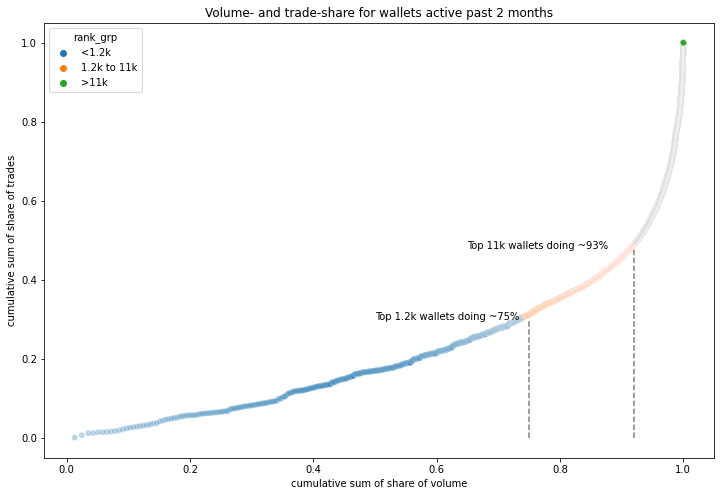

In [152]:
fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_active, x='cs_share_vol', y='cs_share_swaps', hue='rank_grp', alpha=0.3)
mp.plot([0.75,0.75],[0,0.3], color='gray', linestyle='--')
mp.text(0.5,0.3,'Top 1.2k wallets doing ~75%')
mp.plot([0.92,0.92],[0,0.48], color='gray', linestyle='--')
mp.text(0.65,0.48,'Top 11k wallets doing ~93%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Volume- and trade-share for wallets active past 2 months')


Text(0.5, 0, '')

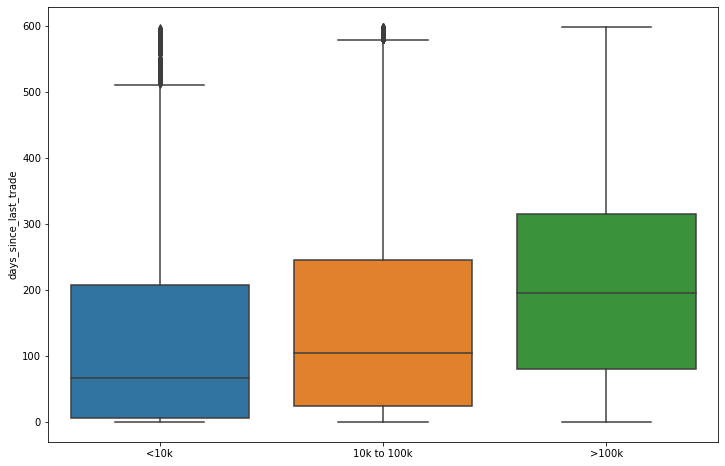

In [86]:
fig,axs=mp.subplots(figsize=(12,8))
sns.boxplot(data=df_top_all, y='days_since_last_trade', x='rank_grp', ax=axs)
axs.set_xlabel('')
# axs.set_ylim(0,100)
# axs.set_ylabel('Avg trade size (k $)')


In [89]:
len(df_top_all[(df_top_all.status=='inactive') & (df_top_all.rank_vol>100001)
# & (df_top_all.rank_vol<100001)
])

717748

(0.0, 300000.0)

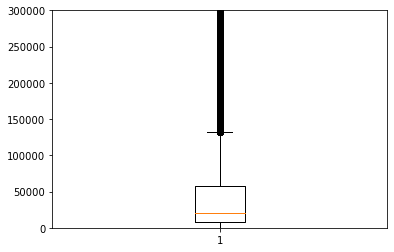

In [28]:
mp.boxplot(df_top_all[(df_top_all.rank_vol>10000)&(df_top_all.rank_vol<100000)].avg_trade_size)
mp.ylim(0,300000)

In [101]:
sum(df_top_all[(df_top_all.rank_vol<10000)].share_swaps)

0.2889991286425129

In [62]:
gini(df_top_all.total_volume)

0.9487358574263581

(0.0, 30000.0)

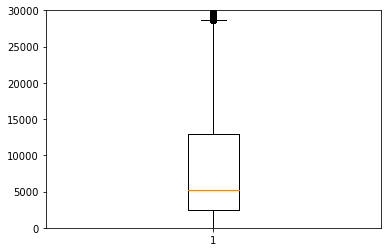

In [33]:
mp.boxplot(df_top_all[(df_top_all.rank_vol>100000)].avg_trade_size)
mp.ylim(0,30000)

## Cowswap

In [1328]:
for i in range(1,10):
    tmp = pd.read_csv('cowswap_monthly_2022-0' + str(i) + '-01.csv')
    tmp['month_date']=datetime.datetime.strptime('2022-0' + str(i) + '-01', '%Y-%m-%d').date()
    if i==1:
        df_cow_monthly=tmp
    else:
        df_cow_monthly=pd.concat([df_cow_monthly,tmp])

In [1226]:
month_list = df_cow_monthly[df_cow_monthly.trader=='\\xc6093fd9cc143f9f058938868b2df2daf9a91d28'].month_date.unique()


In [1228]:
df_cow_monthly[df_cow_monthly.trader=='\\xc6093fd9cc143f9f058938868b2df2daf9a91d28']

trader  total_swaps  swaps_30d  \
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1469        247   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1526         57   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1693         74   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1693         74   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1792        102   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1863         71   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1926         68   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1989         63   
0  \xc6093fd9cc143f9f058938868b2df2daf9a91d28         2107        118   

   swaps_90d  swaps_180d  total_volume     volume_30d    volume_90d  \
0       1343        1469  1.291984e+07  771512.149926  1.052506e+07   
0        481        1526  1.360593e+07  686082.987123  4.416687e+06   
0        227        1567  1.537149e+07  767384.045758  2.505244e+06   
0        227        1567  1.537149e+07  767384.045758  2.505244e+06   
0        270         753  1.616123e+07  792883.107173  2.570150e+06   
0        240         640  1.668738e+07  526143.935129  2.039442e+06   
0        233         457  1.699581e+07  335732.531345  1.624323e+06   
0        195         463  1.734173e+07  345916.074169  1.122544e+06   
0        241         468  1.799750e+07  655766.958158  1.298326e+06   

    volume_180d  day_first  day_last  month_date  
0  1.291984e+07        114         0  2022-01-01  
0  1.360593e+07        145         0  2022-02-01  
0  1.297671e+07        204         0  2022-03-01  
0  1.297671e+07        204         0  2022-04-01  
0  7.093338e+06        234         0  2022-05-01  
0  4.536031e+06        265         0  2022-06-01  
0  4.075972e+06        295         0  2022-07-01  
0  3.735805e+06        326         0  2022-08-01  
0  3.171389e+06        357         0  2022-09-01

In [1448]:
df_cow_monthly[df_cow_monthly.month_date==month_list[0]]

trader  total_swaps  swaps_30d  \
0      \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1469        247   
1      \xb0f4b88d29667607e88198a12e6b19700b08abf1          838         75   
2      \x933258bddd49beeca77f6d1889633c5429af45ea          728         40   
3      \x98265d92b016df8758f361fb8d2f9a813c82494a          665         44   
4      \x256bb5ad3dbdf61ae08d7cbc0b9223ccb1c60aae          539        205   
...                                           ...          ...        ...   
42052  \x8b6e81884f7dfc38e0eae0b2b7237b399a9b2a34            1          1   
42053  \x60c1a749c390d2e18ff84ebc17c74a28fac0c6c9            1          0   
42054  \x9633c4a832c8d889adea7422c7b998d7e14e5045            1          0   
42055  \xcf8816e8e525ae12459f41876e7c24d80eef1f3a            1          1   
42056  \xf1d4079c346a69ee155dc92459358ff9941c99ce            1          0   

       swaps_90d  swaps_180d  total_volume    volume_30d    volume_90d  \
0           1343        1469  1.291984e+07  7.715121e+05  1.052506e+07   
1            620         838  4.126063e+06  3.268970e+05  2.953304e+06   
2            225         728  1.500118e+08  2.092992e+07  8.529030e+07   
3            397         665  2.425330e+06  1.362699e+05  1.856138e+06   
4            537         539  6.853818e+06  2.290339e+06  6.833195e+06   
...          ...         ...           ...           ...           ...   
42052          1           1  4.949589e+02  4.949589e+02  4.949589e+02   
42053          0           1  1.948315e+02  0.000000e+00  0.000000e+00   
42054          0           1  1.419358e+02  0.000000e+00  0.000000e+00   
42055          1           1  2.504387e+02  2.504387e+02  2.504387e+02   
42056          1           1  1.478208e+03  0.000000e+00  1.478208e+03   

        volume_180d  day_first  day_last  month_date     user_grp  node  \
0      1.291984e+07        114         0  2022-01-01   repeat_90d     3   
1      4.126063e+06        139         0  2022-01-01   repeat_90d     3   
2      1.500118e+08        169         0  2022-01-01   repeat_90d     3   
3      2.425330e+06        179         1  2022-01-01   repeat_90d     3   
4      6.853818e+06         91         1  2022-01-01   repeat_90d     3   
...             ...        ...       ...         ...          ...   ...   
42052  4.949589e+02          1         1  2022-01-01   repeat_90d     3   
42053  1.948315e+02        140       140  2022-01-01  repeat_180d     2   
42054  1.419358e+02         98        98  2022-01-01  repeat_180d     2   
42055  2.504387e+02         23        23  2022-01-01   repeat_90d     3   
42056  1.478208e+03         40        40  2022-01-01   repeat_90d     3   

                node_label  
0       2021-12/repeat_90d  
1       2021-12/repeat_90d  
2       2021-12/repeat_90d  
3       2021-12/repeat_90d  
4       2021-12/repeat_90d  
...                    ...  
42052   2021-12/repeat_90d  
42053  2021-12/repeat_180d  
42054  2021-12/repeat_180d  
42055   2021-12/repeat_90d  
42056   2021-12/repeat_90d  

[42057 rows x 15 columns]

In [1611]:
get_user_grp(df_cow_monthly,df_cow_monthly.month_date.unique())


In [1661]:
df_cow_monthly['traded']=0
df_cow_monthly.loc[df_cow_monthly.volume_30d>0,'traded']=1

In [1510]:
tmp.sort_values(by = 'volume_90d', ascending=False)

trader  volume_90d
0      \x00000000000360176d958e11c140308cd0863679           1
24742  \xab6366e964f283bc2fef054951105a3f4ad0152a           1
24762  \xab7c8df6cf87d6cbaf26c5e9a8e6cf3d1799605f           1
24763  \xab804b4279a4db3fef14202a58f48356a479a399           1
24764  \xab8126bf367c1fe5234f758e393777cae572aae4           1
...                                           ...         ...
12382  \x55ef83fcbb88b4d1f70df73d316b77dd975a0576           1
12383  \x55f1aca3c42e915036c06372bdca3ea98b658ea6           1
12384  \x55f51d9f2ab5b2f0f5927b6e173ca830f6d070bd           1
12385  \x55f9402c5faee0a70aecaa1ec7f52c297147b1f1           1
37147  \xfffff449f1a35eb0facca8d4659d8e15cf2f77ba           1

[37148 rows x 2 columns]

In [1329]:
df_cow_monthly[df_cow_monthly.trader=='\\x84e5c8518c248de590d5302fd7c32d2ae6b0123c']

trader  total_swaps  swaps_30d  \
35  \x84e5c8518c248de590d5302fd7c32d2ae6b0123c          227        227   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1139        912   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1187         48   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1391        204   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1512        141   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1592         80   
1   \x84e5c8518c248de590d5302fd7c32d2ae6b0123c         1689         97   

    swaps_90d  swaps_180d  total_volume    volume_30d    volume_90d  \
35        227         227  1.438563e+06  1.438563e+06  1.438563e+06   
1        1139        1139  2.811313e+06  1.372750e+06  2.811313e+06   
1        1187        1187  3.694337e+06  8.830241e+05  3.694337e+06   
1         752        1391  4.510425e+06  8.160877e+05  2.582535e+06   
1         373        1512  4.845627e+06  3.914196e+05  2.034314e+06   
1         405        1592  5.037234e+06  1.916066e+05  1.342897e+06   
1         298        1050  5.302931e+06  2.656971e+05  7.925060e+05   

     volume_180d  day_first  day_last  month_date  
35  1.438563e+06         21         0  2022-03-01  
1   2.811313e+06         52         3  2022-04-01  
1   3.694337e+06         82         2  2022-05-01  
1   4.510425e+06        113         0  2022-06-01  
1   4.845627e+06        143         2  2022-07-01  
1   5.037234e+06        174         5  2022-08-01  
1   3.375041e+06        205         1  2022-09-01

In [1496]:
df_grp_month = df_cow_monthly.groupby(['month_date','user_grp'], dropna=False).agg(
    num_wallets = ('trader','nunique'),
    swaps_30d = ('swaps_30d','sum'),
    volume_30d = ('volume_30d','sum')
).reset_index()

In [1451]:
lst_months = df_grp_month['month_date'].unique()
df_grp_month['share_vol']=0
df_grp_month['share_swaps']=0
df_grp_month['share_wallets']=0

for m in lst_months:
    df_grp_month.loc[df_grp_month.month_date==m,'share_vol']=df_grp_month[df_grp_month.month_date==m].volume_30d/sum(df_grp_month[df_grp_month.month_date==m].volume_30d)
    df_grp_month.loc[df_grp_month.month_date==m,'share_swaps']=df_grp_month[df_grp_month.month_date==m].swaps_30d/sum(df_grp_month[df_grp_month.month_date==m].swaps_30d)
    df_grp_month.loc[df_grp_month.month_date==m,'share_wallets']=df_grp_month[df_grp_month.month_date==m].num_wallets/sum(df_grp_month[df_grp_month.month_date==m].num_wallets)

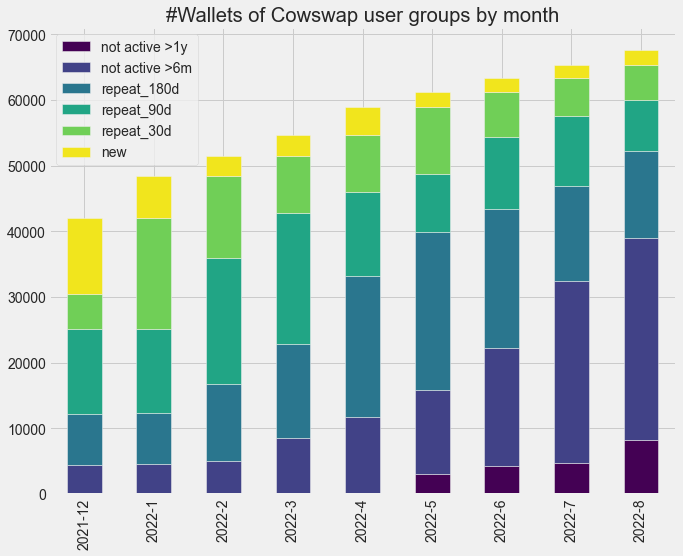

In [1497]:
fig, axs=mp.subplots()

kpi_col='num_wallets'

lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months_labels)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))), ax=axs)
mp.xticks(rotation=90)
mp.title('#Wallets of Cowswap user groups by month')
fig.savefig('charts/user_grp_num_wallets.png')


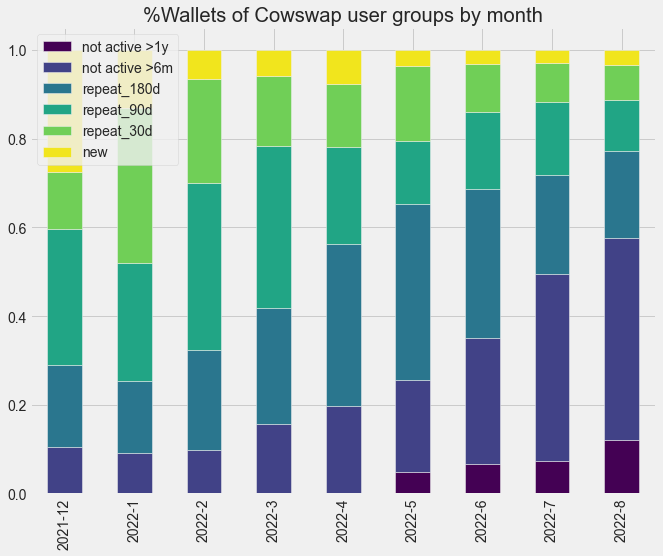

In [1469]:
fig, axs=mp.subplots()

kpi_col='share_wallets'

lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months_labels)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))), ax=axs)
mp.xticks(rotation=90)
mp.title('%Wallets of Cowswap user groups by month')
fig.savefig('charts/user_grp_share_wallets.png')


In [1454]:
kpi_col='share_vol'
lst_months = df_grp_month['month_date'].unique()
lst_months_labels=[]
lst_months_labels.append('2021-12')
for i in range(1, len(lst_months)):
    lst_months_labels.append(str(lst_months[i].year)+'-' + str(lst_months[i].month-1) )

# lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

# dct_data = {}
# for user_grp_name in lst_user_grp:
#     dct_data[user_grp_name]=[]
#     for m in lst_months:
#         if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
#             dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
#         else:
#             dct_data[user_grp_name].append(0)
    

# df=pd.DataFrame(dct_data,index=lst_months)
# df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))))
# mp.xticks(rotation=90)
# mp.title('Share of 30d volume of Cowswap user groups by month')


In [1355]:
lst_months_labels

['2021-12',
 '2022-1',
 '2022-2',
 '2022-3',
 '2022-4',
 '2022-5',
 '2022-6',
 '2022-7',
 '2022-8']

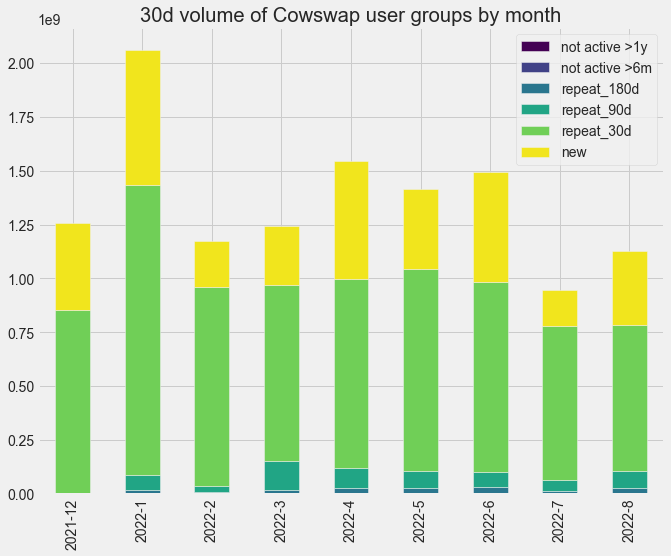

In [1516]:
fig, axs=mp.subplots()
kpi_col='volume_30d'
lst_months = df_grp_month['month_date'].unique()
lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months_labels)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))), ax=axs)
mp.xticks(rotation=90)
mp.title('30d volume of Cowswap user groups by month')
fig.savefig('charts/user_grp_volume_wallets.png')


In [1520]:
s = 0
for k in df.keys():
    s+= df[k].iloc[7]

In [1522]:
df

not active >1y  not active >6m   repeat_180d    repeat_90d  \
2021-12             0.0    0.000000e+00  0.000000e+00  0.000000e+00   
2022-1              0.0    9.749194e+05  1.664816e+07  6.982281e+07   
2022-2              0.0    3.742739e+05  9.927781e+06  2.688613e+07   
2022-3              0.0    1.841545e+06  1.657164e+07  1.329600e+08   
2022-4              0.0    3.999481e+06  2.502433e+07  8.952692e+07   
2022-5              0.0    6.569734e+06  2.208764e+07  7.755889e+07   
2022-6              0.0    2.996060e+06  2.975567e+07  6.854787e+07   
2022-7              0.0    2.389471e+06  1.292915e+07  4.878815e+07   
2022-8              0.0    5.156303e+06  2.091844e+07  8.192956e+07   

           repeat_30d           new  
2021-12  8.521409e+08  4.052651e+08  
2022-1   1.347006e+09  6.262412e+08  
2022-2   9.207964e+08  2.137278e+08  
2022-3   8.163851e+08  2.734369e+08  
2022-4   8.795537e+08  5.448071e+08  
2022-5   9.381856e+08  3.713041e+08  
2022-6   8.831559e+08  5.111165e+08  
2022-7   7.132893e+08  1.669434e+08  
2022-8   6.737050e+08  3.446015e+08

Text(0.5, 1.0, 'Share of 30d volume of Cowswap user groups by month')

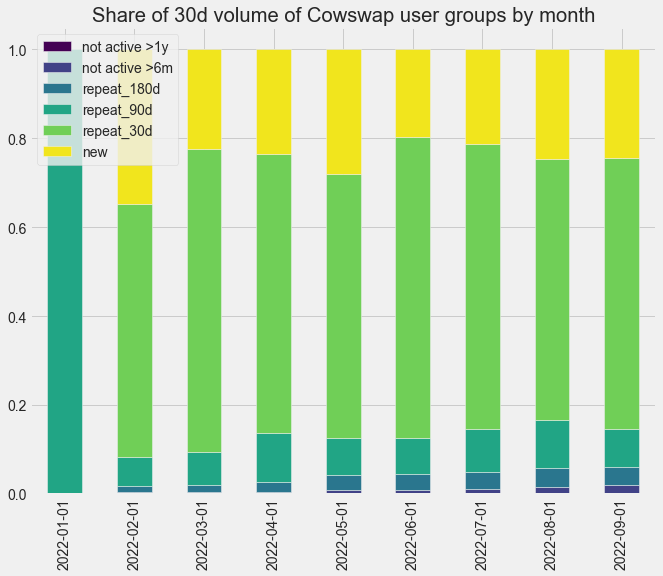

In [1367]:
kpi_col='share_swaps'
lst_months = df_grp_month['month_date'].unique()
lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))))
mp.xticks(rotation=90)
mp.title('Share of 30d volume of Cowswap user groups by month')

In [1527]:
df_cow_monthly['node']=-1
df_cow_monthly['node_label']=''

lst_node_labels=[]
lst_nodes = []
lst_colors=[]



cnt = 0

for cnt_month in range(0,len(lst_months)):
    for user_grp_name in lst_user_grp:
        df_cow_monthly.loc[(df_cow_monthly.month_date==lst_months[cnt_month]) & (df_cow_monthly.user_grp==user_grp_name),'node']=cnt
        df_cow_monthly.loc[(df_cow_monthly.month_date==lst_months[cnt_month]) & (df_cow_monthly.user_grp==user_grp_name),'node_label']=lst_months_labels[cnt_month] + '/' +  user_grp_name
        lst_node_labels.append(lst_months_labels[cnt_month] + '/' +  user_grp_name)
        lst_nodes.append(cnt)
        if user_grp_name=='new':
            lst_colors.append('yellow')
        elif user_grp_name=='repeat_30d':
            lst_colors.append('lightgreen')
        elif user_grp_name=='repeat_90d':
            lst_colors.append('darkgreen')
        elif user_grp_name=='repeat_180d':
            lst_colors.append('steelblue')
        elif user_grp_name=='not active >6m':
            lst_colors.append('mediumpurple')
        elif user_grp_name=='not active >1y':
            lst_colors.append('indigo')
        cnt+=1

                    
        

In [1512]:
ycol='volume_30d'
        
    
dct_sankey = {
    'source':[],
    'target':[],
    'num_wallets':[],
    'volume_30d':[],
    'share_vol':[],
    'swaps_30d':[]
    # 'share_wallets':[],
    # 'volume_30d':[],
    # 'share_volume_30d':[],
    # 'swaps_30d':[],
    # 'share_swaps_30d':[]
}

for num_month in range(1,len(lst_months)):
    for user_grp_name_source in lst_user_grp:
            for user_grp_name_target in lst_user_grp:
                tmp= df_cow_monthly[(df_cow_monthly.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[num_month-1]) &
                                                                            (df_cow_monthly.user_grp==user_grp_name_source)].trader.unique())) 
                                & (df_cow_monthly.month_date==lst_months[num_month])
                                & (df_cow_monthly.user_grp==user_grp_name_target)]

                if tmp.trader.nunique()>0:
                    dct_sankey['source'].append(df_cow_monthly[(df_cow_monthly.month_date==lst_months[num_month-1]) &
                                                                                (df_cow_monthly.user_grp==user_grp_name_source)].node.iloc[0])
                    dct_sankey['target'].append(df_cow_monthly[(df_cow_monthly.month_date==lst_months[num_month]) &
                                                                                (df_cow_monthly.user_grp==user_grp_name_target)].node.iloc[0])
                    dct_sankey['num_wallets'].append(tmp.trader.nunique())
                    dct_sankey['volume_30d'].append(tmp.volume_30d.sum())
                    dct_sankey['share_vol'].append(tmp.share_vol_30d.sum())
                    dct_sankey['swaps_30d'].append(tmp.swaps_30d.sum())

                    
    

In [1530]:
# df_sankey=pd.DataFrame(dct_sankey).reset_index()
# df_sankey
df_cow_monthly

trader  total_swaps  swaps_30d  \
0      \xc6093fd9cc143f9f058938868b2df2daf9a91d28         1469        247   
1      \xb0f4b88d29667607e88198a12e6b19700b08abf1          838         75   
2      \x933258bddd49beeca77f6d1889633c5429af45ea          728         40   
3      \x98265d92b016df8758f361fb8d2f9a813c82494a          665         44   
4      \x256bb5ad3dbdf61ae08d7cbc0b9223ccb1c60aae          539        205   
...                                           ...          ...        ...   
67671  \xe5832869d96ad933f5258df45a0f3d98eb1d8f60            1          0   
67672  \x7b11dba3c2fbba701d881e0e881d08d9655ab56f            1          0   
67673  \x16b4fc0f604faf1a1c8ec468a493d676cfbe891f            1          0   
67674  \x44a7278d8649064ffc505e70f64890fd456461c4            1          0   
67675  \x83f1f43ecce862c96e621eea7cc25ea55ee14ffa            1          1   

       swaps_90d  swaps_180d  total_volume    volume_30d    volume_90d  \
0           1343        1469  1.291984e+07  7.715121e+05  1.052506e+07   
1            620         838  4.126063e+06  3.268970e+05  2.953304e+06   
2            225         728  1.500118e+08  2.092992e+07  8.529030e+07   
3            397         665  2.425330e+06  1.362699e+05  1.856138e+06   
4            537         539  6.853818e+06  2.290339e+06  6.833195e+06   
...          ...         ...           ...           ...           ...   
67671          0           0  1.772477e+03  0.000000e+00  0.000000e+00   
67672          0           0  3.004906e+03  0.000000e+00  0.000000e+00   
67673          0           0  1.583484e+03  0.000000e+00  0.000000e+00   
67674          0           0  1.820867e+01  0.000000e+00  0.000000e+00   
67675          1           1  1.951788e+02  1.951788e+02  1.951788e+02   

        volume_180d  day_first  day_last  month_date        user_grp  node  \
0      1.291984e+07        114         0  2022-01-01      repeat_30d     4   
1      4.126063e+06        139         0  2022-01-01      repeat_30d     4   
2      1.500118e+08        169         0  2022-01-01      repeat_30d     4   
3      2.425330e+06        179         1  2022-01-01      repeat_30d     4   
4      6.853818e+06         91         1  2022-01-01      repeat_30d     4   
...             ...        ...       ...         ...             ...   ...   
67671  0.000000e+00        270       270  2022-09-01  not active >6m    49   
67672  0.000000e+00        204       204  2022-09-01     repeat_180d    50   
67673  0.000000e+00        209       209  2022-09-01     repeat_180d    50   
67674  0.000000e+00        271       271  2022-09-01  not active >6m    49   
67675  1.951788e+02          8         8  2022-09-01             new    53   

                  node_label  
0         2021-12/repeat_30d  
1         2021-12/repeat_30d  
2         2021-12/repeat_30d  
3         2021-12/repeat_30d  
4         2021-12/repeat_30d  
...                      ...  
67671  2022-8/not active >6m  
67672     2022-8/repeat_180d  
67673     2022-8/repeat_180d  
67674  2022-8/not active >6m  
67675             2022-8/new  

[513141 rows x 15 columns]

Help on function write_html in module plotly.basedatatypes:

write_html(self, *args, **kwargs)
    Write a figure to an HTML file representation
    
    Parameters
    ----------
    file: str or writeable
        A string representing a local file path or a writeable object
        (e.g. a pathlib.Path object or an open file descriptor)
    config: dict or None (default None)
        Plotly.js figure config options
    auto_play: bool (default=True)
        Whether to automatically start the animation sequence on page load
        if the figure contains frames. Has no effect if the figure does not
        contain frames.
    include_plotlyjs: bool or string (default True)
        Specifies how the plotly.js library is included/loaded in the output
        div string.
    
        If True, a script tag containing the plotly.js source code (~3MB)
        is included in the output.  HTML files generated with this option are
        fully self-contained and can be used offline.
    
    

In [1528]:





# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = lst_node_labels,
      color = lst_colors
    ),
    link = dict(
      source = df_sankey.source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_sankey.target,
      value = df_sankey['num_wallets']
      # label = np.repeat('',len())
      # color=lst_colors
  ))])

fig.update_layout(title_text="#Wallets of Cowswap users by group and month", font_size=10)
fig.show()

fig.write_html('wallets_sankey.html')

In [1529]:
import plotly.graph_objects as go

x=1


# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = lst_node_labels,
      color = lst_colors

    ),
    link = dict(
      source = df_sankey.source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_sankey.target,
      value = df_sankey['volume_30d'],
      label = [str(round(df_sankey['volume_30d'].iloc[i]/1000,2)) + 'k' for i in range(0, len(df_sankey))],
      
      # color = ['rgb(' + str(int(mp.cm.viridis(np.arange(x*len(lst_node_labels)))[i][0]*255))+','+ str(int(mp.cm.viridis(np.arange(x*len(lst_node_labels)))[i][1]*255))+','+ str(int(mp.cm.viridis(x*np.arange(len(lst_node_labels)))[i][2]*255)) + ',' + str(opacity) + ')' for i in range(0,len(lst_node_labels))]
  ))])

fig.update_layout(title_text="30d trading volume of Cowswap users by group and month", font_size=10)
fig.show()
fig.write_html('volume_sankey.html')

In [1491]:
num_month=2
user_grp_name_source='new'
user_grp_name_target='new'
tmp= df_cow_monthly[(df_cow_monthly.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[num_month-1]) &
                                                                            (df_cow_monthly.user_grp==user_grp_name_source)].trader.unique())) 
                                & (df_cow_monthly.month_date==lst_months[num_month])
                                & (df_cow_monthly.user_grp==user_grp_name_target)]

In [1623]:
df_cow_monthly[(df_cow_monthly.month_date==lst_months[-1])& (df_cow_monthly.trader=='\\x83f1f43ecce862c96e621eea7cc25ea55ee14ffa')]

trader  total_swaps  swaps_30d  \
67675  \x83f1f43ecce862c96e621eea7cc25ea55ee14ffa            1          1   

       swaps_90d  swaps_180d  total_volume  volume_30d  volume_90d  \
67675          1           1    195.178795  195.178795  195.178795   

       volume_180d  day_first  day_last  month_date user_grp  node  node_label  
67675   195.178795          8         8  2022-09-01      new    53  2022-8/new

In [1817]:
# dct_cohort = 
# {
#     'cohort':[]
# }

df_cohort = df_cow_users_2[['trader','day_first']].reset_index()
df_cohort['cohort'] = [(df_cohort.iloc[i].day_first-8)//30 for i in range(0,len(df_cohort))]

# for i in range(0,18):

df_cohort
    


index                                      trader  day_first  cohort
0          0  \x012144ba349d6ae5b68581b29ea4d42b1f43fdb7        239       7
1          1  \x5d2d49c7371eac3a89ca780ffe4ff32d311d9761        113       3
2          2  \x2b32547f67144dd3e359bf70043c8f0602987b11        123       3
3          3  \xa5493656b559ac046a302e8efa7c64d5ad4c9302        309      10
4          4  \xba479d5585ecec47edc2a571da430a40f43c3851         29       0
...      ...                                         ...        ...     ...
68847  68847  \x269326187b5da7a1e9d58ee347c9b1dd395e359b        148       4
68848  68848  \xf8a2c6db32b73f762d0f6abc136a20b3f4ccd004        308      10
68849  68849  \xa23b06028980a891dfe69a3ca06b65127e4b3125        320      10
68850  68850  \x2bd88192a1e33b926993816f21b87d32820777d5        294       9
68851  68851  \x57099da19e52784823c0aab1e8d8124e964c4282        315      10

[68852 rows x 4 columns]

In [1818]:
# min(df_cohort.cohort)
df_cow_monthly_cohort = df_cow_monthly.merge(df_cohort[df_cohort.cohort>=0][['trader','cohort']], how='inner', left_on='trader', right_on='trader').reset_index()


In [1819]:
df_cow_cohort = df_cow_monthly_cohort.groupby(['cohort','month_date']).agg(num_wallets=('traded','sum'),
volume_30d = ('volume_30d','sum'),
swaps_30d = ('swaps_30d','sum')
).reset_index()

In [1820]:
df_cow_cohort_all = df_cow_monthly_cohort.groupby(['cohort']).agg(num_wallets=('trader','nunique')
).reset_index()
df_cow_cohort_all

cohort  num_wallets
0        0         2168
1        1         1950
2        2         2094
3        3         2109
4        4         4126
5        5         3308
6        6         3192
7        7         5162
8        8        11832
9        9         8952
10      10         5999
11      11         4441
12      12         4832
13      13         1080
14      14          926
15      15         1927
16      16         3568
17      17           10

In [1821]:
val_col = 'num_wallets'
cohort_pivot = df_cow_cohort[['cohort','month_date',val_col]].pivot_table(index = 'cohort',
                                     columns = 'month_date',
                                     values = val_col)

In [1825]:
#if totals are columns
# cohort_size = [np.nansum(cohort_pivot.iloc[:,i]) for i in range(0, len(cohort_pivot.keys()))]
# retention_matrix = cohort_pivot.divide(cohort_size, axis = 1) #change to 0 for users

#if totals are rows

# cohort_size = cohort_pivot.iloc[:,0].fillna(0)

cohort_size=df_cow_cohort_all.iloc[:,1]
cohort_size[:9] = [cohort_pivot.iloc[i,8-i] for i in range(0,9)]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) 
# cohort_size = cohort_pivot.iloc[:,-1].fillna(0)


In [1824]:
cohort_pivot

month_date  2022-01-01  2022-02-01  2022-03-01  2022-04-01  2022-05-01  \
cohort                                                                   
0                  NaN         NaN         NaN         NaN         NaN   
1                  NaN         NaN         NaN         NaN         NaN   
2                  NaN         NaN         NaN         NaN         NaN   
3                  NaN         NaN         NaN         NaN         NaN   
4                  NaN         NaN         NaN         NaN      3808.0   
5                  NaN         NaN         NaN      2770.0      1544.0   
6                  NaN         NaN      2718.0      1153.0       624.0   
7                  NaN      4884.0      1521.0       848.0       735.0   
8              10418.0      3347.0      1212.0       954.0       872.0   
9               3232.0      1667.0      1099.0       994.0       913.0   
10              1244.0       944.0       745.0       699.0       630.0   
11               627.0       495.0       399.0       389.0       347.0   
12               694.0       522.0       405.0       371.0       373.0   
13               210.0       166.0       137.0       127.0       108.0   
14               105.0        80.0        72.0        70.0        73.0   
15               220.0       175.0       144.0       128.0       125.0   
16               342.0       226.0       204.0       190.0       202.0   
17                 3.0         2.0         2.0         1.0         1.0   

month_date  2022-06-01  2022-07-01  2022-08-01  2022-09-01  
cohort                                                      
0                  NaN         NaN         NaN      2188.0  
1                  NaN         NaN      1775.0       620.0  
2                  NaN      1875.0       595.0       348.0  
3               1962.0       561.0       258.0       249.0  
4               1046.0       457.0       338.0       335.0  
5                553.0       363.0       291.0       308.0  
6                465.0       284.0       244.0       230.0  
7                484.0       340.0       309.0       267.0  
8                594.0       428.0       369.0       348.0  
9                618.0       461.0       367.0       372.0  
10               396.0       285.0       252.0       230.0  
11               237.0       193.0       148.0       134.0  
12               250.0       213.0       183.0       191.0  
13                88.0        77.0        62.0        65.0  
14                49.0        40.0        38.0        37.0  
15                90.0        69.0        67.0        60.0  
16               128.0        98.0        81.0        87.0  
17                 1.0         1.0         0.0         0.0

In [1732]:
retention_matrix

month_date  2022-01-01  2022-02-01  2022-03-01  2022-04-01  2022-05-01  \
cohort                                                                   
0                  NaN         NaN         NaN         NaN         NaN   
1                  NaN         NaN         NaN         NaN         NaN   
2                  NaN         NaN         NaN         NaN         NaN   
3                  NaN         NaN         NaN         NaN         NaN   
4                  NaN         NaN         NaN         NaN    1.000000   
5                  NaN         NaN         NaN    1.000000    0.489910   
6                  NaN         NaN    1.000000    0.370751    0.219193   
7                  NaN    1.000000    0.276225    0.163285    0.140505   
8                  1.0    0.278228    0.107879    0.085221    0.078695   
9                  1.0    0.568221    0.381347    0.346459    0.318135   
10                 1.0    0.770076    0.603550    0.567202    0.501268   
11                 1.0    0.782683    0.629881    0.619694    0.550085   
12                 1.0    0.746009    0.584906    0.535559    0.544267   
13                 1.0    0.804124    0.670103    0.618557    0.520619   
14                 1.0    0.778846    0.673077    0.682692    0.701923   
15                 1.0    0.799107    0.660714    0.584821    0.562500   
16                 1.0    0.655589    0.592145    0.549849    0.589124   
17                 1.0    0.500000    0.500000    0.500000    0.000000   

month_date  2022-06-01  2022-07-01  2022-08-01  2022-09-01  
cohort                                                      
0                  NaN         NaN         NaN    1.000000  
1                  NaN         NaN    1.000000    0.282245  
2                  NaN    1.000000    0.263679    0.177176  
3             1.000000    0.258159    0.127618    0.122260  
4             0.242092    0.111224    0.084439    0.084439  
5             0.192415    0.125261    0.100905    0.107516  
6             0.158286    0.099150    0.083924    0.079674  
7             0.095521    0.064701    0.060299    0.052259  
8             0.052960    0.038415    0.032541    0.030956  
9             0.216580    0.159931    0.129534    0.128152  
10            0.321217    0.234150    0.204565    0.188504  
11            0.385399    0.310696    0.237691    0.222411  
12            0.361393    0.307692    0.265602    0.271408  
13            0.422680    0.386598    0.304124    0.335052  
14            0.471154    0.384615    0.346154    0.365385  
15            0.415179    0.316964    0.308036    0.267857  
16            0.368580    0.287009    0.229607    0.250755  
17            0.000000    0.000000    0.000000    0.000000

In [1802]:
retention_matrix

2022-01-01  2022-02-01  2022-03-01  2022-04-01  2022-05-01  \
cohort                                                               
0              NaN         NaN         NaN         NaN         NaN   
1              NaN         NaN         NaN         NaN         NaN   
2              NaN         NaN         NaN         NaN         NaN   
3              NaN         NaN         NaN         NaN         NaN   
4              NaN         NaN         NaN         NaN         NaN   
5              NaN         NaN         NaN         NaN         NaN   
6              NaN         NaN         NaN         NaN         NaN   
7              NaN         NaN         NaN         NaN         NaN   
8              NaN         NaN         NaN         NaN         NaN   
9              NaN         NaN         NaN         NaN         NaN   
10             NaN         NaN         NaN         NaN         NaN   
11             NaN         NaN         NaN         NaN         NaN   
12             NaN         NaN         NaN         NaN         NaN   
13             NaN         NaN         NaN         NaN         NaN   
14             NaN         NaN         NaN         NaN         NaN   
15             NaN         NaN         NaN         NaN         NaN   
16             NaN         NaN         NaN         NaN         NaN   
17             NaN         NaN         NaN         NaN         NaN   

        2022-06-01  2022-07-01  2022-08-01  2022-09-01  cohort  num_wallets  
cohort                                                                       
0              NaN         NaN         NaN         NaN     NaN          NaN  
1              NaN         NaN         NaN         NaN     NaN          NaN  
2              NaN         NaN         NaN         NaN     NaN          NaN  
3              NaN         NaN         NaN         NaN     NaN          NaN  
4              NaN         NaN         NaN         NaN     NaN          NaN  
5              NaN         NaN         NaN         NaN     NaN          NaN  
6              NaN         NaN         NaN         NaN     NaN          NaN  
7              NaN         NaN         NaN         NaN     NaN          NaN  
8              NaN         NaN         NaN         NaN     NaN          NaN  
9              NaN         NaN         NaN         NaN     NaN          NaN  
10             NaN         NaN         NaN         NaN     NaN          NaN  
11             NaN         NaN         NaN         NaN     NaN          NaN  
12             NaN         NaN         NaN         NaN     NaN          NaN  
13             NaN         NaN         NaN         NaN     NaN          NaN  
14             NaN         NaN         NaN         NaN     NaN          NaN  
15             NaN         NaN         NaN         NaN     NaN          NaN  
16             NaN         NaN         NaN         NaN     NaN          NaN  
17             NaN         NaN         NaN         NaN     NaN          NaN

In [1655]:
sum(df_cow_monthly[df_cow_monthly.month_date==lst_months[0]].volume_30d)/1000000

1257.4059720011994

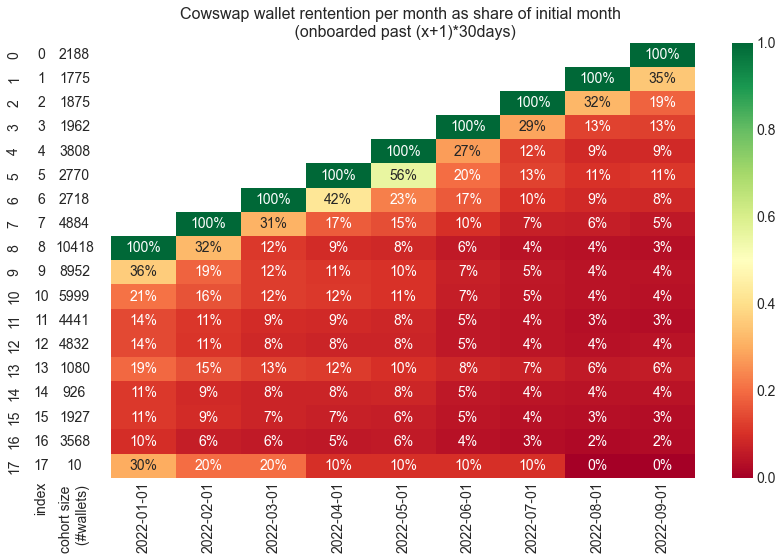

In [1940]:
import matplotlib.colors as mcolors
with sns.axes_style("white"):
    fig, ax = mp.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1],yticklabels=False)
    ax[1].set_title('Cowswap wallet rentention per month as share of initial month \n (onboarded past (x+1)*30days)', fontsize=16)
    ax[1].set(xlabel='',
              ylabel='')

    
    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).reset_index()
    cohort_size_df=cohort_size_df.rename(columns={cohort_size_df.columns[1]: 'cohort size \n (#wallets)'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    # ax[0].set(xlabel='cohort size')
    

    fig.tight_layout()

In [1925]:
df_retention_matrix=pd.DataFrame(retention_matrix).reset_index()
df_retention_matrix
retention_matrix_nulled = [list(df_retention_matrix.iloc[i,9-i:])  for i in range(0,9)]

In [1922]:
df_retention_matrix
# retention_matrix_nulled[8]

month_date  cohort  2022-01-01  2022-02-01  2022-03-01  2022-04-01  \
0                0         NaN         NaN         NaN         NaN   
1                1         NaN         NaN         NaN         NaN   
2                2         NaN         NaN         NaN         NaN   
3                3         NaN         NaN         NaN         NaN   
4                4         NaN         NaN         NaN         NaN   
5                5         NaN         NaN         NaN    1.000000   
6                6         NaN         NaN    1.000000    0.424209   
7                7         NaN    1.000000    0.311425    0.173628   
8                8    1.000000    0.321271    0.116337    0.091572   
9                9    0.361037    0.186215    0.122766    0.111037   
10              10    0.207368    0.157360    0.124187    0.116519   
11              11    0.141184    0.111461    0.089845    0.087593   
12              12    0.143626    0.108030    0.083816    0.076780   
13              13    0.194444    0.153704    0.126852    0.117593   
14              14    0.113391    0.086393    0.077754    0.075594   
15              15    0.114167    0.090815    0.074728    0.066424   
16              16    0.095852    0.063341    0.057175    0.053251   
17              17    0.300000    0.200000    0.200000    0.100000   

month_date  2022-05-01  2022-06-01  2022-07-01  2022-08-01  2022-09-01  
0                  NaN         NaN         NaN         NaN    1.000000  
1                  NaN         NaN         NaN    1.000000    0.349296  
2                  NaN         NaN    1.000000    0.317333    0.185600  
3                  NaN    1.000000    0.285933    0.131498    0.126911  
4             1.000000    0.274685    0.120011    0.088761    0.087973  
5             0.557401    0.199639    0.131047    0.105054    0.111191  
6             0.229581    0.171082    0.104489    0.089772    0.084621  
7             0.150491    0.099099    0.069615    0.063268    0.054668  
8             0.083701    0.057017    0.041083    0.035419    0.033404  
9             0.101988    0.069035    0.051497    0.040996    0.041555  
10            0.105018    0.066011    0.047508    0.042007    0.038340  
11            0.078136    0.053366    0.043459    0.033326    0.030173  
12            0.077194    0.051738    0.044081    0.037873    0.039528  
13            0.100000    0.081481    0.071296    0.057407    0.060185  
14            0.078834    0.052916    0.043197    0.041037    0.039957  
15            0.064868    0.046705    0.035807    0.034769    0.031136  
16            0.056614    0.035874    0.027466    0.022702    0.024383  
17            0.100000    0.100000    0.100000    0.000000    0.000000

In [1926]:
dct_retention={}

for i in range(0,8):
    for j in range(0,8-i):
        retention_matrix_nulled[i].append(np.nan)
    dct_retention[i]=retention_matrix_nulled[i]    

for i in range(8,18):
    dct_retention[i]=df_retention_matrix.iloc[i,1:]
# i=2
# [df_retention_matrix.iloc[9-i:,i]].extend(np.repeat(np.nan(),3))

df_retention_matrix_nulled = pd.DataFrame(dct_retention).reset_index()
df_retention_matrix_nulled

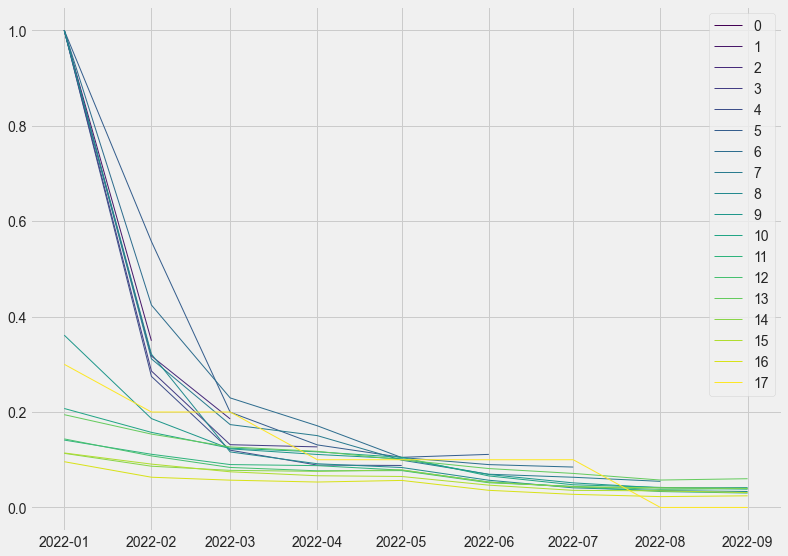

In [2260]:
mp.subplots(figsize=(12,9))
num_lines = len(df_retention_matrix_nulled.iloc[:,1:].keys())
colors = mp.cm.viridis(np.linspace(0,1,num_lines))
for i in range(0,num_lines):
    mp.plot(df_retention_matrix_nulled.month_date, df_retention_matrix_nulled.iloc[:,i+1], linewidth=1, color=colors[i], label=str(i))

mp.legend()

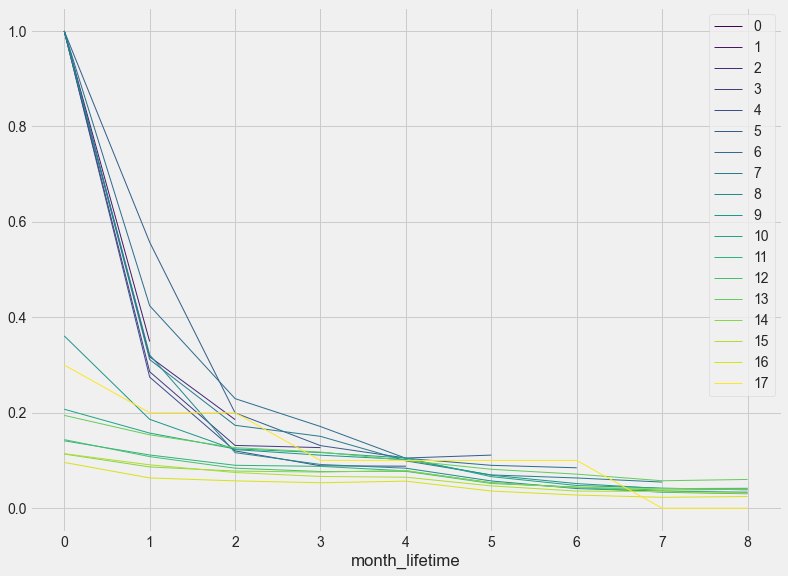

In [2263]:
mp.subplots(figsize=(12,9))
num_lines = len(df_retention_matrix_nulled.iloc[:,1:].keys())
colors = mp.cm.viridis(np.linspace(0,1,num_lines))
for i in range(0,num_lines):
    mp.plot(range(0,9), df_retention_matrix_nulled.iloc[:,i+1], linewidth=1, color=colors[i], label=str(i))
        # df_retention_matrix_nulled.month_date
mp.xlabel('month_lifetime')
mp.legend()

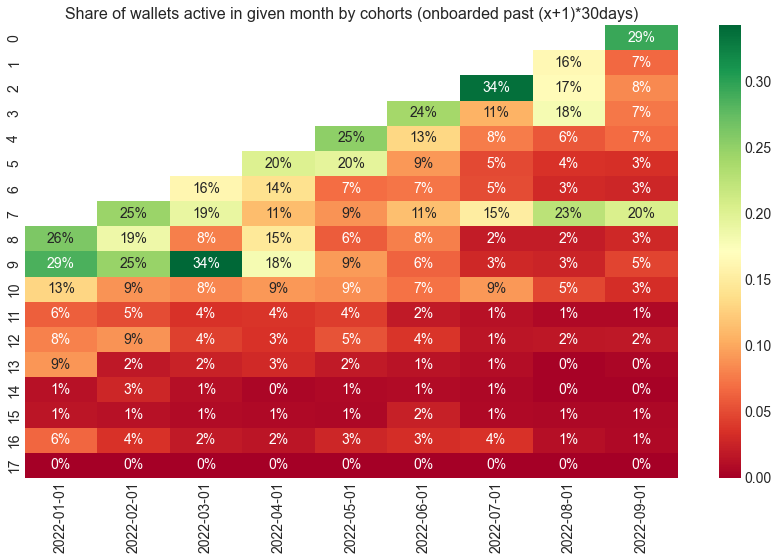

In [1941]:
val_col = 'volume_30d'
cohort_pivot = df_cow_cohort[['cohort','month_date',val_col]].pivot_table(index = 'cohort',
                                     columns = 'month_date',
                                     values = val_col)
#if totals are columns
cohort_size = [np.nansum(cohort_pivot.iloc[:,i]) for i in range(0, len(cohort_pivot.keys()))]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 1) #change to 0 for users





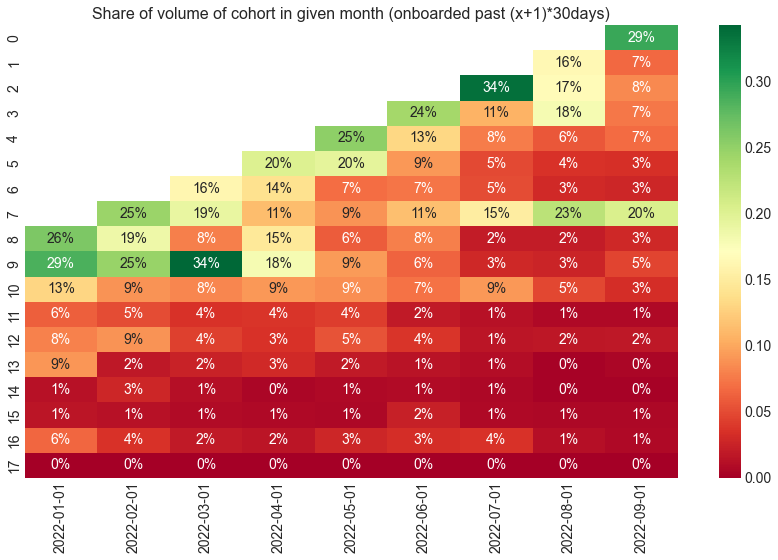

In [1943]:
import matplotlib.colors as mcolors
with sns.axes_style("white"):
    fig, axs = mp.subplots(figsize=(12, 8))
    # , gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=axs)
    axs.set_title('Share of volume of cohort in given month (onboarded past (x+1)*30days)', fontsize=16)
    axs.set(xlabel='',
              ylabel='')

    # # cohort size
    # cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    # white_cmap = mcolors.ListedColormap(['white'])
    # sns.heatmap(cohort_size_df, 
    #             annot=True, 
    #             cbar=False, 
    #             fmt='g', 
    #             cmap=white_cmap, 
    #             ax=ax[0])
    # # ax[0].set(xlabel='#wallets live')

    fig.tight_layout()

In [1765]:
tmp =pd.DataFrame(cohort_size).reset_index()
tmp=tmp.drop(tmp.columns[0])
tmp.rename(columns={tmp.columns[0]: 'cohort_size'})

KeyError: "['cohort'] not found in axis"

In [1531]:
#gnosis traders
df_cow_gnosis = pd.read_csv('cowswap_traders_gnosis.csv')

In [1558]:
len(df_cow_gnosis[df_cow_gnosis.total_volume <100])

23610

In [2026]:
df_cow_monthly[df_cow_monthly.month_date==lst_months[-1]].user_grp

0            repeat_30d
1            repeat_30d
2            repeat_30d
3            repeat_90d
4        not active >6m
              ...      
67671    not active >6m
67672       repeat_180d
67673       repeat_180d
67674    not active >6m
67675               new
Name: user_grp, Length: 67676, dtype: object

In [2027]:
df_cow_referrals

NameError: name 'df_cow_referrals' is not defined

In [2166]:
# df_cow_users.to_pickle('df_cow_users_userid_0910.pkl')
df_cow_users = pd.read_pickle('df_cow_users_userid_0910.pkl')
# df_cow_referrals = pd.read_csv('cowswap_referrals.csv')
# df_cow_users = pd.read_csv('cowswap_trader_data_09102022.csv')
# df_cow_users  = df_cow_users.rename(columns={'num_fill':'total_swaps'}).sort_values(by='volume_90d', ascending=False)

In [2049]:
df_cow_referrals.keys()
df_cow_referrals['referrer_unclean']=[df_cow_referrals.iloc[i].referrer.replace('0x','\\x') for i in range(0, len(df_cow_referrals))]

In [2050]:
df_check_refs = df_cow_referrals.merge(df_cow_users_2[['trader','user_id']], how='left',left_on='referrer_unclean',right_on='trader').reset_index().merge(df_cow_users_2[['trader','user_id']], how='left',left_on='owner',right_on='trader')

In [2052]:
df_check_refs[df_check_refs.user_id_x==df_check_refs.user_id_y].owner

index                                    referrer  \
5         5  0xaed6ad5e903bdb7eae4a93445a539926003efef0   
100     100  0x8fd05381267eef20d82536e93848e8a7801aacf8   
145     145  0x7f434cd5fa5b6e145b3ef25703ae7dcf775e119c   
189     189  0xacba954a83dea5d5ae37afad29bc7c76ca24dd98   
251     251  0x9209d23ec84202dd616324addf58faa36f7830c9   
...     ...                                         ...   
6057   6030  0x3099e12ca83c51e9b82ea6c5a08723aed4912068   
6058   6031  0x3099e12ca83c51e9b82ea6c5a08723aed4912068   
6065   6038  0xd13f03272d9584466e06bcd94a9da996fe592c40   
6098   6071  0x895c5aa8f7abd95f5b152bb5c7f2052972013fa1   
6099   6071  0x895c5aa8f7abd95f5b152bb5c7f2052972013fa1   

                                           owner  \
5     \x00551b73fd95c6d01db4ec1b158a6e7b27bdc045   
100   \x04958d6317f1b38daaeffbb8ea00efed95c5d317   
145   \x065c2a4748b40121951c5887c0a17527c848da27   
189   \x07f0acb8a5690faeb851a0e252d1d6b15e2a2f71   
251   \x0a9aaf37f167ce6a3bc1bc62ab785307b2064ec9   
...                                          ...   
6057  \xf9c840804d361d8fbe9968c14da1e6433fc27139   
6058  \xf9c840804d361d8fbe9968c14da1e6433fc27139   
6065  \xfa35b9ff1b5f81cde47fbe08aef4630613c314a1   
6098  \xfbb568d90e086ce72be45894804c1aa2537e1176   
6099  \xfbb568d90e086ce72be45894804c1aa2537e1176   

                                referrer_unclean  \
5     \xaed6ad5e903bdb7eae4a93445a539926003efef0   
100   \x8fd05381267eef20d82536e93848e8a7801aacf8   
145   \x7f434cd5fa5b6e145b3ef25703ae7dcf775e119c   
189   \xacba954a83dea5d5ae37afad29bc7c76ca24dd98   
251   \x9209d23ec84202dd616324addf58faa36f7830c9   
...                                          ...   
6057  \x3099e12ca83c51e9b82ea6c5a08723aed4912068   
6058  \x3099e12ca83c51e9b82ea6c5a08723aed4912068   
6065  \xd13f03272d9584466e06bcd94a9da996fe592c40   
6098  \x895c5aa8f7abd95f5b152bb5c7f2052972013fa1   
6099  \x895c5aa8f7abd95f5b152bb5c7f2052972013fa1   

                                        trader_x  user_id_x  \
5     \xaed6ad5e903bdb7eae4a93445a539926003efef0     1520.0   
100   \x8fd05381267eef20d82536e93848e8a7801aacf8    54778.0   
145   \x7f434cd5fa5b6e145b3ef25703ae7dcf775e119c    55452.0   
189   \xacba954a83dea5d5ae37afad29bc7c76ca24dd98     8809.0   
251   \x9209d23ec84202dd616324addf58faa36f7830c9     1623.0   
...                                          ...        ...   
6057  \x3099e12ca83c51e9b82ea6c5a08723aed4912068     2993.0   
6058  \x3099e12ca83c51e9b82ea6c5a08723aed4912068     2993.0   
6065  \xd13f03272d9584466e06bcd94a9da996fe592c40     3194.0   
6098  \x895c5aa8f7abd95f5b152bb5c7f2052972013fa1    29539.0   
6099  \x895c5aa8f7abd95f5b152bb5c7f2052972013fa1    29539.0   

                                        trader_y  user_id_y  
5     \x00551b73fd95c6d01db4ec1b158a6e7b27bdc045     1520.0  
100   \x04958d6317f1b38daaeffbb8ea00efed95c5d317    54778.0  
145   \x065c2a4748b40121951c5887c0a17527c848da27    55452.0  
189   \x07f0acb8a5690faeb851a0e252d1d6b15e2a2f71     8809.0  
251   \x0a9aaf37f167ce6a3bc1bc62ab785307b2064ec9     1623.0  
...                                          ...        ...  
6057  \xf9c840804d361d8fbe9968c14da1e6433fc27139     2993.0  
6058  \xf9c840804d361d8fbe9968c14da1e6433fc27139     2993.0  
6065  \xfa35b9ff1b5f81cde47fbe08aef4630613c314a1     3194.0  
6098  \xfbb568d90e086ce72be45894804c1aa2537e1176    29539.0  
6099  \xfbb568d90e086ce72be45894804c1aa2537e1176    29539.0  

[144 rows x 8 columns]

In [2257]:

sum(df_cow_users_2[df_cow_users_2.user_id.isin(df_check_refs[df_check_refs.user_id_x==df_check_refs.user_id_y].user_id_y.unique())].share_vol_90d)

0.0021670448994043174

In [1069]:
df_cow_users['volume_180d']=df_cow_users['volume_180d']-df_cow_users['volume_90d']
df_cow_users['swaps_180d']=df_cow_users['swaps_180d']-df_cow_users['swaps_90d']
add_cols(df_cow_users, bound_1 = int(len(df_cow_users)*10000/5500000), bound_2 = int(len(df_cow_users)*100000/5500000), time_ranges=[90,180])

In [1070]:
df_cow_users['days_active'] = df_cow_users.day_first-df_cow_users.day_last
df_cow_users['status']='inactive'
df_cow_users.loc[df_cow_users.day_last<=180,'status']='active'

In [767]:
# df_cow_top = df_cow_users.merge(df_top_all, how='inner', left_on='trader', right_on='user')
df_cow_users.keys()

Index(['trader', 'total_swaps', 'swaps_90d', 'swaps_180d', 'total_volume',
       'volume_90d', 'volume_180d', 'day_first', 'day_last', 'volume_per_day',
       'avg_num_trades', 'num_batches', 'avg_volume', 'sum_volume',
       'avg_dex_swaps', 'sum_fees', 'avg_fees', 'sum_cost', 'avg_cost',
       'cost_coverage', 'avg_num_trades_90d', 'num_batches_90d',
       'avg_volume_90d', 'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d',
       'avg_fees_90d', 'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d',
       'avg_num_trades_180d', 'num_batches_180d', 'avg_volume_180d',
       'sum_volume_180d', 'avg_dex_swaps_180d', 'sum_fees_180d',
       'avg_fees_180d', 'sum_cost_180d', 'avg_cost_180d', 'cost_coverage_180d',
       'share_vol_90d', 'share_swaps_90d', 'rank_vol_90d', 'rank_swaps_90d',
       'avg_trade_size_90d', 'share_vol_180d', 'share_swaps_180d',
       'rank_vol_180d', 'rank_swaps_180d', 'avg_trade_size_180d', 'share_vol',
       'share_swaps', 'cs_share_vol', 'cs_share_

In [1541]:
df_holders_cow = pd.read_csv('holders_cow.csv')
df_holders_vcow = pd.read_csv('holders_vcow.csv')

In [1543]:
df_holders = pd.concat([df_holders_cow,df_holders_vcow]).groupby('trader').agg({'balance':'sum'}).reset_index()

In [1566]:
df_holders['trader']=[df_holders.trader.iloc[i].replace('0x','\\x') for i in range(0, len(df_holders))]

In [2269]:
df_holders

trader       balance
0     \x0000000000007f150bd6f54c40a34d7c3d5e9f56  2.298240e-13
1     \x000000000035b5e5ad9019092c665357240f594e  8.000000e-17
2     \x00000000003b3cc22af3ae1eac0440bcee416b40  1.674761e-02
3     \x000000000088e0120f9e6652cc058aec07564f69  1.851684e-01
4     \x00000000008c4fb1c916e0c88fd4cc402d935e7d  4.000000e-18
...                                          ...           ...
1733  \xff2c13a2d71a4d3b70f4086dc17b4aa6c075efde  3.098361e+04
1734  \xff42593bfe84580dc1406d3d7dd8b51952cbafa7  7.666530e+03
1735  \xffb6d97bd1e7b7bd08595096d15037401a1f416b  2.224000e+03
1736  \xffc4dff32984b555fb353847e6c2063f4de9da18  2.000000e-18
1737  \xffecc003640cf5f1bce4e3456f8e4e2130d0be83  1.568235e+02

[1738 rows x 2 columns]

# cow user 2

In [2367]:
df_cow_users_2 = df_cow_users.merge(df_cow_all, how='left', left_on='trader', right_on='trader').rename(
    columns={'total_volume_x':'total_volume',
    'rank_vol_x':'rank_vol'}
)
df_cow_users_2['cost_coverage']=df_cow_users_2['avg_fees']/df_cow_users_2['avg_cost']
df_cow_users_2['cost_coverage_90d']=df_cow_users_2['avg_fees_90d']/df_cow_users_2['avg_cost_90d']
df_cow_users_2['cost_coverage_180d']=df_cow_users_2['avg_fees_180d']/df_cow_users_2['avg_cost_180d']

In [2368]:
df_cow_users_2['active_gnosis']=0
df_cow_users_2.loc[df_cow_users_2.trader.isin(df_cow_gnosis[df_cow_gnosis.volume_180d>0].trader.unique()) ,'active_gnosis']=1

df_cow_users_2 = df_cow_users_2.merge(df_holders[['trader','balance']], how='left',left_on='trader',right_on='trader')
df_cow_users_2=df_cow_users_2.rename(columns={'balance':'cow_balance'})

In [2271]:
df_cow_users_2.keys()

Index(['index', 'trader', 'total_swaps', 'swaps_90d', 'swaps_180d',
       'total_volume', 'volume_90d', 'volume_180d', 'day_first', 'day_last',
       'volume_per_day', 'avg_num_trades', 'num_batches', 'avg_volume',
       'sum_volume', 'avg_dex_swaps', 'sum_fees', 'avg_fees', 'sum_cost',
       'avg_cost', 'cost_coverage', 'avg_num_trades_90d', 'num_batches_90d',
       'avg_volume_90d', 'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d',
       'avg_fees_90d', 'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d',
       'avg_num_trades_180d', 'num_batches_180d', 'avg_volume_180d',
       'sum_volume_180d', 'avg_dex_swaps_180d', 'sum_fees_180d',
       'avg_fees_180d', 'sum_cost_180d', 'avg_cost_180d', 'cost_coverage_180d',
       'share_vol_90d', 'share_swaps_90d', 'rank_vol_90d', 'rank_swaps_90d',
       'avg_trade_size_90d', 'share_vol_180d', 'share_swaps_180d',
       'rank_vol_180d', 'rank_swaps_180d', 'avg_trade_size_180d', 'share_vol',
       'share_swaps', 'cs_share_vol', '

In [2369]:
df_cow_users_2['avg_swap_size_90d']=0
df_cow_users_2.loc[df_cow_users_2.swaps_90d>0,'avg_swap_size_90d'] = df_cow_users_2[df_cow_users_2.swaps_90d>0].volume_90d/df_cow_users_2[df_cow_users_2.swaps_90d>0].swaps_90d
df_cow_users_2['avg_swap_size_180d']=0
df_cow_users_2.loc[df_cow_users_2.swaps_180d>0,'avg_swap_size_total'] = df_cow_users_2[df_cow_users_2.swaps_180d>0].volume_180d/df_cow_users_2[df_cow_users_2.swaps_180d>0].swaps_180d
df_cow_users_2['avg_swap_size_total']=0
df_cow_users_2.loc[df_cow_users_2.total_swaps>0,'avg_swap_size_total'] = df_cow_users_2[df_cow_users_2.total_swaps>0].total_volume/df_cow_users_2[df_cow_users_2.total_swaps>0].total_swaps

In [2451]:
df_safes =pd.read_csv('cowswap_safes.csv')
df_safes['is_safe']=1

In [2452]:
df_cow_users_2=df_cow_users_2.merge(df_safes[['address','is_safe']], how='left', left_on='trader', right_on='address')

In [2371]:
df_cow_users_2 = df_cow_users_2.merge(df_cow_monthly[(df_cow_monthly.month_date==lst_months[-1])][['trader','user_grp']],how='left',left_on='trader',right_on='trader').reset_index()



In [2372]:
df_cow_users_2.loc[df_cow_users_2.user_grp.isna(),'user_grp']='not active >1y'

In [2462]:
df_cow_users_2[(df_cow_users_2.is_safe==1)&(df_cow_users_2.rank_vol_90d<255)].sort_values(by='rank_vol_90d')

index                                      trader  total_swaps  \
29      29  \x849d52316331967b6ff1198e5e32a0eb168d039d           51   
31      31  \x245cc372c84b3645bf0ffe6538620b04a217988b            3   
33      33  \x5c8898f8e0f9468d4a677887bc03ee2659321012            3   
37      37  \xdafca7a5e3b67b8f36c1fdd7691ed85bbb54cc18           32   
52      52  \x0d5dc686d0a2abbfdafdfb4d0533e886517d4e83           56   
53      53  \x013ea9319e98713f25a387c2ca66d625b57495d6            1   
87      87  \xb577cc8aa76d3607067934fd6477f0a392194a83           27   
105    105  \xaa7d83dc5c2b32f9e4201f846fe5ba0852662581            3   
110    110  \xb43f63767e49c839d46adbf6c6a5662a7f36be18            4   
114    114  \x7fbe0de6ffa86f4b9528aa27029595429b0c74a9            2   
115    115  \xed2aadada6e6baf17ec4ac3a0602459b87865243            2   
127    127  \x4971dd016127f390a3ef6b956ff944d0e2e1e462           57   
129    129  \x813f10aba9624d2f4b3130a1ecd26da2bb2d09d4            4   
150    150  \x9467dcfd4519287e3878c018c02f5670465a9003            4   
154    154  \xebc7c1ef872c6e96ed2b6e7076731e7804401c03            3   
172    172  \x7d2ab9ca511ebd6f03971fb417d3492aa82513f0          271   
252    252  \x49d56a8f4f79a639d50e622ba3c83e6297b51be5            8   

     swaps_90d  swaps_180d  total_volume    volume_90d   volume_180d  \
29          17          21  5.473173e+07  1.771069e+07  2.116318e+07   
31           3           0  1.741894e+07  1.741894e+07  0.000000e+00   
33           3           0  1.484583e+07  1.484583e+07  0.000000e+00   
37          30           2  1.498775e+07  1.396579e+07  1.021958e+06   
52          16          23  6.504327e+07  1.007140e+07  4.312828e+07   
53           1           0  1.000090e+07  1.000090e+07  0.000000e+00   
87          26           1  6.010458e+06  5.489328e+06  5.211301e+05   
105          1           2  9.864538e+06  4.539412e+06  5.325126e+06   
110          4           0  4.407521e+06  4.407521e+06  0.000000e+00   
114          2           0  4.353337e+06  4.353337e+06  0.000000e+00   
115          2           0  4.234461e+06  4.234461e+06  0.000000e+00   
127          7          20  3.148671e+07  3.666870e+06  6.683956e+06   
129          1           3  1.272257e+07  3.610058e+06  9.112512e+06   
150          4           0  2.912861e+06  2.912861e+06  0.000000e+00   
154          3           0  2.760460e+06  2.760460e+06  0.000000e+00   
172         61         114  4.719140e+07  2.391794e+06  1.742014e+07   
252          1           7  3.879490e+06  1.563620e+06  2.315870e+06   

     day_first  day_last  volume_per_day  avg_num_trades  num_batches  \
29         231        36    2.806756e+05        1.627451         51.0   
31          66        66    0.000000e+00        1.333333          3.0   
33           9         0    1.649537e+06        1.333333          3.0   
37          97         8    1.684017e+05        1.354839         31.0   
52         264         2    2.482568e+05        1.958333         48.0   
53           0         0    0.000000e+00        3.000000          1.0   
87          97         3    6.394104e+04        1.941176         17.0   
105        159        88    1.389372e+05        1.333333          3.0   
110         72        45    1.632415e+05        1.000000          4.0   
114         31        31    0.000000e+00        1.000000          2.0   
115         67        53    3.024615e+05        2.000000          2.0   
127        283        22    1.206388e+05        1.821429         56.0   
129        102        90    1.060214e+06        1.250000          4.0   
150         67        32    8.322460e+04        1.500000          4.0   
154         82        35    5.873320e+04        1.666667          3.0   
172        301         2    1.578308e+05        1.761134        247.0   
252        122        85    1.048511e+05        1.500000          8.0   

       avg_volume    sum_volume  avg_dex_swaps      sum_fees    avg_fees  \
29   1.093986e+06  5.579328e+07       

In [2460]:
df_cow_users_2.keys()

Index(['index', 'trader', 'total_swaps', 'swaps_90d', 'swaps_180d',
       'total_volume', 'volume_90d', 'volume_180d', 'day_first', 'day_last',
       'volume_per_day', 'avg_num_trades', 'num_batches', 'avg_volume',
       'sum_volume', 'avg_dex_swaps', 'sum_fees', 'avg_fees', 'sum_cost',
       'avg_cost', 'cost_coverage', 'avg_num_trades_90d', 'num_batches_90d',
       'avg_volume_90d', 'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d',
       'avg_fees_90d', 'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d',
       'avg_num_trades_180d', 'num_batches_180d', 'avg_volume_180d',
       'sum_volume_180d', 'avg_dex_swaps_180d', 'sum_fees_180d',
       'avg_fees_180d', 'sum_cost_180d', 'avg_cost_180d', 'cost_coverage_180d',
       'share_vol_90d', 'share_swaps_90d', 'rank_vol_90d', 'rank_swaps_90d',
       'avg_trade_size_90d', 'share_vol_180d', 'share_swaps_180d',
       'rank_vol_180d', 'rank_swaps_180d', 'avg_trade_size_180d', 'share_vol',
       'share_swaps', 'cs_share_vol', '

In [2193]:
# df_cow_users_2=df_cow_users_2.drop('level_0',axis=1)
# df_cow_users_2=df_cow_users_2.drop('index',axis=1)

KeyError: "['level_0'] not found in axis"

In [2374]:
df_cow_users_2.loc[df_cow_users_2.cow_balance.isna(),'cow_balance'] = 0
df_cow_users_2['cow_holder']=0
df_cow_users_2.loc[df_cow_users_2.cow_balance>0,'cow_holder']=1

In [2375]:
df_cow_users_2.user_grp.unique()

array(['repeat_30d', 'repeat_90d', 'new', 'not active >1y', 'repeat_180d',
       'not active >6m'], dtype=object)

In [2376]:
df_cow_users_2['retention_grp']='inactive'


In [2377]:
repeat_traders = df_cow_users_2[(df_cow_users_2.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[-1]) 
                                                                            & (df_cow_monthly.swaps_30d>0)].trader.unique()))
                                &~(df_cow_users_2.user_grp=='new')].trader.unique()
for i in range(2,7):
    print(i)
    if i<4:
        repeat_traders=df_cow_users_2[df_cow_users_2.trader.isin(repeat_traders) 
                & df_cow_users_2.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[-i]) & (df_cow_monthly.swaps_30d>0)].trader.unique())].trader.unique()
        frequent_traders=repeat_traders
    else:
        frequent_traders = df_cow_users_2[df_cow_users_2.trader.isin(frequent_traders) 
                & df_cow_users_2.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[-i]) & (df_cow_monthly.swaps_30d>0)].trader.unique())].trader.unique()
                

2
3
4
5
6


In [2378]:
df_cow_users_2.loc[df_cow_users_2.trader.isin(frequent_traders),'retention_grp']='frequent_repeat'
df_cow_users_2.loc[~(df_cow_users_2.trader.isin(frequent_traders))
                &(df_cow_users_2.trader.isin(repeat_traders)),'retention_grp']='recent_repeat'
df_cow_users_2.loc[(df_cow_users_2.user_grp=='new'),'retention_grp']='new'
df_cow_users_2.loc[(df_cow_users_2.retention_grp=='inactive') & 
                    (df_cow_users_2.user_grp=='repeat_90d'),'retention_grp']='repeat_90d'

df_cow_users_2.loc[(df_cow_users_2.retention_grp=='inactive') & 
                    (df_cow_users_2.trader.isin(df_cow_monthly[(df_cow_monthly.month_date==lst_months[-1]) & (df_cow_monthly.swaps_180d>0)].trader.unique())),'retention_grp']='repeat_180d'


In [2379]:
df_cow_users_2.groupby('retention_grp').agg({'trader':'nunique'})

trader
retention_grp          
frequent_repeat     475
inactive          43038
new                2350
recent_repeat       715
repeat_180d       14079
repeat_90d         7698

In [2266]:
df_cow_retention = agg_cow_users(df_cow_users_2,'retention_grp',time_ranges=[90,180])

In [2270]:
# df_cow_retention.to_csv('retention_grp.csv')

In [2275]:
df_cow_users_2.groupby('retention_grp').agg({'avg_swap_size_90d':'median'})

avg_swap_size_90d
retention_grp                     
frequent_repeat        4917.525370
inactive                  0.000000
new                    1195.655022
recent_repeat          4148.858635
repeat_180d               0.000000
repeat_90d                0.000000

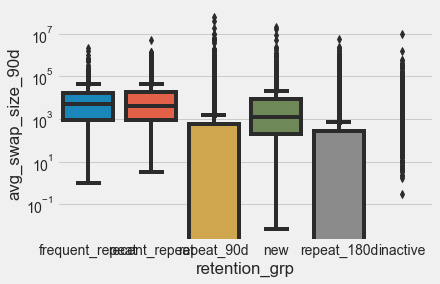

In [2293]:
fig, axs = mp.subplots()
sns.boxplot(data=df_cow_users_2, y='avg_swap_size_90d', x='retention_grp')
axs.set_yscale('log')

In [2301]:
for g in df_cow_users_2.retention_grp.unique():
    print(g)
    print(np.percentile(df_cow_users_2[df_cow_users_2.retention_grp==g].avg_swap_size_90d,75))

frequent_repeat
17560.068041535178
recent_repeat
17823.92242722308
repeat_90d
618.115639278112
new
8694.18106884502
repeat_180d
286.30939135446596
inactive
0.0


In [2387]:
lst_out = df_cow_users_2[df_cow_users_2.retention_grp=='recent_repeat']

In [2388]:
len(lst_out)

722

In [2389]:
lst_out['trader_clean']=[lst_out.trader.iloc[i].replace('\\x','0x') for i in range(0,len(lst_out))]
lst_out['trader'].to_csv('recent_repeat_wallets.csv')

/var/folders/65/cp24vlbd6k72vwzjx9v56yr80000gn/T/ipykernel_3039/3423740064.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [2463]:
df_freq_repeat = pd.read_csv('frequent_repeat_alldex.csv')
df_freq_repeat.head()

trader       project     trade_vol  \
0  \x0000b00b59ad8750d108cea6c583ab6e4c9a6ab9         Kyber     10.849446   
1  \x0000b00b59ad8750d108cea6c583ab6e4c9a6ab9      Balancer     54.362645   
2  \x0000b00b59ad8750d108cea6c583ab6e4c9a6ab9       Uniswap   2964.591962   
3  \x0000b00b59ad8750d108cea6c583ab6e4c9a6ab9         Curve   5228.526055   
4  \x0000b00b59ad8750d108cea6c583ab6e4c9a6ab9  CoW Protocol  64142.805628   

   num_trades  
0           1  
1           1  
2           2  
3           1  
4           4

In [2464]:
df_freq_repeat['cowswap_flag']=0
df_freq_repeat.loc[df_freq_repeat.project=='CoW Protocol','cowswap_flag']=1


In [2465]:
df_freq_all = df_freq_repeat.groupby('trader').agg(sum_volume=('trade_vol','sum'),
num_trades = ('num_trades','sum'),
num_dex = ('project','nunique')).reset_index()
df_freq_cow = df_freq_repeat[df_freq_repeat.cowswap_flag==1].groupby('trader').agg(sum_volume=('trade_vol','sum'),
num_trades = ('num_trades','sum'),
num_dex = ('project','nunique')).reset_index()


In [2466]:
df_freq_combined = df_freq_all.merge(df_freq_cow, how='left', left_on='trader', right_on='trader').merge(df_cow_users_2[['trader','rank_vol_90d','is_safe']], how='left',left_on='trader', right_on='trader')

In [2467]:
df_freq_combined['rank_vol_cow']=600
df_freq_combined.loc[df_freq_combined.rank_vol_90d<600,'rank_vol_cow']=df_freq_combined[df_freq_combined.rank_vol_90d<600].rank_vol_90d

In [2468]:
df_freq_combined['share_cow']=df_freq_combined.sum_volume_y/df_freq_combined.sum_volume_x
df_freq_combined['avg_swap_size']=df_freq_combined.sum_volume_x/df_freq_combined.num_trades_x

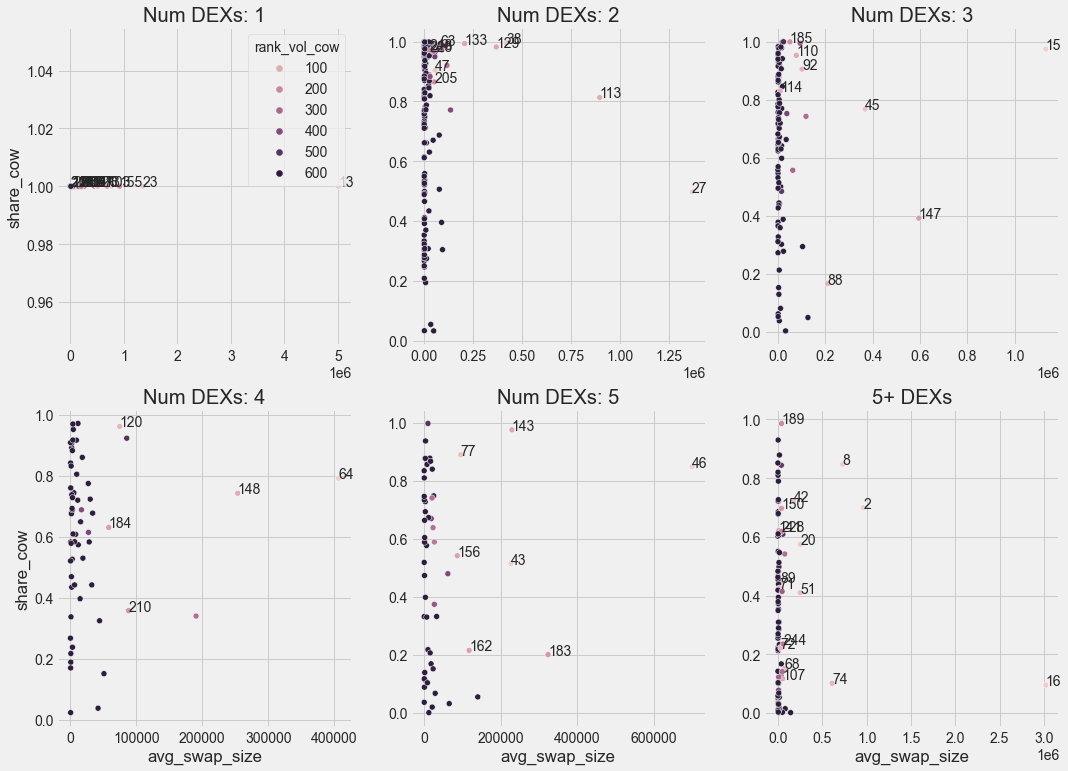

In [2396]:
fig, axs = mp.subplots(2,3, figsize=(16,12))
xcol='avg_swap_size'
ycol = 'share_cow'
rank_max=255
cnt = 0
for i in range(0,2):
    for j in  range(0,3):
        cnt+=1
        if cnt<6:
            df_chart = df_freq_combined[df_freq_combined.num_dex_x==cnt]
            sns.scatterplot(data = df_chart, x=xcol,y=ycol, hue='rank_vol_cow', ax=axs[i,j])
            for r in range(1,rank_max):
                tmp=df_chart[df_chart.rank_vol_cow==r]
                if len(tmp)>0:
                    axs[i,j].text(tmp[xcol], tmp[ycol],str(r))
            axs[i,j].set_title('Num DEXs: ' + str(cnt))
        else:
            df_chart = df_freq_combined[df_freq_combined.num_dex_x>=cnt]
            sns.scatterplot(data = df_chart, x='avg_swap_size',y='share_cow', hue='rank_vol_cow', ax=axs[i,j])
            for r in range(1,rank_max):
                tmp=df_chart[df_chart.rank_vol_cow==r]
                if len(tmp)>0:
                    axs[i,j].text(tmp[xcol], tmp[ycol],str(r))
            axs[i,j].set_title('5+ DEXs')
        if cnt>1:
            axs[i,j].get_legend().remove()
        if j>0:
            axs[i,j].set_ylabel('')
        if i==0:
            axs[i,j].set_xlabel('')


In [2469]:
sum(df_cow_users_2[(df_cow_users_2.rank_vol_90d<255)&(df_cow_users_2.retention_grp=='recent_repeat') 
& (df_cow_users_2.trader.isin(df_freq_combined[df_freq_combined.share_cow>0.75].trader.unique()))
].share_vol_90d)

0

In [2472]:
len(df_freq_combined[(df_freq_combined.is_safe==1)&(df_freq_combined.share_cow>0.75)])

8

In [2411]:
df_freq_repeat[(df_freq_repeat.trader.isin(df_freq_combined[(df_freq_combined.share_cow>0.75)&(df_freq_combined.num_dex_x<=3)].trader.unique())) & (df_freq_repeat.project!='CoW Protocol')].groupby('project').agg(sum_volume=('trade_vol','sum'),
num_trades = ('num_trades','sum')).reset_index().to_csv('adsad.csv')

In [1155]:
df_cowswap_by_user = agg_cow_users(df_cow_users_2,'user_id',time_ranges=[90,180])
df_cowswap_by_user['geography']='multiple'
df_cowswap_by_user.loc[df_cowswap_by_user.num_geos==1,'geography']=[df_cow_users_2[df_cow_users_2.user_id==df_cowswap_by_user[(df_cowswap_by_user.num_geos==1)].user_id.iloc[i]].geography.iloc[0] for i in range(0,len(df_cowswap_by_user[(df_cowswap_by_user.num_geos==1)]))]
df_cowswap_by_user['rank_vol_90d'] = df_cowswap_by_user.volume_90d.rank(ascending=False)

Index(['level_0', 'index', 'user_id', 'total_volume', 'total_swaps',
       'share_vol', 'share_swaps', 'days_active_cow', 'days_active_eth',
       'avg_fees', 'sum_fees', 'avg_cost', 'sum_cost', 'avg_cost_coverage',
       'num_trader', 'num_user', 'day_first', 'day_last', 'num_geos',
       'share_fees', 'share_cost', 'cost_coverage', 'share_trader',
       'swaps_90d', 'volume_90d', 'avg_fees_90d', 'sum_fees_90d',
       'avg_cost_90d', 'sum_cost_90d', 'avg_cost_coverage_90d',
       'share_swaps_90d', 'share_vol_90d', 'cost_coverage_90d',
       'avg_swap_size_90d', 'volume_per_trader_90d', 'volume_per_user_90d',
       'swaps_180d', 'volume_180d', 'avg_fees_180d', 'sum_fees_180d',
       'avg_cost_180d', 'sum_cost_180d', 'avg_cost_coverage_180d',
       'share_swaps_180d', 'share_vol_180d', 'cost_coverage_180d',
       'avg_swap_size_180d', 'volume_per_trader_180d', 'volume_per_user_180d',
       'geography', 'rank_vol_90d'],
      dtype='object')

In [1562]:
df_holders

trader       balance
0     0x0000000000007f150bd6f54c40a34d7c3d5e9f56  2.298240e-13
1     0x000000000035b5e5ad9019092c665357240f594e  8.000000e-17
2     0x00000000003b3cc22af3ae1eac0440bcee416b40  1.674761e-02
3     0x000000000088e0120f9e6652cc058aec07564f69  1.851684e-01
4     0x00000000008c4fb1c916e0c88fd4cc402d935e7d  4.000000e-18
...                                          ...           ...
1733  0xff2c13a2d71a4d3b70f4086dc17b4aa6c075efde  3.098361e+04
1734  0xff42593bfe84580dc1406d3d7dd8b51952cbafa7  7.666530e+03
1735  0xffb6d97bd1e7b7bd08595096d15037401a1f416b  2.224000e+03
1736  0xffc4dff32984b555fb353847e6c2063f4de9da18  2.000000e-18
1737  0xffecc003640cf5f1bce4e3456f8e4e2130d0be83  1.568235e+02

[1738 rows x 2 columns]

In [2438]:
for g in df_geography.geography.unique():
    print(g)
    print(np.percentile(df_cow_users_2[df_cow_users_2.geography==g].avg_trade_size,75))

active >12 distinct hours
15.919537173653648
asia
16.425564168534002
europe
15.881746312747225
unknown
16.823412468033997
us
22.612051914139585
wallet >1y inactive
5.145333049539767


In [2441]:
# len(df_cow_users_2[df_cow_users_2.preferred_trade_time.isna()].share_vol_90d)
np.nanpercentile(df_cow_users_2.avg_trade_size_90d,99)

546.8163903005476

In [2429]:
df_geography = agg_cow_users(df_cow_users_2[~(df_cow_users_2.geography.isna())],'geography',time_ranges=[90,180])


In [2430]:
df_geography.to_csv('geography_grp.csv')

In [2473]:
len(df_cow_users_2[df_cow_users_2.geography.isna()])

31690

In [2476]:
df_other_dex = pd.read_csv('cowswap_other_dexs.csv')

In [2478]:
df_other_dex['cowswap_flag']=0
df_other_dex.loc[df_other_dex.project=='CoW Protocol','cowswap_flag']=1
df_other_dex_grp = df_other_dex.groupby('trader').agg(sum_volume=('trade_vol','sum'),
num_trades = ('num_trades','sum'),
num_dex = ('project','nunique')).reset_index()

df_other_dex_grp = df_other_dex[df_other_dex.cowswap_flag==1].groupby('trader').agg(sum_volume=('trade_vol','sum'),
num_trades = ('num_trades','sum'),
num_dex = ('project','nunique')).reset_index()



In [545]:
df_cow_wallet_grp = agg_cow_users(df_cow_users_2,'trader')


In [644]:
df_cow_users_2.keys()

Index(['trader', 'total_swaps', 'swaps_90d', 'swaps_180d', 'total_volume',
       'volume_90d', 'volume_180d', 'day_first', 'day_last', 'volume_per_day',
       'avg_num_trades', 'num_batches', 'avg_volume', 'sum_volume',
       'avg_dex_swaps', 'sum_fees', 'avg_fees', 'sum_cost', 'avg_cost',
       'cost_coverage', 'avg_num_trades_90d', 'num_batches_90d',
       'avg_volume_90d', 'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d',
       'avg_fees_90d', 'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d',
       'avg_num_trades_180d', 'num_batches_180d', 'avg_volume_180d',
       'sum_volume_180d', 'avg_dex_swaps_180d', 'sum_fees_180d',
       'avg_fees_180d', 'sum_cost_180d', 'avg_cost_180d', 'cost_coverage_180d',
       'share_vol', 'share_vol_90d', 'share_swaps', 'share_swaps_90d',
       'cs_share_vol', 'cs_share_vol_90d', 'cs_share_swaps',
       'cs_share_swaps_90d', 'rank_vol_x', 'rank_swaps', 'rank_vol_90d',
       'rank_swaps_90d', 'avg_trade_size', 'avg_trade_size_90d', '

Text(0.5, 1.0, 'Cowswap wallets volume and preferred trading time by geography')

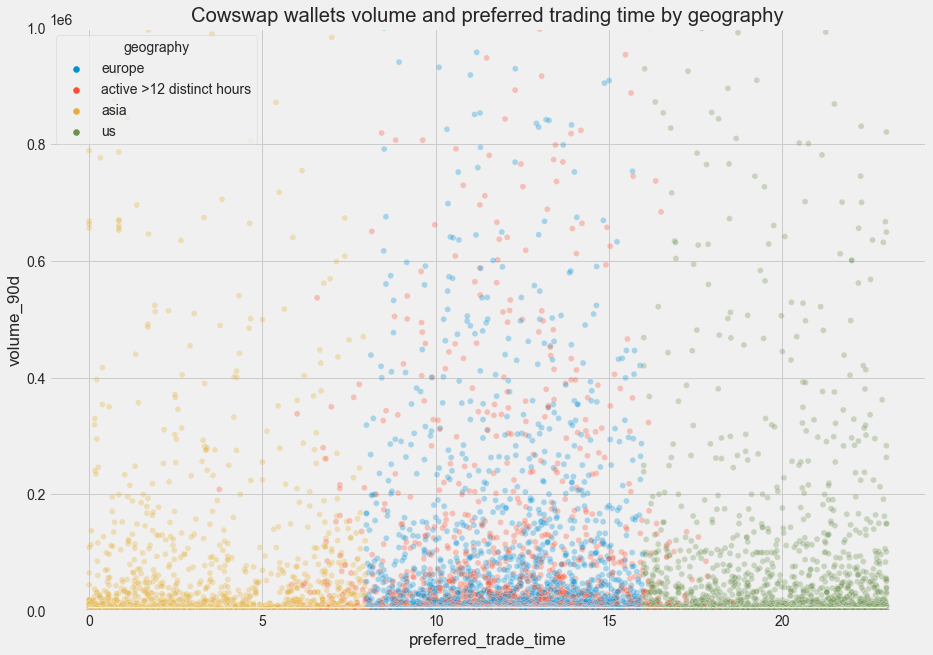

In [2421]:
fig, axs = mp.subplots(figsize=(14,10))
sns.scatterplot(data=df_cow_users_2[
# df_cow_users_2.trader.isin(df_cow_wallet_grp[(df_cow_wallet_grp.avg_swap_size_90d>100)].trader.unique()) 
(df_cow_users_2.geography!='unknown') &
(df_cow_users_2.geography!='wallet >1y inactive')],x='preferred_trade_time',y='volume_90d', hue='geography', alpha=0.3,
ax=axs)
mp.ylim(0,1000000)
mp.title('Cowswap wallets volume and preferred trading time by geography')

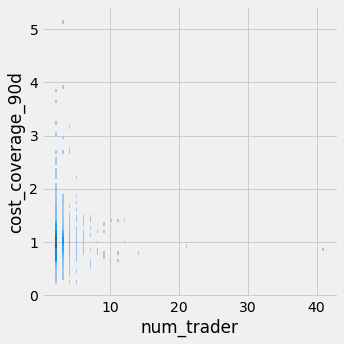

In [513]:
sns.displot(data= df_cow_user_grp[df_cow_user_grp.num_trader>1], x='num_trader', y='cost_coverage_90d')

In [167]:
sns.displot(data=df_cow_users_2[df_cow_users_2.user_id.isin(df_cow_user_wallets[df_cow_user_wallets.num_wallets>9].user_id.unique()) & (df_cow_users_2.user_id<10000)], x='preferred_trade_time', y='user_id', hue='geography')

0.948368808313091

In [161]:
df_active_cow_dex=pd.read_csv('active_cow_dex.csv')

In [162]:
df_active_cow_dex.head()

user project  status  days_active  \
0  \x02c2adbdb7c0c1037b5278626a78b6c71787dfe8   swapr  active           11   
1  \x09fc1031d03a78ed4f60463fa9749870d33439bc   swapr  active           81   
2  \x0f67ee9f041a681d8e0a2de3220ffabb6cc1b2a7   swapr  active            8   
3  \x1bde28ff577c97d63933cf91711762e9cd5cd2e3   swapr  active           54   
4  \x1d1661cb61bf5e3066f17f82099786d0fcc49d46   swapr  active          110   

   days_since_last_trade  total_volume  volume_90d  total_swaps  
0                     11     86.284350   86.284350            1  
1                     50    476.024771  476.024771            2  
2                      8    377.190267  377.190267            2  
3                     54    249.497219  249.497219            1  
4                      3    645.629685  143.915727            9

In [163]:
sum(df_active_cow_dex.total_volume)/1000000000

38.37094490571378

In [164]:
sum(df_active[df_active.user.isin(df_cow_users[df_cow_users.status=='active'].trader.unique())].total_volume)/1000000000

46.00480262513163

In [593]:
df_cow_active= df_cow_users_2[df_cow_users_2.status=='active'].reset_index()
add_cols(df_cow_active, bound_1 = int(len(df_cow_active)*0.01), bound_2 = int(len(df_cow_active)*0.1))

AttributeError: 'DataFrame' object has no attribute 'total_volume'

In [563]:
df_cow_active.keys()

Index(['trader', 'total_swaps', 'swaps_90d', 'total_volume_x', 'volume_90d',
       'day_first', 'day_last', 'volume_per_day', 'avg_num_trades',
       'num_batches', 'avg_volume', 'sum_volume', 'avg_dex_swaps', 'sum_fees',
       'avg_fees', 'sum_cost', 'avg_cost', 'cost_coverage',
       'avg_num_trades_90d', 'num_batches_90d', 'avg_volume_90d',
       'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d', 'avg_fees_90d',
       'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d', 'share_vol',
       'share_swaps', 'cs_share_vol', 'cs_share_swaps', 'rank_vol_x',
       'rank_swaps', 'avg_trade_size', 'rank_grp', 'days_active_x', 'status',
       'total_volume_y', 'hour_min', 'hour_max', 'hour12_max', 'hour24_min',
       'hour_cnt', 'hour_mean', 'hour_weighted', 'hour_shifted', 'days_min',
       'days_max', 'days_num', 'to_cnt', 'value', 'num_txs', 'gas_spent',
       'trade_span', 'days_age', 'days_last', 'days_active_y', 'rank_vol_y',
       'preferred_trade_time', 'txs_per_day', 

In [1545]:
df_cow_users_2.keys()

Index(['index', 'trader', 'total_swaps', 'swaps_90d', 'swaps_180d',
       'total_volume', 'volume_90d', 'volume_180d', 'day_first', 'day_last',
       'volume_per_day', 'avg_num_trades', 'num_batches', 'avg_volume',
       'sum_volume', 'avg_dex_swaps', 'sum_fees', 'avg_fees', 'sum_cost',
       'avg_cost', 'cost_coverage', 'avg_num_trades_90d', 'num_batches_90d',
       'avg_volume_90d', 'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d',
       'avg_fees_90d', 'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d',
       'avg_num_trades_180d', 'num_batches_180d', 'avg_volume_180d',
       'sum_volume_180d', 'avg_dex_swaps_180d', 'sum_fees_180d',
       'avg_fees_180d', 'sum_cost_180d', 'avg_cost_180d', 'cost_coverage_180d',
       'share_vol_90d', 'share_swaps_90d', 'rank_vol_90d', 'rank_swaps_90d',
       'avg_trade_size_90d', 'share_vol_180d', 'share_swaps_180d',
       'rank_vol_180d', 'rank_swaps_180d', 'avg_trade_size_180d', 'share_vol',
       'share_swaps', 'cs_share_vol', '

In [1561]:
len(df_cow_users_2[(df_cow_users_2.cow_holder>0)])

0

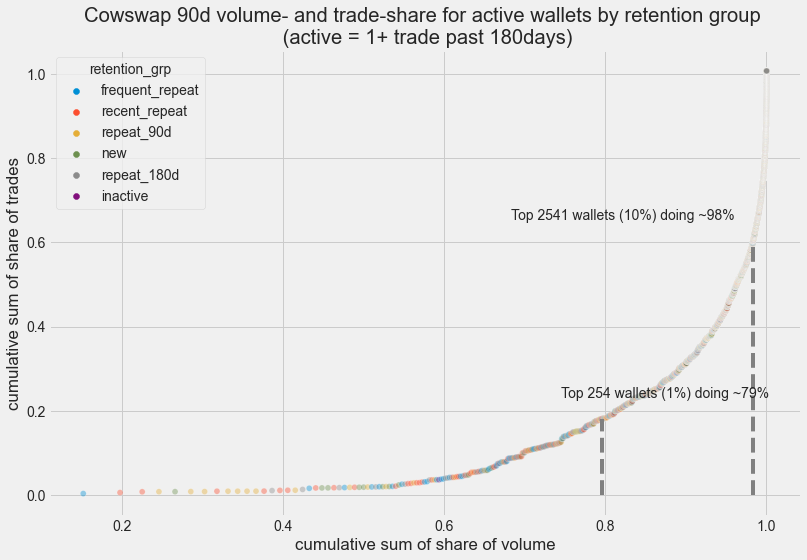

In [2255]:
xcol = 'share_vol_90d'
df_chart = df_cow_users_2[df_cow_users_2.status=='active'].sort_values(by=xcol,ascending=False).reset_index()
num_wallets = len(df_chart)

ycol='share_swaps_90d'
df_chart['cs_'+xcol] = np.cumsum(df_chart[xcol])
df_chart['cs_'+ycol] = np.cumsum(df_chart[ycol])

pos_1p = int(0.01*num_wallets)
x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

pos_10p = int(0.1*num_wallets)
x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x='cs_' + xcol, y='cs_'+ ycol, hue='retention_grp', alpha=0.4)
mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' wallets (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
mp.text(x_10p-0.3,y_10p+0.05,'Top ' + str(pos_10p) + ' wallets (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d volume- and trade-share for active wallets by retention group \n (active = 1+ trade past 180days)')
fig.savefig('charts/concentration_retention_90d.png')

In [2254]:
len(df_chart[df_chart.retention_grp=='inactive'].share_vol_90d)

780

Text(0.5, 1.0, 'Cowswap 90d volume- and trade-share for active wallets by geography')

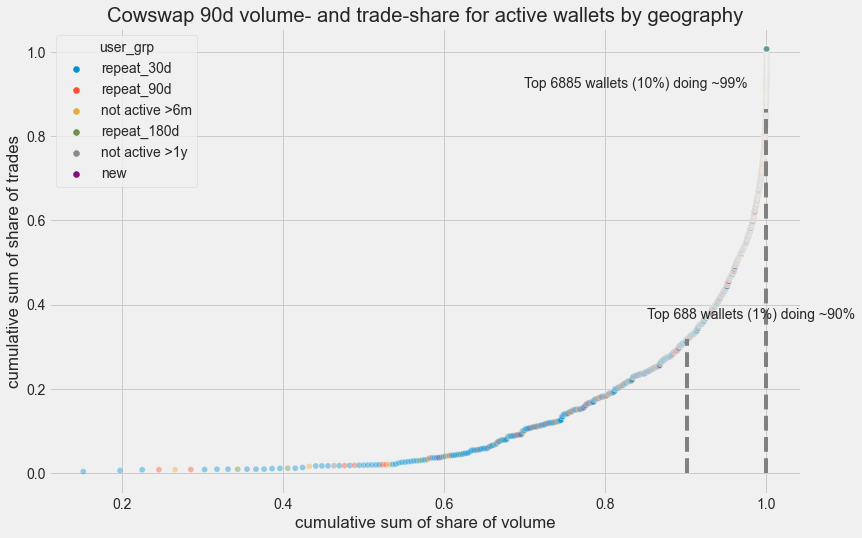

In [1345]:
xcol = 'share_vol_90d'
df_chart = df_cow_users_2.sort_values(by=xcol,ascending=False).reset_index()
num_wallets = len(df_chart)

ycol='share_swaps_90d'
df_chart['cs_'+xcol] = np.cumsum(df_chart[xcol])
df_chart['cs_'+ycol] = np.cumsum(df_chart[ycol])

pos_1p = int(0.01*num_wallets)
x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

pos_10p = int(0.1*num_wallets)
x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x='cs_' + xcol, y='cs_'+ ycol, hue='user_grp', alpha=0.4)
mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' wallets (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
mp.text(x_10p-0.3,y_10p+0.05,'Top ' + str(pos_10p) + ' wallets (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d volume- and trade-share for active wallets by geography')
# fig.savefig('charts/concentration_geography_90d.png')

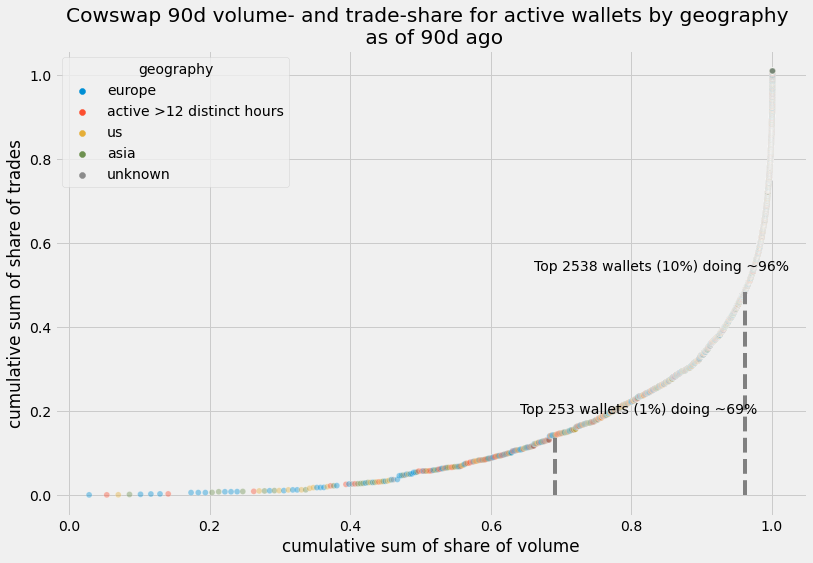

In [836]:
xcol = 'share_vol_180d'
df_chart = df_cow_users_2[df_cow_users_2.status=='active'].sort_values(by=xcol,ascending=False).reset_index()
num_wallets = len(df_chart)

ycol='share_swaps_180d'
df_chart['cs_'+xcol] = np.cumsum(df_chart[xcol])
df_chart['cs_'+ycol] = np.cumsum(df_chart[ycol])

pos_1p = int(0.01*num_wallets)
x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

pos_10p = int(0.1*num_wallets)
x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x='cs_' + xcol, y='cs_'+ ycol, hue='geography', alpha=0.4)
mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' wallets (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
mp.text(x_10p-0.3,y_10p+0.05,'Top ' + str(pos_10p) + ' wallets (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d volume- and trade-share for active wallets by geography \n as of 90d ago')
fig.savefig('charts/concentration_geography_180d.png')

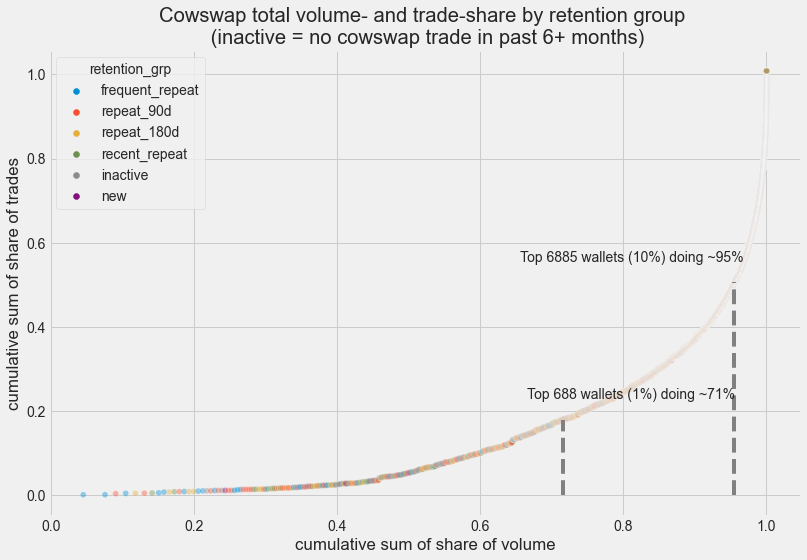

In [2247]:
xcol = 'share_vol'
df_chart = df_cow_users_2.sort_values(by=xcol,ascending=False).reset_index()
num_wallets = len(df_chart)

ycol='share_swaps'
df_chart['cs_'+xcol] = np.cumsum(df_chart[xcol])
df_chart['cs_'+ycol] = np.cumsum(df_chart[ycol])

pos_1p = int(0.01*num_wallets)
x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

pos_10p = int(0.1*num_wallets)
x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x='cs_' + xcol, y='cs_'+ ycol, hue='retention_grp', alpha=0.4)
mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' wallets (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
mp.text(x_10p-0.3,y_10p+0.05,'Top ' + str(pos_10p) + ' wallets (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap total volume- and trade-share by retention group \n (inactive = no cowswap trade in past 6+ months)')
fig.savefig('charts/concentration_status_total.png')


In [2248]:
gini(df_cow_users_2.total_volume)

0.9627313718221845

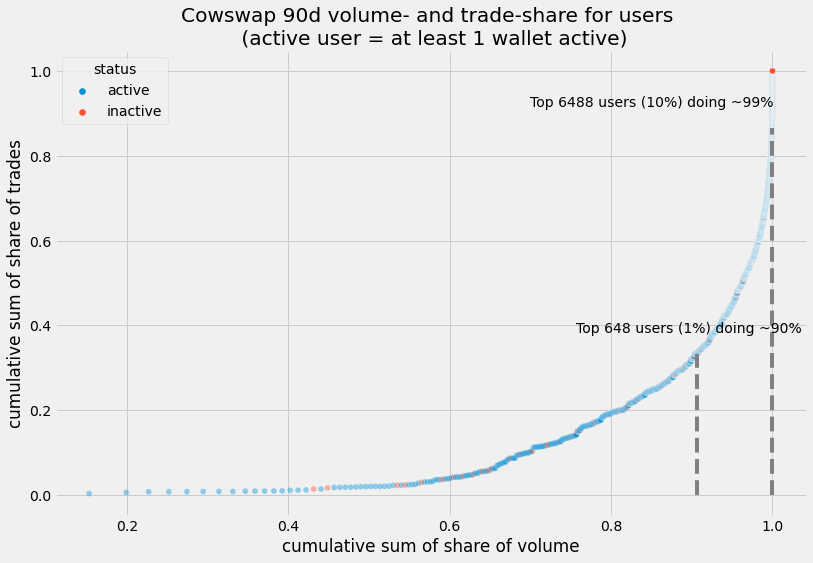

In [843]:
xcol = 'share_vol_90d'
df_chart = df_cowswap_by_user.sort_values(by=xcol,ascending=False)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'
num_wallets = len(df_chart)

ycol='share_swaps_90d'
df_chart['cs_'+xcol] = np.cumsum(df_chart[xcol])
df_chart['cs_'+ycol] = np.cumsum(df_chart[ycol])

pos_1p = int(0.01*num_wallets)
x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

pos_10p = int(0.1*num_wallets)
x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x='cs_' + xcol, y='cs_'+ ycol, hue='status',alpha=0.4)
mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
mp.text(x_1p-0.15,y_1p+0.05,'Top ' + str(pos_1p) + ' users (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
mp.text(x_10p-0.3,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.ylabel('cumulative sum of share of trades')
mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d volume- and trade-share for users \n (active user = at least 1 wallet active)')
fig.savefig('charts/concentration_status_90d_users.png')


In [841]:
gini(df_chart.volume_90d)

0.9930917846839109

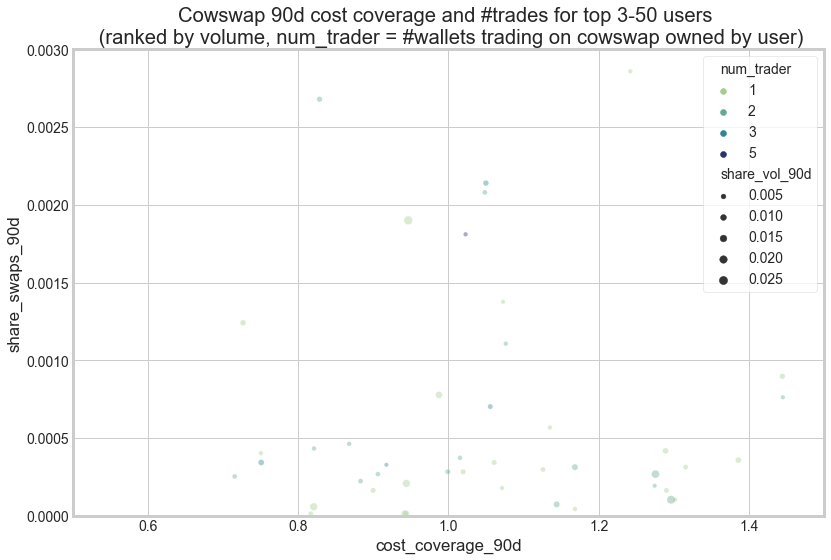

In [1174]:
sns.set_style("whitegrid")
xcol = 'cost_coverage_90d'
df_chart = df_cowswap_by_user[(df_cowswap_by_user.rank_vol_90d>2) & (df_cowswap_by_user.rank_vol_90d<51)].sort_values(by=xcol,ascending=False)
num_wallets = len(df_chart)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'

ycol='share_swaps_90d'

# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
# y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

# pos_10p = int(0.1*num_wallets)
# x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
# y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x=xcol, y=ycol, alpha=0.4, size = 'share_vol_90d', hue='num_trader', palette='crest')

# mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
# mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' users (1%) doing ~' + str(int(x_1p*100))+ '%')
# mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
# mp.ylabel('share of trades')
# mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d cost coverage and #trades for top 3-50 users \n (ranked by volume, num_trader = #wallets trading on cowswap owned by user)')
mp.ylim(0,0.003)
mp.xlim(0.5,1.5)
fig.savefig('charts/swaps_profit_top50_90d_users.png')

In [1024]:
# pd.set_option("max_rows", 100)
df_cow_users_2[df_cow_users_2.user_id.isin(df_cowswap_by_user[(df_cowswap_by_user.rank_vol_90d<51) & (df_cowswap_by_user.rank_vol_90d>2)].user_id.unique())].groupby('geography').agg({'share_vol_90d':'sum'})/sum(df_chart[(df_chart.rank_vol_90d>2) & (df_chart.rank_vol_90d<51)].share_vol_90d)
# .sum_fees_90d)/sum(df_chart[(df_chart.rank_vol_90d>2) & (df_chart.rank_vol_90d<51)].sum_cost_90d)

share_vol_90d
geography                               
active >12 distinct hours       0.194739
asia                            0.152035
europe                          0.435353
unknown                         0.021975
us                              0.151028

In [1034]:
sum(df_cow_users_2[(df_cow_users_2.volume_90d>0)&(df_cow_users_2.cost_coverage_90d.isna())].share_vol_90d)

0.014841266365888521

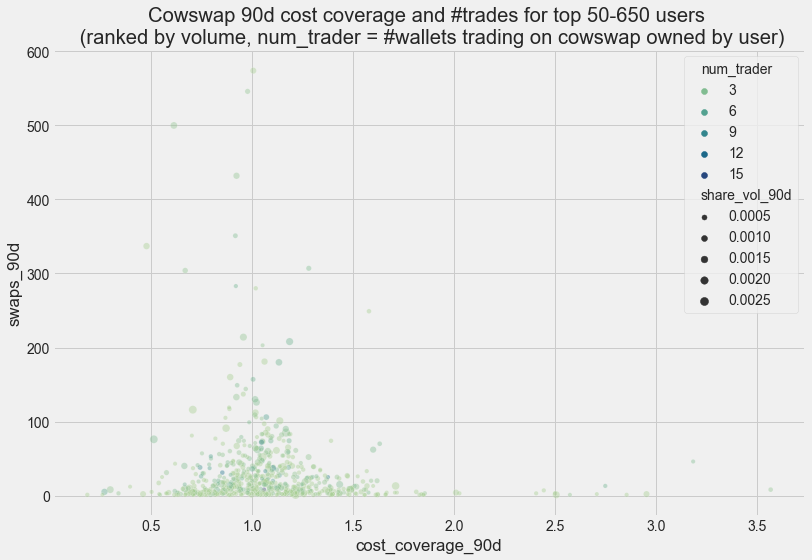

In [1173]:
xcol = 'cost_coverage_90d'
df_chart = df_cowswap_by_user[(df_cowswap_by_user.rank_vol_90d<651)&((df_cowswap_by_user.rank_vol_90d>51))].sort_values(by=xcol,ascending=False)
num_wallets = len(df_chart)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'

ycol='swaps_90d'

# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
# y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

# pos_10p = int(0.1*num_wallets)
# x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
# y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x=xcol, y=ycol, alpha=0.4, size = 'share_vol_90d', hue='num_trader', palette='crest')

# mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
# mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' users (1%) doing ~' + str(int(x_1p*100))+ '%')
# mp.plot([p,x_10p],[0,y_10p], color='gray', linestyle='--')
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
# mp.ylabel('share of trades')
# mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d cost coverage and #trades for top 50-650 users \n (ranked by volume, num_trader = #wallets trading on cowswap owned by user)')
# mp.ylim(0,500)
# mp.xlim(0.5,1.5)
fig.savefig('charts/swaps_profit_top650_90d_users.png')

In [931]:
# sum(df_chart.sum_fees_90d)/sum(df_chart.sum_cost_90d)
sum(df_chart.share_vol_90d)
sum(df_chart[df_chart.status=='inactive'].share_vol_90d)

0.03874268959322296

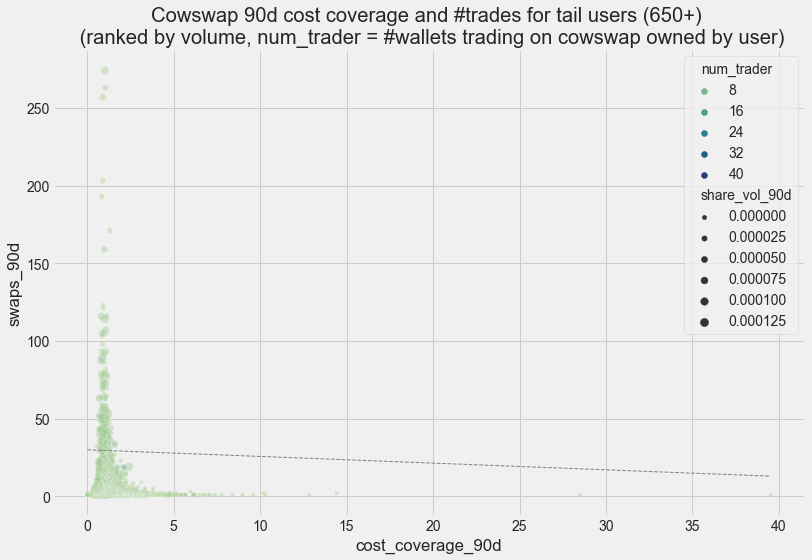

In [1172]:
xcol = 'cost_coverage_90d'
df_chart = df_cowswap_by_user[
    (df_cowswap_by_user.rank_vol_90d>651) ].sort_values(by=xcol,ascending=False)
num_wallets = len(df_chart)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'

ycol='swaps_90d'

# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
# y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

# pos_10p = int(0.1*num_wallets)
# x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
# y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x=xcol, y=ycol, alpha=0.4, size = 'share_vol_90d', hue='num_trader', palette='crest')

# mp.plot([x_1p,x_1p],[0,y_1p], color='gray', linestyle='--')
# mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' users (1%) doing ~' + str(int(x_1p*100))+ '%')
mp.plot([min(df_chart[xcol]),max(df_chart[xcol])],[30,13], color='gray', linestyle='--', linewidth=1)
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
# mp.ylabel('share of trades')
# mp.xlabel('cumulative sum of share of volume')
mp.title('Cowswap 90d cost coverage and #trades for tail users (650+) \n (ranked by volume, num_trader = #wallets trading on cowswap owned by user)')
# mp.ylim(0,500)
# mp.xlim(0.5,1.5)
fig.savefig('charts/swaps_profit_tail_users.png')

In [1157]:
# sum(df_chart[df_chart.swaps_90d>12].sum_fees_90d)/sum(df_chart[df_chart.swaps_90d>12].sum_cost_90d)
# len(df_chart[df_chart.status=='inactive'])
sum(df_cowswap_by_user[
    (df_cowswap_by_user.rank_vol_90d>651) & (df_cowswap_by_user.swaps_90d>30)].share_swaps_90d)

0.14528033535444262

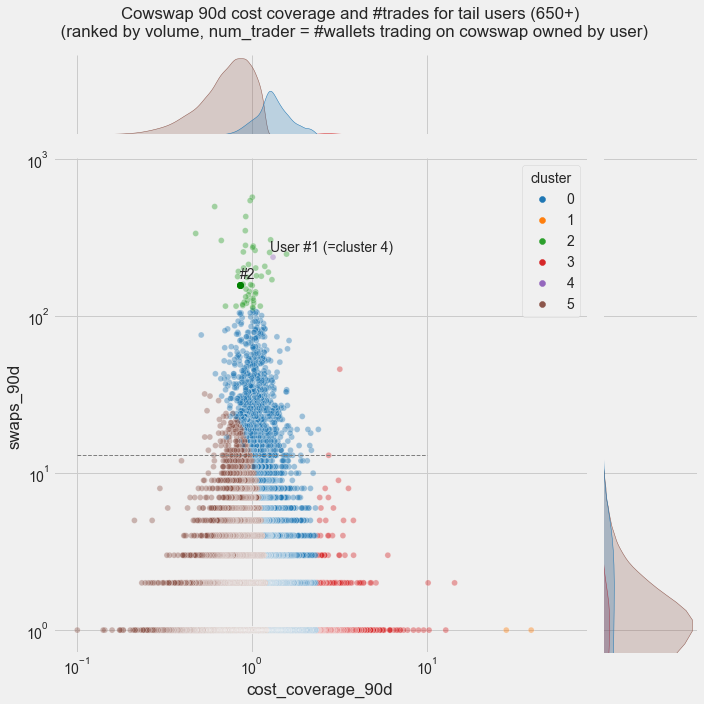

In [1185]:
xcol1 = 'volume_90d'

df_chart = df_cowswap_by_user[df_cowswap_by_user[xcol]>0].sort_values(by=xcol,ascending=False)
xcol='cost_coverage_90d'
df_chart['grp_by_vol']=3
df_chart.loc[df_chart.rank_vol_90d<3,'grp_by_vol']=1
df_chart.loc[(df_chart.rank_vol_90d>2)&(df_chart.rank_vol_90d<51),'grp_by_vol']=2
df_chart.loc[df_chart.rank_vol_90d>650,'grp_by_vol']=4
num_wallets = len(df_chart)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'

ycol='swaps_90d'

# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
# y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

# pos_10p = int(0.1*num_wallets)
# x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
# y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

# fig,axs=mp.subplots(figsize=(12,8))
# axs.set(xscale="log", yscale="log")
g=sns.jointplot(data = df_chart, x=xcol, y=ycol, alpha=0.4, height=10,
# size = 'volume_90d', 
hue='cluster', palette='tab10')

g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

tmp = df_chart[df_chart.rank_vol_90d==1]
# mp.plot([tmp[xcol],x_1p],[0,y_1p], color='gray', linestyle='--')
g.ax_joint.text(tmp[xcol]-0.05,tmp[ycol]*1.1,'User #1 (=cluster 4)')

tmp = df_chart[df_chart.rank_vol_90d==2]
g.ax_joint.text(tmp[xcol]-0.01,tmp[ycol]*1.1,'#2')
g.ax_joint.plot([tmp[xcol],tmp[xcol]],[tmp[ycol],tmp[ycol]], linestyle=None, marker='o', color='g')
g.ax_joint.plot([0.1,10],[13,13],color='gray', linestyle='dashed',linewidth=1)
# mp.plot([min(df_chart[xcol]),max(df_chart[xcol])],[13,13], color='gray', linestyle='--', linewidth=1)
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
# mp.ylabel('share of trades')
# mp.xlabel('cumulative sum of share of volume')
g.fig.suptitle('Cowswap 90d cost coverage and #trades for tail users (650+) \n (ranked by volume, num_trader = #wallets trading on cowswap owned by user)')
g.fig.tight_layout()
# mp.ylim(0,500)
# mp.xlim(0.5,1.5)
# g.fig.savefig('charts/swaps_profit_cluster_users.png')

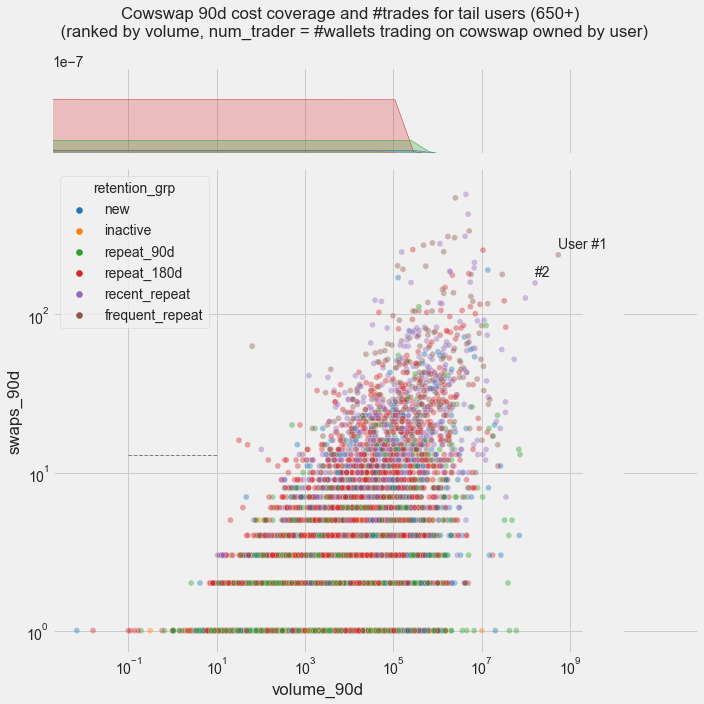

In [2259]:
xcol1 = 'volume_90d'

df_chart = df_cow_users_2.sort_values(by=xcol,ascending=False)
xcol='volume_90d'
df_chart['user_grp']=''
df_chart.loc[(df_chart[xcol1]>0) & (df_chart.day_first<=90),'user_grp']='new'
df_chart.loc[(df_chart[xcol1]>0) & (df_chart.volume_180d>0),'user_grp']='repeat_180d'
df_chart.loc[(df_chart[xcol1]>0) & ((df_chart.volume_180d==0) | (df_chart.volume_180d.isna())) & (df_chart.day_first>=180),'user_grp']='no_rev_180d_but90d'
df_chart.loc[(df_chart.day_last>90),'user_grp']='inactive >3m'
df_chart.loc[(df_chart.day_last>180),'user_grp']='inactive >6m'
df_chart.loc[(df_chart.day_last>365),'user_grp']='inactive >1y'
num_wallets = len(df_chart)
df_chart['status']='inactive'
df_chart.loc[df_chart.day_last<180,'status']='active'

ycol='swaps_90d'

# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart['cs_'+xcol].iloc[pos_1p]
# y_1p = df_chart['cs_'+ycol].iloc[pos_1p]

# pos_10p = int(0.1*num_wallets)
# x_10p = df_chart['cs_'+xcol].iloc[pos_10p]
# y_10p = df_chart['cs_'+ycol].iloc[pos_10p]

# fig,axs=mp.subplots(figsize=(12,8))
# axs.set(xscale="log", yscale="log")
g=sns.jointplot(data = df_chart, x=xcol, y=ycol, alpha=0.4, height=10,
# size = 'volume_90d', 
hue='retention_grp', palette='tab10')


g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

tmp = df_chart[df_chart.rank_vol_90d==1]
# mp.plot([tmp[xcol],x_1p],[0,y_1p], color='gray', linestyle='--')
g.ax_joint.text(tmp[xcol]-0.05,tmp[ycol]*1.1,'User #1')

tmp = df_chart[df_chart.rank_vol_90d==2]
g.ax_joint.text(tmp[xcol]-0.01,tmp[ycol]*1.1,'#2')
# g.ax_joint.plot([tmp[xcol],tmp[xcol]],[tmp[ycol],tmp[ycol]], linestyle=None, marker='o', color='g')
g.ax_joint.plot([0.1,10],[13,13],color='gray', linestyle='dashed',linewidth=1)
# mp.plot([min(df_chart[xcol]),max(df_chart[xcol])],[13,13], color='gray', linestyle='--', linewidth=1)
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' users (10%) doing ~' + str(int(x_10p*100))+ '%')
# mp.ylabel('share of trades')
# mp.xlabel('cumulative sum of share of volume')
g.fig.suptitle('Cowswap 90d cost coverage and #trades for tail users (650+) \n (ranked by volume, num_trader = #wallets trading on cowswap owned by user)')
g.fig.tight_layout()
# mp.ylim(0,500)
# mp.xlim(0.5,1.5)
# g.fig.savefig('charts/swaps_profit_vol_grp_users.png')

In [1208]:
# df_cow_users_2[df_cow_users_2.user_id.isin(df_cowswap_by_user[(df_cowswap_by_user.rank_vol_90d<51) & (df_cowswap_by_user.rank_vol_90d>2)].user_id.unique())].groupby('geography').agg({'share_vol_90d':'sum'})/sum(df_chart[(df_chart.rank_vol_90d>2) & (df_chart.rank_vol_90d<51)].share_vol_90d)
# df_cow_all_full[df_cow_all_full.trader=='\\x012144ba349d6ae5b68581b29ea4d42b1f43fdb7']
# df_cowswap_by_user['rank_swaps_90d']=df_cowswap_by_user.swaps_90d.rank(ascending=False)
# sum(df_chart.share_swaps_90d)
# s(df_chart.rank_vol_90d)
# sum(df_cowswap_by_user[(df_cowswap_by_user.rank_swaps_90d<650)].share_swaps_90d)
# df_cowswap_by_user[(df_cowswap_by_user.cluster==5) & (df_cowswap_by_user.swaps_90d<=12)]
df_chart[df_chart.user_grp=='']

trader  total_swaps  swaps_90d  \
3809   \x1f13a5dc44911ebd98ea1b55ab5b7b2a99acca14            4          3   
7267   \x67ad3da08eb57cc79241c92169ead5d2f4736b02            3          2   
50077  \xa594c798593d679d79cc5e5622d9b479dbef9e79            5          1   
50069  \xb445c5c0cb07ec214a6756a1ba91f4dbea68a87e            4          3   
4799   \x43598d1699b03e3d701da48332a5329598597775            6          4   
...                                           ...          ...        ...   
68836  \x8ea84afa2ed8ad8b5b5f2950454a41254ee8eea3            1          0   
68840  \x63959fd3fbb8dda874bfdaba7bfb0b9084c759ff            5          0   
68845  \x2dd5fdd1a9dc94449ba1bb5842e2934e8a9a1ea5           19          0   
68847  \x269326187b5da7a1e9d58ee347c9b1dd395e359b            1          0   
68851  \x57099da19e52784823c0aab1e8d8124e964c4282            5          0   

       swaps_180d   total_volume    volume_90d   volume_180d  day_first  \
3809            1   16554.453166  16554.453166      0.000000        146   
7267            1    1604.797636   1604.797636      0.000000        149   
50077           1     267.501485      0.000000    267.501485        252   
50069           1    1038.325441      0.000000   1038.325441        101   
4799            2    8283.281466   8283.281466      0.000000         91   
...           ...            ...           ...           ...        ...   
68836           1   34153.541349      0.000000  34153.541349        163   
68840           1    7062.413168      0.000000   1589.982164        282   
68845           4    8137.553196      0.000000    347.437273        296   
68847           1     906.008037      0.000000    906.008037        148   
68851           3  733600.003653      0.000000  94723.340272        315   

       day_last  volume_per_day  avg_num_trades  num_batches     avg_volume  \
3809          3      115.765407        2.500000          4.0   13113.047482   
7267          1       10.843227        1.333333          3.0   41564.293432   
50077        12        1.114590        2.000000          5.0   72643.213265   
50069         7       11.046015        2.000000          4.0    6223.128107   
4799         53      217.981091        2.166667          6.0    5998.333422   
...         ...             ...             ...          ...            ...   
68836       163        0.000000        1.000000          1.0   34153.541349   
68840       165       60.362506        4.600000          5.0   25949.564834   
68845       140       52.163803        1.789474         19.0    2978.887689   
68847       148        0.000000        2.000000          1.0   12145.800246   
68851       145     4315.294139        1.800000          5.0  173242.005804   

          sum_volume  avg_dex_swaps     sum_fees    avg_fees     sum_cost  \
3809    39339.142445           2.25    65.778471   21.926157   103.394243   
7267    83128.586865           1.00    52.093128   26.046564    98.559108   
50077  217929.639795           3.40   414.945338  138.315113   597.844844   
50069   18669.384322           1.75    31.534948   10.511649    54.952642   
4799    35990.000531           2.00   103.009761   17.168293   137.668301   
...              ...            ...          ...         ...          ...   
68836   34153.541349           1.00    68.528399   68.528399    87.463955   
68840  129747.824169           3.60  1282.145896  256.429179  1434.475455   
68845   56598.866082           1.00   863.663071   45.455951  1316.539799   
68847   12145.800246           2.00    19.845260   19.845260    43.682889   
68851  866210.029022           2.40   775.712135  155.142427  1137.894073   

         avg_cost  cost_coverage  avg_num_trades_90d  num_batches_90d  \
3809    25.848561       0.848254            2.666667              3.0   
7267    32.853036       0.792821            1.500000              2.0   
50077  119.568969       1.156781            2.000000              1.0   
50069   13.738161       0.765142            2.00000

In [1201]:
def get_cluster_grp(df,criteria):
    if not 'avg_swap_size_90d' in df.keys():
        df['avg_swap_size_90d']=df.volume_90d/df.swaps_90d
    df_clusters = df.groupby(criteria).agg(
        num_users=('user_id','nunique'),
        volume_90d = ('volume_90d','sum'),
        swaps_90d = ('swaps_90d','sum'),
        median_swap_size_90d = ('avg_swap_size_90d','median'),
        share_vol_90d = ('share_vol_90d','sum'),
        median_cc_90d = ('cost_coverage_90d','median'),
        cost_90d = ('avg_cost_90d','sum'),
        fees_90d = ('avg_fees_90d','sum'),
        share_swaps_90d = ('share_swaps_90d','sum')
    ).reset_index()
    df_clusters['avg_swap_size_90d']=df_clusters.volume_90d/df_clusters.swaps_90d
    df_clusters['cost_coverage_90d'] = df_clusters.fees_90d/df_clusters.cost_90d
    df_clusters.share_vol_90d=df_clusters.share_vol_90d
    return df_clusters

In [1190]:
df_grp_clusters = get_cluster_grp(df_cowswap_by_user,'cluster')

In [1191]:
df_grp_vol= get_cluster_grp(df_chart,'grp_by_vol')

In [1192]:
df_grp_clusters[['cluster','num_users','share_vol_90d','share_swaps_90d','median_swap_size_90d','avg_swap_size_90d','median_cc_90d','cost_coverage_90d']].to_csv('cluster_grp.csv')

In [1193]:
df_grp_vol[['grp_by_vol','num_users','share_vol_90d','share_swaps_90d','median_swap_size_90d','avg_swap_size_90d','median_cc_90d','cost_coverage_90d']].to_csv('vol_grp_users.csv')

In [1186]:
df_cowswap_by_user.keys()

Index(['level_0', 'index', 'user_id', 'total_volume', 'total_swaps',
       'share_vol', 'share_swaps', 'days_active_cow', 'days_active_eth',
       'avg_fees', 'sum_fees', 'avg_cost', 'sum_cost', 'avg_cost_coverage',
       'num_trader', 'num_user', 'day_first', 'day_last', 'num_geos',
       'share_fees', 'share_cost', 'cost_coverage', 'share_trader',
       'swaps_90d', 'volume_90d', 'avg_fees_90d', 'avg_cost_90d',
       'avg_cost_coverage_90d', 'share_swaps_90d', 'share_vol_90d',
       'cost_coverage_90d', 'avg_swap_size_90d', 'volume_per_trader_90d',
       'volume_per_user_90d', 'swaps_180d', 'volume_180d', 'avg_fees_180d',
       'avg_cost_180d', 'avg_cost_coverage_180d', 'share_swaps_180d',
       'share_vol_180d', 'cost_coverage_180d', 'avg_swap_size_180d',
       'volume_per_trader_180d', 'volume_per_user_180d', 'geography',
       'rank_vol_90d', 'cluster'],
      dtype='object')

In [1210]:
df_grp_user= get_cluster_grp(df_chart,'user_grp')


In [1211]:
df_grp_user[['user_grp','num_users','share_vol_90d','share_swaps_90d','median_swap_size_90d','avg_swap_size_90d','median_cc_90d','cost_coverage_90d']]
# .to_csv('vol_grp_users.csv')

user_grp  num_users  share_vol_90d  share_swaps_90d  \
0                             24       0.000008         0.000874   
1        inactive >1y       8606       0.000000         0.000000   
2        inactive >3m      12353       0.000000         0.000000   
3        inactive >6m      33631       0.000000         0.000000   
4                 new       6383       0.357181         0.355054   
5  no_rev_180d_but90d       1273       0.017356         0.057102   
6         repeat_180d       4331       0.626064         0.593329   

   median_swap_size_90d  avg_swap_size_90d  median_cc_90d  cost_coverage_90d  
0              0.000000         483.392792       0.662427           0.403384  
1                   NaN                NaN            NaN                NaN  
2                   NaN                NaN            NaN                NaN  
3                   NaN                NaN            NaN                NaN  
4           1255.062005       53114.433047       1.022221           1.056438  
5           1134.355221       16047.763427       1.003346           1.041388  
6           1881.341983       55711.076077       0.990826           1.082414

Text(0.5, 1.0, 'Cowswap 90d volume- and trade-share for active wallets by geography')

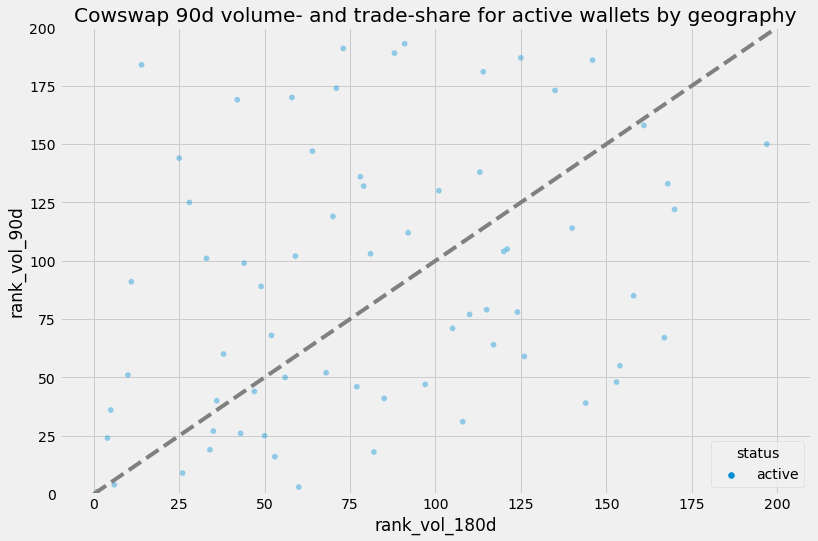

In [766]:
xcol='share_vol_180d'
max_rank=200
df_chart = df_cow_users_2[df_cow_users_2.rank_vol_180d<max_rank+1].sort_values(by=xcol)


ycol='rank_vol_90d'
# pos_1p = int(0.01*num_wallets)
# x_1p = df_chart[xcol].iloc[pos_1p]
# y_1p = df_chart[ycol].iloc[pos_1p]

fig,axs=mp.subplots(figsize=(12,8))
sns.scatterplot(data = df_chart, x=xcol, y=ycol, hue='status', alpha=0.4)

mp.plot([0,max_rank],[0,max_rank], color='gray', linestyle='--')
mp.ylim(0,max_rank)
# mp.text(x_1p-0.05,y_1p+0.05,'Top ' + str(pos_1p) + ' wallets (1%) doing ~' + str(int(x_1p*100))+ '%')
# mp.plot([x_10p,x_10p],[0,y_10p], color='gray', linestyle='--')
# mp.text(x_10p-0.1,y_10p+0.05,'Top ' + str(pos_10p) + ' wallets (10%) doing ~' + str(int(x_10p*100))+ '%')
mp.title('Cowswap 90d volume- and trade-share for active wallets by geography')


In [696]:
np.cumsum(np.sort([1,4,2,1],))

TypeError: _sort_dispatcher() got an unexpected keyword argument 'ascending'

In [628]:
df_cow_users_2[(df_cow_users_2.status=='inactive')&(df_cow_users_2.day_first-df_cow_users_2.day_last>0)]

trader  total_swaps  swaps_90d  \
12619  \xc0b374f27abccd5f34e30ba437adf10f084a66c4           20         20   
12651  \x768930616e3a5ef79fef0f2057641f179ee9e400           20         20   
12664  \x625d6e3f15c8c42a04d342d18937c6167f71e521           19         19   
12665  \x3ca1c693cd905d9e9f751811fc2d914feef1d37f           19         19   
12683  \x3a472fd2bab732329ea490440e8015e126a4fdb7           19         19   
...                                           ...          ...        ...   
68601  \xcaa747a69fed95ccbf211bbc06f00be75ad7b6f8            2          2   
68606  \xedd875275dc051b900893b41ac92cc3d44082295            2          2   
68608  \x2bcf59e816178dfdbf66d7cfc37d32687f104ae4            2          2   
68610  \xb71f5528aa87ac8571ecc7472c098e76a97a078f            2          2   
68616  \x1ac1a90b1dcd33f7979be3afa9dcd3b70b8a76a0            2          2   

        total_volume  volume_90d  day_first  day_last  volume_per_day  \
12619  139226.386219         0.0        332       232     1392.263862   
12651   36409.286046         0.0        290       186      350.089289   
12664  722216.929320         0.0        345       327    40123.162740   
12665  118504.268061         0.0        374       333     2890.348001   
12683   99722.257630         0.0        367       266      987.349085   
...              ...         ...        ...       ...             ...   
68601  138869.790876         0.0        227       194     4208.175481   
68606   17923.340472         0.0        258       257    17923.340472   
68608    1734.583059         0.0        345       268       22.527053   
68610    8144.977441         0.0        288       276      678.748120   
68616    1021.070096         0.0        283       277      170.178349   

       avg_num_trades  num_batches  ...     gas_spent  trade_span  days_age  \
12619        1.650000         20.0  ...  4.496300e-12        18.0      54.0   
12651             NaN          NaN  ...  2.149000e-12         9.0     191.0   
12664        1.263158         19.0  ...  5.446900e-12        23.0     344.0   
12665        1.157895         19.0  ...  6.115200e-12        18.0     200.0   
12683        1.473684         19.0  ...  4.818700e-12        15.0      18.0   
...               ...          ...  ...           ...         ...       ...   
68601        4.500000          2.0  ...  8.836900e-12        22.0     308.0   
68606             NaN          NaN  ...  2.286300e-12        21.0     175.0   
68608             NaN          NaN  ...           NaN         NaN       NaN   
68610             NaN          NaN  ...  1.031780e-11        18.0     267.0   
68616             NaN          NaN  ...           NaN         NaN       NaN   

       days_last  days_active_y  rank_vol_y  preferred_trade_time  \
12619        4.0           50.0      6246.0              8.171429   
12651       81.0          109.0     12444.0              8.086957   
12664       16.0          327.0      2139.0              0.225806   
12665       37.0          163.0      6862.0             10.771429   
12683        2.0           15.0      7803.0             14.285714   
...          ...            ...         ...                   ...   
68601      120.0          188.0      6258.0             14.860465   
68606       88.0           87.0     16787.0              2.040000   
68608        NaN            NaN         NaN                   NaN   
68610       48.0          218.0     23193.0             10.750000   
68616        NaN            NaN         NaN                   NaN   

       txs_per_day  trade_span_outer                  geography  
12619     0.700000              23.0  active >12 distinct hours  
12651     0.211009              12.0                     europe  
12664     0.094801              21.0                       asia  
12665     0.214724              20.0                     europe  
12683     2.333333              23.0                     europe  
...            ...               ...                        ...  
6

In [281]:
df_detail_cow['share_project']=df_detail_cow.volume_90d_y.fillna(0)/(df_detail_cow.volume_90d.fillna(0)+df_detail_cow.volume_90d_x.fillna(0))
df_detail_cow.loc[df_detail_cow.share_project.isna(),'share_project']=0
df_detail_cow['share_cow']=df_detail_cow.volume_90d_x.fillna(0)/(df_detail_cow.volume_90d.fillna(0)+df_detail_cow.volume_90d_x.fillna(0))
df_detail_cow.loc[df_detail_cow.share_cow.isna(),'share_cow']=0

In [282]:
df_detail_grp = df_detail_cow.groupby('trader').agg({'total_volume_x':'mean', 'share_project':'max','share_cow':'mean','days_active':'mean', 'days_active_x':'mean',
'user_y':'count',
'rank_vol_x':'mean',
'rank_vol_y':'mean'}).reset_index()


In [283]:
df_detail_grp[df_detail_grp.share_project.isna()]

Empty DataFrame
Columns: [trader, total_volume_x, share_project, share_cow, days_active, days_active_x, user_y, rank_vol_x, rank_vol_y]
Index: []

In [284]:
for i in range(0, len(df_detail_grp[df_detail_grp.user_y>0])):
    f = len(df_detail_cow[(df_detail_cow.trader==df_detail_grp[df_detail_grp.user_y>0].trader.iloc[i]) & (df_detail_cow.share_project==df_detail_grp[df_detail_grp.user_y>0].share_project.iloc[i])])
    if f==0:
        print(i)

In [279]:
df_detail_grp[df_detail_grp.user_y>0].iloc[2969]

trader            \x8c3fbb7d5d4c8ec3f1950cc15b43a76815ff2af1
total_volume_x                                   11724.55514
share_project                                            NaN
share_cow                                                NaN
days_active                                            530.0
days_active_x                                          238.0
user_y                                                     1
rank_vol_x                                            4635.0
rank_vol_y                                          307640.0
main_dex                                                    
Name: 4800, dtype: object

In [285]:
df_detail_grp['main_dex']=''
df_detail_grp.loc[df_detail_grp.user_y>0,'main_dex'] = [df_detail_cow[(df_detail_cow.trader==df_detail_grp[df_detail_grp.user_y>0].trader.iloc[i]) & (df_detail_cow.share_project==df_detail_grp[df_detail_grp.user_y>0].share_project.iloc[i])].project.iloc[0] for i in range(0, len(df_detail_grp[df_detail_grp.user_y>0]))]

In [246]:
df_detail_grp_fin = df_detail_grp.merge(df_cow_active, how='left', left_on='trader', right_on='trader').reset_index()

/opt/homebrew/Caskroom/miniforge/base/envs/python38_playground/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'days_active_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [230]:
df_detail_grp_fin[df_detail_grp_fin.rank_vol_x<20]

level_0                                      trader  total_volume_x  \
31         31  \x012144ba349d6ae5b68581b29ea4d42b1f43fdb7    5.566103e+08   
472       472  \x1e2ce0c1d8e9f7614dea6c3fa78e91d34247f380    1.112528e+08   
1170     1170  \x4c180462a051ab67d8237ede2c987590df2fbbe6    6.214447e+07   
1420     1420  \x5d2d49c7371eac3a89ca780ffe4ff32d311d9761    1.520899e+08   
1828     1828  \x78e96be52e38b3fc3445a2ed34a6e586ffab9631    1.057618e+08   
2467     2467  \xa0f75491720835b36edc92d06ddc468d201e9b73    2.136286e+08   
2679     2679  \xaf297dec752c909092a117a932a8ca4aaaff9795    9.683472e+07   
2851     2851  \xb9e025a1363373e48da72f7e4f6eb7cddf2f6501    1.103857e+08   
2934     2934  \xbf3c106331cca10e7a31ea421543eaa3a74ebad7    1.407836e+08   
3103     3103  \xca86d57519dbfe34a25eef0923b259ab07986b71    8.059032e+07   

      share_project  share_cow  days_active_x  days_active_x  user_y  \
31         0.067024   0.813255          295.0          222.0       1   
472        0.144899   0.855101          551.0          397.0       1   
1170       0.151600   0.844032          387.0          373.0       3   
1420       0.170897   0.715509          276.0           95.0       6   
1828       0.021082   0.978688          598.0          276.0       2   
2467       0.175430   0.617448          598.0          294.0       3   
2679       0.079450   0.880806          597.0          374.0       2   
2851       0.219938   0.255875          510.0          314.0      13   
2934       0.021770   0.926571          553.0          479.0       3   
3103       0.096466   0.667709          294.0          219.0       4   

      rank_vol_x  rank_vol_y  ... volume_per_day    volume_90d  share_vol  \
31           1.0       741.0  ...   2.507254e+06  4.126788e+08   0.067948   
472          8.0     20059.0  ...   2.802336e+05  2.144454e+03   0.013581   
1170        19.0      7179.0  ...   1.666072e+05  9.338624e+06   0.007586   
1420         6.0      2172.0  ...   1.600947e+06  1.511883e+08   0.018566   
1828        10.0      4495.0  ...   3.831949e+05  1.405830e+07   0.012911   
2467         4.0       197.0  ...   7.266279e+05  3.151078e+07   0.026079   
2679        13.0      1494.0  ...   2.589164e+05  1.209221e+07   0.011821   
2851         9.0       454.0  ...   3.515468e+05  2.575167e+07   0.013475   
2934         7.0      1278.0  ...   2.939115e+05  9.237128e+06   0.017186   
3103        15.0      1179.0  ...   3.679923e+05  7.198279e+06   0.009838   

      share_swaps  cs_share_vol  cs_share_swaps rank_vol  rank_swaps  \
31       0.001648      0.067948        0.001648      1.0        58.0   
472      0.001188      0.251479        0.014168      8.0       105.5   
1170     0.002823      0.368746        0.028727     19.0        20.0   
1420     0.001037      0.220711        0.011949      6.0       135.5   
1828     0.000543      0.277865        0.019071     10.0       334.5   
2467     0.001353      0.178479        0.009896      4.0        85.0   
2679     0.001868      0.313958        0.022312     13.0        43.0   
2851     0.004361      0.264954        0.018528      9.0         8.0   
2934     0.001030      0.237897        0.012980      7.0       138.5   
3103     0.001799      0.335346        0.025478     15.0        50.0   

      avg_trade_size  rank_grp  
31       2319.209497     <0.1k  
472       643.079508     <0.1k  
1170      151.203085     <0.1k  
1420     1007.218204     <0.1k  
1828     1338.756744     <0.1k  
2467     1084.409133     <0.1k  
2679      356.010002     <0.1k  
2851      173.835758     <0.1k  
2934      938.557252     <0.1k  
3103      307.596654     <0.1k  

[10 rows x 27 columns]

In [286]:
df_detail_grp_project = df_detail_cow.groupby('project').agg({'total_volume_x':'mean', 'share_project':'max','share_cow':'mean','days_active':'mean', 'days_active_x':'mean',
'user_y':'count',
'rank_vol_x':'mean',
'rank_vol_y':'mean'}).reset_index()

<AxesSubplot:xlabel='share_cow', ylabel='Count'>

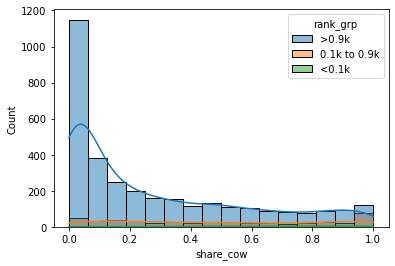

In [274]:
sns.histplot(data=df_detail_grp_fin[(df_detail_grp_fin.share_project<=1)], x='share_cow',hue='rank_grp', kde=True)

Text(0, 0.5, '#DEX used besides cowswap')

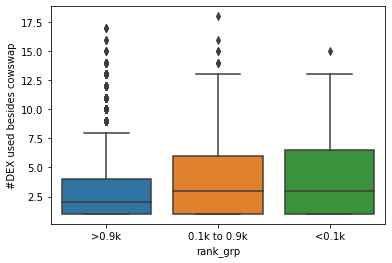

In [273]:
sns.boxplot(data=df_detail_grp_fin[(df_detail_grp_fin.share_project<=1)], y='user_y',x='rank_grp')
mp.ylabel('#DEX used besides cowswap')

In [ ]:
sns.boxplot(data=df_detail_grp_fin[(df_detail_grp_fin.share_project<=1)], y='user_y',x='rank_grp')
mp.ylabel('#DEX used besides cowswap')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Sushiswap'),
  Text(1, 0, 'Uniswap'),
  Text(2, 0, 'Curve'),
  Text(3, 0, 'Matcha'),
  Text(4, 0, 'hashflow'),
  Text(5, 0, '0x API'),
  Text(6, 0, 'Balancer'),
  Text(7, 0, '1inch'),
  Text(8, 0, 'Paraswap'),
  Text(9, 0, 'DFX Finance'),
  Text(10, 0, 'Bancor Network'),
  Text(11, 0, 'airswap'),
  Text(12, 0, '0x Native'),
  Text(13, 0, 'DODO'),
  Text(14, 0, 'Defi Swap'),
  Text(15, 0, 'DefiPlaza'),
  Text(16, 0, 'Clipper'),
  Text(17, 0, 'Mooniswap'),
  Text(18, 0, 'swapr'),
  Text(19, 0, 'Shell'),
  Text(20, 0, 'mStable'),
  Text(21, 0, 'Tokenlon'),
  Text(22, 0, 'Synthetix'),
  Text(23, 0, '1inch Limit Order Protocol'),
  Text(24, 0, 'Shibaswap')])

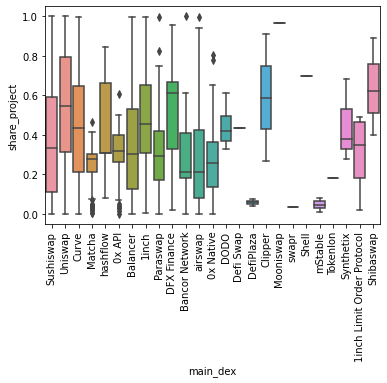

In [255]:

sns.boxplot(data=df_detail_grp_fin[(df_detail_grp_fin.share_project<=1)], y='share_project',x='main_dex')
mp.xticks(rotation=90)

In [288]:
df_cow_hours = pd.read_csv('cow_user_hours.csv')

In [289]:
df_cow_hours.head()

trader  hour  num_fill  total_volume
0  \x933258bddd49beeca77f6d1889633c5429af45ea     4       510  1.338553e+08
1  \x933258bddd49beeca77f6d1889633c5429af45ea     5       331  7.316264e+07
2  \x84e5c8518c248de590d5302fd7c32d2ae6b0123c    11       272  8.567495e+05
3  \x84e5c8518c248de590d5302fd7c32d2ae6b0123c    10       256  5.234487e+05
4  \x84e5c8518c248de590d5302fd7c32d2ae6b0123c    12       246  8.005557e+05

In [291]:
df_hours=  df_cow_hours.groupby('hour').agg({'trader':'nunique','num_fill':'sum','total_volume':'sum'}).reset_index()

Text(0, 0.5, '#Trades (blue line) and #traders (gray bars)')

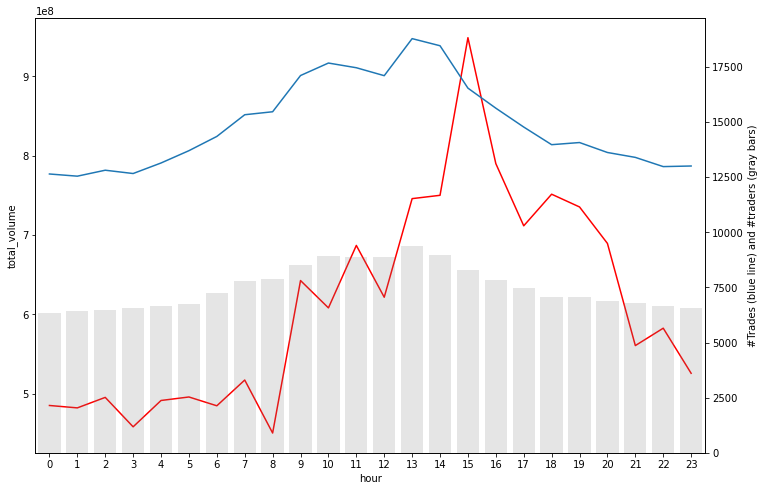

In [304]:
fig,axs=mp.subplots(figsize=(12,8))
sns.lineplot(data=df_hours, x='hour',y='total_volume', ax=axs, color='r')
ax2=axs.twinx()
sns.lineplot(data=df_hours, x='hour',y='num_fill', ax=ax2)
sns.barplot(data=df_hours, x='hour',y='trader', ax=ax2, color='gray', alpha=0.2)
ax2.set_ylabel('#Trades (blue line) and #traders (gray bars)')


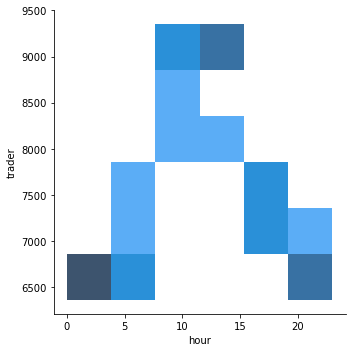

In [296]:
sns.boxplot(data=df_hours, x='hour',y='total_volume')

In [4]:
df_hours_1 = pd.read_csv('dex_hourly_top_1.csv')
df_hours_2 = pd.read_csv('dex_hourly_top_2.csv')
df_hours_3 = pd.read_csv('dex_hourly_top_3.csv')
df_hours_4 = pd.read_csv('dex_hourly_top_4.csv')
df_hours_5 = pd.read_csv('dex_hourly_top_5.csv')
df_hours_6 = pd.read_csv('dex_hourly_top_6.csv')
df_hours_7 = pd.read_csv('dex_hourly_top_7.csv')
df_hours_8 = pd.read_csv('dex_hourly_top_8.csv')
df_hours_9 = pd.read_csv('dex_hourly_top_9.csv')
df_hours_10 = pd.read_csv('dex_hourly_top_10.csv')
df_hours_11 = pd.read_csv('dex_hourly_top_11.csv')
df_hours_12 = pd.read_csv('dex_hourly_top_12.csv')
df_hours_13 = pd.read_csv('dex_hourly_top_13.csv')

In [306]:
df_hours_13.head()

user  hour  total_volume  total_swaps
0  \xd91d88014d3e156fc126106f346e43112cd07541     2  13502.668523           12
1  \x75a28547ac8eb72c2035aad5e146cb775604a05f    12  13502.603991            6
2  \xaa488f379d38e8a347c53fc0a47013bf627c46ba     0  13502.602124           12
3  \x87de74597c1f8af0309cc4eea15f137c14180f7f    22  13502.594613            7
4  \xde8a5c7061b2680cb53a64b0fef6657e5b15143e     5  13502.582349            6

In [5]:
df_hours = pd.concat([df_hours_1,
df_hours_2,
df_hours_3,
df_hours_4,
df_hours_5,
df_hours_6,
df_hours_7,
df_hours_8,
df_hours_9,
df_hours_10,
df_hours_11,
df_hours_12,
df_hours_13]).drop_duplicates(['user','hour']).reset_index()

In [6]:
df_hours['avg_swap_size']=df_hours.total_volume/df_hours.total_swaps
df_hours['share_user_vol']=0

In [24]:
swap_weight = lambda x: np.average(x, weights = df_hours.loc[x.index,'total_swaps'])

In [27]:
df = df_hours.groupby('user').agg(hour_min =('hour','min'),
hour_max = ('hour','max'),
hour_mean = ('hour','mean'),
hour_cnt = ('hour','nunique'),
hour_weighted = ('hour',swap_weight),
total_volume = ('total_volume','sum'),
total_swaps = ('total_swaps','sum')).reset_index()

In [28]:
df_users['rank_vol']=df_users.total_volume.rank(ascending=False)

In [29]:
df['trade_span']=df.hour_max-df.hour_min

In [342]:
cnt=0
for us in df[df_users.rank_vol<10000].user.unique():
    print(cnt)
    df_hours.loc[df_hours.user==us,'share_user_vol'] = df_hours[(df_hours.user==us)].total_volume/sum(df_hours[(df_hours.user==us)].total_volume)
    cnt+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [2443]:
# df_hours.to_pickle('df_hours.pkl')
df_hours=pd.read_pickle('df_hours.pkl')

In [12]:
df_hours_grp = df_hours.groupby('hour').agg({'user':'nunique','total_volume':'sum','total_swaps':'sum'}).reset_index()

NameError: name 'df_users' is not defined

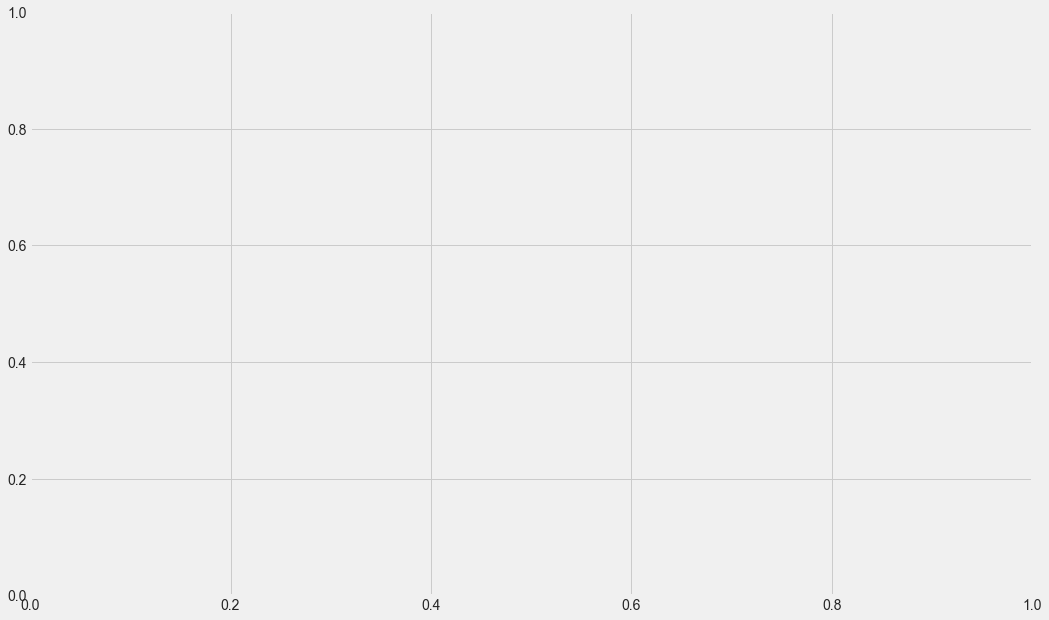

In [2448]:
fig, axs=mp.subplots(figsize=(16,10))
sns.lineplot(data=df_hours[df_hours.user.isin(df_users[(df_users.rank_vol<2000)& (df_users.hour['nunique']>16)].user.unique())], x='hour',y='share_user_vol',hue='user', alpha=0.1)
ax2=axs.twinx()
ax2.plot(df_hours_grp.hour, df_hours_grp.total_volume/1000000000, color='k')
axs.get_legend().remove()
axs.set_ylim(0,0.3)
# axs.set_title('Share of volume along UTC hours per DEX trader (left axis) and total trading volume ($bn, black, right axis, top 300k users)\n top 1k traders with >16 unique trading hours (~700)')

In [368]:
len(df_users[(df_users.rank_vol<1000)&(df_users.hour['nunique']<8)])
# sns.lineplot(data=df_hours_grp, x='hour',y='user')

34

In [2446]:
df_hours.head()

index                                        user  hour  total_volume  \
0      0  \xe92f359e6f05564849afa933ce8f62b8007a1d5d    15  1.202311e+09   
1      1  \x7b792e49f640676b3706d666075e903b3a4deec6     8  1.176499e+09   
2      2  \x7344e478574acbe6dac9de1077430139e17eec3d    16  9.403304e+08   
3      3  \x9c5083dd4838e120dbeac44c052179692aa5dac5    21  8.200868e+08   
4      4  \x7344e478574acbe6dac9de1077430139e17eec3d    17  8.148726e+08   

   total_swaps  avg_swap_size  share_user_vol  
0        13527   8.888228e+04        0.094387  
1           10   1.176499e+08        1.000000  
2           52   1.808328e+07        0.172184  
3          658   1.246333e+06        0.095897  
4           46   1.771462e+07        0.149212

In [72]:
get_preferred_trade_time(df_users)

In [48]:
df_users[df_users.preferred_trade_time==30]

user  hour_min  hour_max  \
4       \x000000000006553135e7257017eb200bea3a8dfc         2        21   
5       \x000000000008e4db6a6194c6957df47e30970dc2         0        23   
10      \x00000000003e04625c9001717346dd811ae5eba2         0        22   
18      \x00000000008f98ed69944e006c5a6d8898d81f63         1        23   
27      \x0000000001a719f1a223df532c993240f4180c73         0        23   
...                                            ...       ...       ...   
350867  \xfffde387b1786ad386eab77ef7b2aa9307f43197         0        16   
350872  \xfffe48c244343d1043cb9caa81f3a276b0fe1ee3         0        22   
350874  \xfffec623d679cdc6494a91fc7430730f86324f33         0        23   
350882  \xffff8941130157a0153fb5be2618b257f28d3b55         2        23   
350889  \xfffffd059e97c2bfc822569e13f636c3d176db41         2        17   

        hour_mean  hour_cnt  hour_weighted  total_volume  total_swaps  \
4       15.800000         5      16.600000  6.000476e+05           20   
5       13.181818        11      15.995012  2.161973e+05          401   
10      13.500000         4      12.725869  1.419902e+05          259   
18      12.857143         7      14.250000  2.654760e+05           56   
27       8.400000        10       7.362319  2.503558e+05           69   
...           ...       ...            ...           ...          ...   
350867   8.000000         2      10.553191  8.891992e+04           47   
350872  14.333333         3      13.000000  4.757512e+04            5   
350874   9.250000         8       6.100000  3.049572e+05           20   
350882  12.571429         7      11.666667  1.638245e+05           48   
350889   9.666667         9      10.139037  1.062241e+07          374   

        rank_vol  trade_span  preferred_trade_time  
4        56122.0          19                  30.0  
5       101781.0          23                  30.0  
10      126309.0          22                  30.0  
18       91000.0          22                  30.0  
27       93984.0          23                  30.0  
...          ...         ...                   ...  
350867  157613.0          16                  30.0  
350872  205769.0          22                  30.0  
350874   84071.0          23                  30.0  
350882  117632.0          21                  30.0  
350889    7443.0          15                  30.0  

[82934 rows x 11 columns]

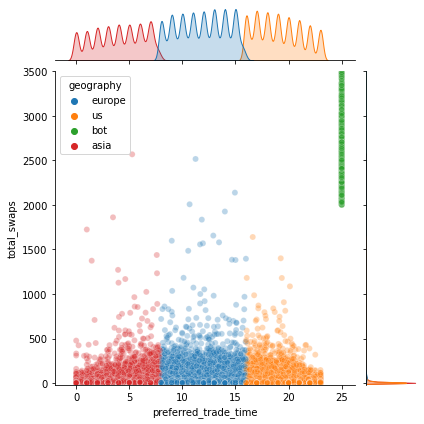

In [74]:
vol_lim=10000000
swap_lim=3500
sns.jointplot(data=df_users[df_users.preferred_trade_time<30], x='preferred_trade_time', y='total_swaps',hue='geography', ylim=(-20,swap_lim), alpha=0.3)


In [76]:
df_users['preferred_trade_time_int']=[np.round(df_users.preferred_trade_time.iloc[i],0) for i in range(0,len(df_users))]

In [78]:
df_user_hours = df_users.groupby(['geography','preferred_trade_time_int']).agg({'user':'count','total_volume':'sum','total_swaps':'sum'}).reset_index()

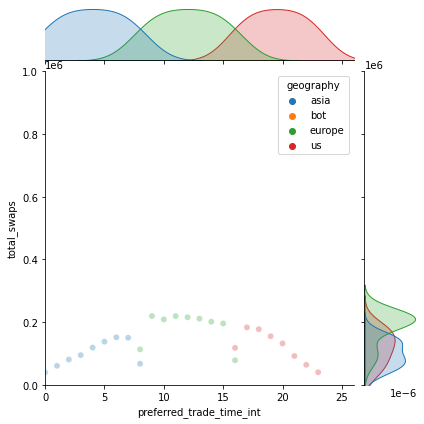

In [82]:
sns.jointplot(data=df_user_hours[df_user_hours.preferred_trade_time_int<30], x='preferred_trade_time_int', y='total_swaps',hue='geography', ylim=(-20,1000000), xlim=(0,26), alpha=0.3)

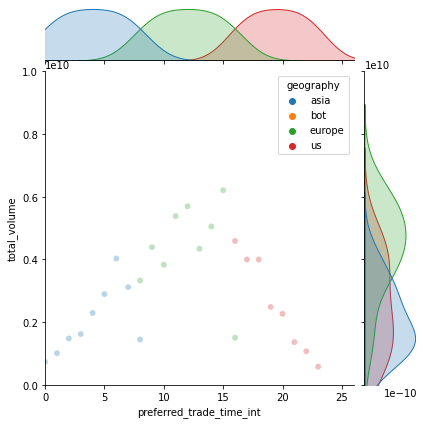

In [86]:
sns.jointplot(data=df_user_hours[df_user_hours.preferred_trade_time_int<30], x='preferred_trade_time_int', y='total_volume',hue='geography', ylim=(-20,10000000000), xlim=(0,26), alpha=0.3)

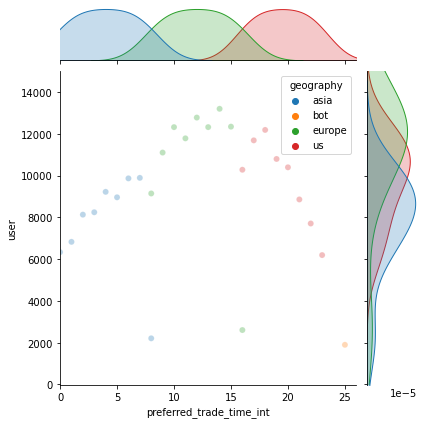

In [90]:
sns.jointplot(data=df_user_hours[df_user_hours.preferred_trade_time_int<30], x='preferred_trade_time_int', y='user',hue='geography', ylim=(-20,15000), xlim=(0,26), alpha=0.3)

## cowswap user wallet analysis

In [354]:
#hourly ETH tx data (limit number of hours by tx_threshold, i.e. only collect past tx_threshold hours of activity (such that total #txs likely <100))
swap_weight = lambda x: np.average(x, weights = df_cowswap_wallets.loc[x.index,'num_txs'])
tx_threshold = 30

for j in range(0,7):
    for num_file in range(0,10):
        cnt = j*10+num_file
        tmp = pd.read_csv('cowswap_topuser_wallet_activity_' +str(cnt) +'.csv')
        tmp['datestr'] = [convert_blocktime(tmp.iloc[i].date_day) for i in range(0,len(tmp))]
        tmp['hour']=[tmp.iloc[i].datestr.hour for i in range(0,len(tmp))]
        tmp['hour_shifted']=tmp['hour']
        tmp.loc[tmp.hour<13,'hour_shifted']=tmp[tmp.hour<13].hour+24
        tmp['hour_12']=tmp['hour']
        tmp.loc[tmp.hour>12,'hour_12']=-1
        tmp['hour_24']=tmp['hour']
        tmp.loc[tmp.hour<13,'hour_24']=24
        tmp['datestr_day']=[tmp.iloc[i].datestr.date() for i in range(0,len(tmp))]
        tmp['rank_tx'] = tmp.groupby('trader')['datestr'].rank(ascending=False)
        tmp=tmp.drop('date_day',axis=1)
        if num_file==0:
            df_cowswap_wallets = tmp[(tmp.rank_tx<tx_threshold)]
        else:
            df_cowswap_wallets=pd.concat([df_cowswap_wallets,tmp[(tmp.rank_tx<tx_threshold)]])
    print(cnt)

    df_cowswap_wallets=df_cowswap_wallets.drop_duplicates(['trader','from_address','to_address','datestr']).reset_index()
    # df_cow_connections = df_cowswap_wallets[['trader','from_address','to_address']].reset_index()
    df_cow_wallets = df_cowswap_wallets[df_cowswap_wallets.trader==df_cowswap_wallets.from_address].groupby('trader').agg(total_volume=('total_volume','mean'),hour_min=('hour','min'),
    hour_max=('hour','max'),
    hour12_max=('hour_12','max'),
    hour24_min=('hour_24','min'),
    hour_cnt=('hour','nunique'),
    hour_mean=('hour','mean'),
    hour_weighted=('hour',swap_weight),
    hour_shifted=('hour_shifted',swap_weight),
    days_min=('datestr','min'),
    days_max=('datestr','max'),
    days_num=('datestr_day','nunique'),
    # from_cnt=('from_address','nunique'),
    to_cnt=('to_address','nunique'),value=('value','sum'),num_txs=('num_txs','sum'), gas_spent=('gas_spent','sum')).reset_index()
    df_cow_wallets['trade_span']=[(df_cow_wallets.hour_max.iloc[i]-df_cow_wallets.hour_min.iloc[i]) for i in range(0,len(df_cow_wallets))]
    df_cow_wallets['days_age']=[int((datetime.datetime.today()-df_cow_wallets.days_min.iloc[i]).days) for i in range(0,len(df_cow_wallets))]
    df_cow_wallets['days_last']=[int((datetime.datetime.today()-df_cow_wallets.days_max.iloc[i]).days) for i in range(0,len(df_cow_wallets))]
    df_cow_wallets['days_active']=[int((df_cow_wallets.days_max.iloc[i]-df_cow_wallets.days_min.iloc[i]).days) for i in range(0,len(df_cow_wallets))]
    df_cow_wallets.loc[df_cow_wallets.hour_shifted>23,'hour_shifted']=np.array(df_cow_wallets[df_cow_wallets.hour_shifted>23].hour_shifted)-24

    if j==0:
        df_cow_all = df_cow_wallets
        # df_cow_all_connections = df_cow_connections
    else:
        df_cow_all = pd.concat([df_cow_all,df_cow_wallets])
        # df_cow_all_connections = pd.concat([df_cow_all_connections ,df_cow_connections])

9
19
29
39
49
59
69


In [355]:
len(df_cow_all)
# tmp['rank_tx'] = tmp.groupby('trader')['datestr'].rank(ascending=False)
# tmp[(tmp.rank_tx<31)].sort_values(by=['trader','datestr'], ascending=False)
# trader_used = df_cowswap_wallets.trader.iloc[0]
# trader_used in list(df_cowswap_wallets[df_cowswap_wallets.trader!=trader_used].from_address.unique())


37163

In [298]:
#identify cowswap wallets that have interaction (so we assume its 1 user)
# dct_out = {
#     'trader':[],
#     'associated_address':[]
# }
cnt=0
for trader in df_cow_all_connections[df_cow_all_connections.trader.isin(df_cow_all[df_cow_all.rank_vol<5000].trader.unique())].trader.unique()[2958:]:
    if cnt%100==0:
        print(cnt/670)
    ass_addr = list(df_cow_all_connections[(df_cow_all_connections.trader!=trader) & (df_cow_all_connections.to_address==trader)].trader.unique())
    dct_out['trader'].append(trader)
    dct_out['associated_address'].append(ass_addr)
    cnt+=1

df_connections = pd.DataFrame.from_dict(dct_out)
df_connections = df_connections.drop_duplicates('trader')
df_connections['multiple_users']=[len(df_connections.iloc[i].associated_address) for i in range(0,len(df_connections))]



0.0
0.14925373134328357
0.29850746268656714
0.44776119402985076
0.5970149253731343
0.746268656716418
0.8955223880597015
1.044776119402985
1.1940298507462686
1.3432835820895523
1.492537313432836
1.6417910447761195
1.791044776119403
1.9402985074626866
2.08955223880597
2.2388059701492535
2.388059701492537
2.537313432835821
2.6865671641791047
2.8358208955223883
2.985074626865672


In [1071]:
#assign user id to user based on above
df_cow_users['user_id']=0
for i in range(1,len(df_cow_users)+1):
    trader_used = df_cow_users.trader.iloc[i-1]
    if df_cow_users[df_cow_users.trader==trader_used].user_id.iloc[0]==0:
        df_cow_users.loc[df_cow_users.trader==trader_used,'user_id']=i
        if len(df_connections[df_connections.trader==trader_used])>0:
            if df_connections[(df_connections.trader==trader_used)].iloc[0].multiple_users>0:
                print(i)
                print('-------------------------------------')
                for assoc_wallet in df_connections[(df_connections.trader==trader_used)].iloc[0].associated_address:
                    print(assoc_wallet)
                    df_cow_users.loc[(df_cow_users.trader==assoc_wallet),'user_id']=i

4
-------------------------------------
\x105f96c0c874df7720ad8dc7d5907f1a38c1490f
\x69c7ba5f942708cacc7cf4a39fbaea78db2c561f
9
-------------------------------------
\xd9c5e6ab5c9eb051108faf14438a4ecc4441d829
12
-------------------------------------
\xd1bda2c21d73ee31a0d3fdcd64b0d7c4bce6d021
13
-------------------------------------
\x23237b849d0e6f392573ee6ae9e3b1256f058143
18
-------------------------------------
\x16a032cf72857a5cf40b214c71a4bb94ce26939d
\xdc6953c238c4ffff57d7c16ac32bc716f7074e3a
19
-------------------------------------
\x28ef525eeaa695a999640ceda499f8f01af12742
21
-------------------------------------
\xa303bb97df6a9be03e81c170142e2c5a57088249
25
-------------------------------------
\x733428f811d11940ed1168dcc57e21a5660c8f68
30
-------------------------------------
\xf00b8484c9b78136c6ae8773223cff9be7a3af45
\x5ed64f02588c8b75582f2f8efd7a5521e3f897cc
31
-------------------------------------
\xbdd7ef6117c2a300d4d14b1e4c05f00bebf18045
32
------------------------------

In [801]:
df_cow_user_wallets=df_cow_users.groupby('user_id').agg(num_wallets=('trader','nunique'),total_volume=('total_volume','sum')).reset_index()

In [808]:
df_cow_users[df_cow_users.user_id==0]

Empty DataFrame
Columns: [trader, total_swaps, swaps_90d, swaps_180d, total_volume, volume_90d, volume_180d, day_first, day_last, volume_per_day, avg_num_trades, num_batches, avg_volume, sum_volume, avg_dex_swaps, sum_fees, avg_fees, sum_cost, avg_cost, cost_coverage, avg_num_trades_90d, num_batches_90d, avg_volume_90d, sum_volume_90d, avg_dex_swaps_90d, sum_fees_90d, avg_fees_90d, sum_cost_90d, avg_cost_90d, cost_coverage_90d, avg_num_trades_180d, num_batches_180d, avg_volume_180d, sum_volume_180d, avg_dex_swaps_180d, sum_fees_180d, avg_fees_180d, sum_cost_180d, avg_cost_180d, cost_coverage_180d, share_vol_90d, share_swaps_90d, rank_vol_90d, rank_swaps_90d, avg_trade_size_90d, share_vol_180d, share_swaps_180d, rank_vol_180d, rank_swaps_180d, avg_trade_size_180d, share_vol, share_swaps, cs_share_vol, cs_share_swaps, rank_vol, rank_swaps, avg_trade_size, rank_grp, days_active, status, user_id]
Index: []

[0 rows x 61 columns]

In [773]:
df_cow_user_wallets['share_vol']=df_cow_user_wallets.total_volume/sum(df_cow_user_wallets.total_volume)

258

In [502]:
df_cow_users_2.keys()

Index(['trader', 'total_swaps', 'swaps_90d', 'total_volume_x', 'volume_90d',
       'day_first', 'day_last', 'volume_per_day', 'avg_num_trades',
       'num_batches', 'avg_volume', 'sum_volume', 'avg_dex_swaps', 'sum_fees',
       'avg_fees', 'sum_cost', 'avg_cost', 'cost_coverage',
       'avg_num_trades_90d', 'num_batches_90d', 'avg_volume_90d',
       'sum_volume_90d', 'avg_dex_swaps_90d', 'sum_fees_90d', 'avg_fees_90d',
       'sum_cost_90d', 'avg_cost_90d', 'cost_coverage_90d', 'share_vol',
       'share_swaps', 'cs_share_vol', 'cs_share_swaps', 'rank_vol_x',
       'rank_swaps', 'avg_trade_size', 'rank_grp', 'days_active_x', 'status',
       'user_id', 'total_volume_y', 'hour_min', 'hour_max', 'hour12_max',
       'hour24_min', 'hour_cnt', 'hour_mean', 'hour_weighted', 'hour_shifted',
       'days_min', 'days_max', 'days_num', 'to_cnt', 'value', 'num_txs',
       'gas_spent', 'trade_span', 'days_age', 'days_last', 'days_active_y',
       'rank_vol_y', 'preferred_trade_time', 'txs

In [326]:
# swap_weight_shift = lambda x: np.average(x, weights = df_cowswap_wallets.loc[x.index,'num_txs'])
# df_cowswap_wallets['hour_12']=df_cowswap_wallets['hour']
# df_cowswap_wallets.loc[df_cowswap_wallets.hour>12, 'hour_12']=-1
# df_cowswap_wallets['hour_24']=df_cowswap_wallets['hour']
# df_cowswap_wallets.loc[df_cowswap_wallets.hour<13, 'hour_24']=24
# df_cowswap_wallets['hour_shifted']=df_cowswap_wallets['hour']
# df_cowswap_wallets.loc[df_cowswap_wallets.hour<13,'hour_shifted']=df_cowswap_wallets[df_cowswap_wallets.hour<13].hour+24

# test = df_cowswap_wallets.groupby('trader').agg(total_volume=('total_volume','mean'),
#     hour_min=('hour','min'),
#     hour_max_12=('hour_12','max'),
#     hour_min_24=('hour_24','min'),
#     hour_max=('hour','max'),
#     hour_cnt=('hour','nunique'),
#     hour_mean=('hour','mean'),
#     hour_weighted=('hour',swap_weight),
#     hour_weighted_shift=('hour_shifted',swap_weight_shift),
#     days_min=('datestr','min'),
#     days_max=('datestr','max'),
#     days_num=('datestr_day','nunique'),
#     from_cnt=('from_address','nunique'),to_cnt=('to_address','nunique'),value=('value','sum'),num_txs=('num_txs','sum'), gas_spent=('gas_spent','sum')).reset_index()

test.hour_weighted_shift=test.hour_weighted_shift
test.loc[test.hour_weighted_shift>23,'hour_weighted_shift']=np.array(test[test.hour_weighted_shift>23].hour_weighted_shift)-24

In [327]:
test[(test.hour_max>21) & (test.hour_min<5) & (test.hour_cnt<10)].head()

# test.head()

trader  total_volume  hour_min  \
13   \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084         0   
50   \x00c0de00b4c1e87b765cd4bbaed23541c980069e   2652.913825         0   
117  \x02c5cccd21e0099a76b644214dc4f2ad450656f2   2633.785093         2   
144  \x03a2a013ee78ae7631170ac343ec31d4833c54bb  10585.311584         2   
149  \x03af7a3a9eb51d004fdad2945dca44ce3f07bfa6   2224.449785         1   

     hour_max_12  hour_min_24  hour_max  hour_cnt  hour_mean  hour_weighted  \
13             5           14        23         6  10.562500      10.684211   
50            11           13        23         5  10.000000      10.300000   
117            3           13        23         7  13.730769      14.366667   
144           12           16        23         7  12.666667      13.857143   
149           12           13        23         9  17.800000      18.166667   

     hour_weighted_shift            days_min            days_max  days_num  \
13             20.789474 2021-04-10 14:00:00 2022-09-03 16:00:00         5   
50             19.900000 2021-05-25 13:00:00 2022-05-19 00:00:00         6   
117            20.766667 2021-06-15 13:00:00 2022-07-25 03:00:00        10   
144            22.428571 2022-04-15 02:00:00 2022-07-10 17:00:00         4   
149            20.166667 2021-11-12 23:00:00 2022-02-04 01:00:00         9   

     from_cnt  to_cnt       value  num_txs     gas_spent  
13          4      10    3.727542       19  2.740100e-12  
50          2       6    0.504258       10  9.477000e-13  
117         4      15  270.370537       30  4.360600e-12  
144         2       7    5.063637       14  1.393200e-12  
149         3      17    2.488586       24  2.285200e-12

In [317]:
df_cowswap_wallets[df_cowswap_wallets.trader=='\\x0018c9afb699bff116a46ccac5307096a386dcfe']

index                                      trader  total_volume  \
1066613   7158  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066614   7159  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066615   7160  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066616   7161  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066617   7162  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066618   7163  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066619   7164  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066620   7165  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066621   7166  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066622   7167  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066623   7168  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066624   7169  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066625   7170  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066626   7171  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066627   7172  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   
1066628   7173  \x0018c9afb699bff116a46ccac5307096a386dcfe   3706.396084   

                                       from_address  \
1066613  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066614  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066615  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066616  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066617  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066618  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066619  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066620  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066621  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066622  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066623  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066624  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066625  \x0018c9afb699bff116a46ccac5307096a386dcfe   
1066626  \x2a0488cd71d1111c74c4183ef54baf015f2bcbe5   
1066627  \xc3963f44731da82a2c29cf4c27aed4eadf917253   
1066628  \xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98   

                                         to_address     value     gas_spent  \
1066613  \x2a0488cd71d1111c74c4183ef54baf015f2bcbe5  0.412831  2.100000e-14   
1066614  \x2b591e99afe9f32eaa6214f7b7629768c40eeb39  0.000000  6.370000e-14   
1066615  \x2b591e99afe9f32eaa6214f7b7629768c40eeb39  0.000000  4.650000e-14   
1066616  \x3819f64f282bf135d62168c1e513280daf905e06  0.000000  2.960000e-14   
1066617  \x7a250d5630b4cf539739df2c5dacb4c659f2488d  0.000000  2.416000e-13   
1066618  \xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48  0.000000  4.980000e-14   
1066619  \xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48  0.000000  4.370000e-14   
1066620  \xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48  0.000000  6.030000e-14   
1066621  \xadb0739822374a05653f513683ddbeba3cc81f2e  0.000000  6.584000e-13   
1066622  \xc3963f44731da82a2c29cf4c27aed4eadf917253  1.279118  4.200000e-14   
1066623  \xdef1c0ded9bec7f1a1670819833240f027b25eff  0.243018  1.167300e-12   
1066624  \xdef1c0ded9bec7f1a1670819833240f027b25eff  0.000000  2.322000e-13   
1066625  \xe51917d02e62153dff05a736714fcc628c132f2b  0.400000  2.100000e-14   
1066626  \x0018c9afb699bff116a46ccac5307096a386dcfe  0.050000  2.100000e-14   
1066627  \x0018c9afb699bff116a46ccac5307096a386dcfe  0.020000  2.100000e-14   
1066628  \x0018c9afb699bff116a46ccac5307096a386dcfe  1.322576  2.100000e-14   

         num_txs             datestr  hour  hour_shifted datestr_day  hour_12  \
1066613        1 2022-08-22 00:00:00     0            24  2022-08-22        0   
1066614        2 2021-04-10 14:00:00    14            14  2021-04-10       -1   
1066615        1 2022-08-21 23:00:00    23            23  2022-08-21       -1   
1066616        1 2022-09-03 16:00:00    16            16  2022-09-03       -1   
1066617        1 2021-04-10 14:

In [ ]:
trader_used in list(df_cowswap_wallets[df_cowswap_wallets.trader!=trader_used].from_address.unique())

In [498]:
df_cow_all['txs_per_day'] = df_cow_all['num_txs']/df_cow_all.days_active
df_cow_all['rank_vol'] = df_cow_all.total_volume.rank(ascending=False)
df_cow_all['trade_span_outer'] = df_cow_all.hour12_max + 24 -  df_cow_all.hour24_min

In [827]:
# df_connections.to_pickle('df_connections.pkl')
# df_cow_all = pd.read_pickle('df_cow_all_30d.pkl')
# df_cow_all_full = pd.read_pickle('df_cow_all_0908.pkl')
df_cow_all_full.head()

trader  total_volume  hour_min  \
0  \x000000000057e8abd581828a2b40076852c0ba6e  3.135143e+04         0   
1  \x00000000005ef87f8ca7014309ece7260bbcdaeb  1.268941e+06         0   
2  \x0000000484f2217f1a64eb6d24b5cee446faeae5  1.126296e+06         0   
3  \x00000029ff545c86524ade7caf132527707948c4  7.165732e+06         0   
4  \x00000639caea2f4991b946c1f68686e4df700000  4.367173e+06         0   

   hour_max  hour12_max  hour24_min  hour_cnt  hour_mean  hour_weighted  \
0        23          12          13        24  13.661053      13.762063   
1        23          12          13        24  10.720588      10.545064   
2        23          12          13        24  13.742537      13.783891   
3        22          12          13        22   8.640351       8.592366   
4        23          12          13        24  12.163842      11.615899   

   hour_shifted  ... to_cnt         value  num_txs     gas_spent  trade_span  \
0      0.863561  ...     88     32.525595      601  2.058935e-10          23   
1      0.579399  ...    183   1359.446967      932  1.474061e-10          23   
2     22.542773  ...    496  74266.322790     5798  9.068429e-10          23   
3      2.400000  ...    161   2428.251659      655  7.978930e-11          22   
4      0.935364  ...     34    769.367150     1346  1.060434e-09          23   

   days_age  days_last  days_active  txs_per_day  rank_vol  
0       577         73          503     1.194831   13642.5  
1       358          8          350     2.662857    1404.0  
2      1655          6         1649     3.516070    1528.0  
3       627         48          579     1.131261     295.0  
4       347          2          344     3.912791     478.0  

[5 rows x 23 columns]

In [829]:
#which inactive cow wallets are still active?

len(df_cow_users_2[(df_cow_users_2.status=='inactive') & (df_cow_users_2.trader.isin(df_cow_all_full[df_cow_all_full.days_last>180].trader.unique()))])/len(df_cow_users_2)
#  df_cow_all_full.head()

0.07455974385096784

In [2365]:
get_preferred_trade_time(df_cow_all, swap_col='num_txs', has_age_col=1,age_col='days_age', active_col='days_active', last_tx_col='days_last')
get_geographies(df_cow_all)

In [2366]:
df_cow_all.groupby('geography').agg({'trader':'nunique'})

trader
geography                        
active >12 distinct hours    8024
asia                         7070
europe                      12248
unknown                      2665
us                           6494
wallet >1y inactive           165

In [500]:
len(df_cow_all[(df_cow_all.geography=='unknown') ])/len(df_cow_all)

0.042542313591475395

In [235]:
df_cow_users['clean_address']=[df_cow_users.trader.iloc[i].replace('\\x','0x') for i in range(0,len(df_cow_users))]

In [237]:
df_cow_users.sort_values(by='rank_vol').clean_address.to_csv('cow_trader_092022.csv')

In [125]:


df_cow_hours = df_cowswap_wallets.groupby(['trader','hour']).agg(total_volume=('total_volume','mean'),from_cnt=('from_address','nunique'),
to_cnt=('to_address','nunique'),value=('value','sum'),
num_txs=('num_txs','sum'),
gas_spent=('gas_spent','sum')).reset_index()
df_cow_hours['hours_weighted']=df_cow_hours

15.062568648476528

In [369]:
df_cow_all[df_cow_all.geography=='unknown'].head()

trader  total_volume  hour_min  \
0  \x000000000057e8abd581828a2b40076852c0ba6e  3.135143e+04         8   
3  \x00000029ff545c86524ade7caf132527707948c4  7.165732e+06         4   
5  \x000b79f52356189c80a9d3ada3911d4438218516  1.044792e+06         4   
6  \x002ee33092457900515a4249e3ec1cd2b2dc8c32  1.057285e+06         6   
7  \x0039f22efb07a647557c7c5d17854cfd6d489ef3  2.015913e+06         0   

   hour_max  hour12_max  hour24_min  hour_cnt  hour_mean  hour_weighted  \
0        23          12          14        12  15.965517      15.500000   
3        18          12          13        12  12.000000      11.896552   
5        22           8          15        12  12.062500      11.848485   
6        22           8          15         9  15.500000      14.270270   
7        23           9          17        11  14.000000      15.500000   

   hour_shifted  ... num_txs     gas_spent  trade_span  days_age  days_last  \
0      2.794118  ...      34  5.890300e-12          15       256         73   
3      0.310345  ...      29  3.397700e-12          14       159         48   
5      0.939394  ...      33  2.360100e-12          18       240         98   
6     22.702703  ...      37  8.929000e-12          16        38          6   
7     22.700000  ...      30  2.812200e-12          23        98          8   

   days_active  rank_vol  trade_span_outer  preferred_trade_time  geography  
0          182   13641.5                22             15.500000    unknown  
3          110     295.0                23             11.896552    unknown  
5          141    1612.0                17             11.848485    unknown  
6           31    1599.0                17             14.270270    unknown  
7           89     946.0                16             15.500000    unknown  

[5 rows x 25 columns]

In [338]:
len(df_cow_all[(df_cow_all.geography=='unknown')])/len(df_cow_all)

0.15226282085777323

In [339]:
df_cow_all[(df_cow_all.geography=='unknown')&(df_cow_all.hour_min==0) & (df_cow_all.hour_max>20)]

trader  total_volume  hour_min  \
45    \x039b9f3f7be061c5a3f1e0d01e2eb82477a79c8a  9.920995e+05         0   
46    \x03a94b4b5813c804c94181c4d2129bde61efafd9  1.791437e+06         0   
132   \x0d57dca1b658da56fabc86d94a08ba07557c2a08  3.259130e+04         0   
141   \x0e46e528841373b9d5e98ee8e83ad7910c82df5e  1.954142e+06         0   
161   \x0fe494a5e8f785d3bb37133d681571904ebe5658  1.801541e+06         0   
...                                          ...           ...       ...   
9767  \xfb9626f24fd3f8e2f6f444453f6f9b6aa7fe345a  2.634675e+03         0   
9784  \xfbf70836f9c4cc8e7558fb7c30f7adf5c1589b40  9.338728e+03         0   
9897  \xfe98b3562d97ea33e78e90689d3c40f1af75a62a  2.629678e+03         0   
9933  \xff895724a81868c84a55a963f0e52a8dc9c2f721  1.057855e+04         0   
9934  \xff8bd12e56c825b38a41e49e2442bcd438f96bb0  1.094906e+04         0   

      hour_max  hour12_max  hour24_min  hour_cnt  hour_mean  hour_weighted  \
45          23           9          14         9  10.411765      10.210526   
46          23           4          17        10  14.241379      13.718750   
132         23           6          14        12  11.692308      11.511111   
141         23           4          13        12  15.100000      15.411765   
161         21          12          15        10  15.136364      15.724138   
...        ...         ...         ...       ...        ...            ...   
9767        22          12          13        12  12.655172      12.531250   
9784        23           4          13        11  12.086957      11.821429   
9897        23          12          13        11  11.476190      13.750000   
9933        23          11          15         7  16.307692      16.100000   
9934        23          12          13        16  16.139535      14.831933   

      hour_shifted  ... num_txs     gas_spent  trade_span  days_age  \
45       22.842105  ...      19  2.286700e-12          23       253   
46       -0.531250  ...      32  4.417700e-12          23       478   
132      22.177778  ...      45  5.518900e-12          23       576   
141      21.058824  ...      34  2.263500e-12          23       332   
161      22.344828  ...      29  1.636600e-12          21       351   
...            ...  ...     ...           ...         ...       ...   
9767     22.281250  ...      32  2.503400e-12          22       290   
9784     22.964286  ...      28  3.076100e-12          23       539   
9897     20.840909  ...      44  2.313190e-11          23       478   
9933     -0.700000  ...      20  3.172900e-12          23       354   
9934     19.268908  ...     119  1.213880e-11          23      1684   

      days_last  days_active  txs_per_day  rank_vol  preferred_trade_time  \
45           69          183     0.103825    1689.0             10.210526   
46           81          396     0.080808    1048.0             13.718750   
132          30          546     0.082418   13262.5             11.511111   
141          86          246     0.138211     967.0             15.411765   
161         298           53     0.547170    1044.0             15.724138   
...         ...          ...          ...       ...                   ...   
9767          0          290     0.110345   33451.0             12.531250   
9784        144          395     0.070886   22053.0             11.821429   
9897        358          119     0.369748   33469.0             13.750000   
9933        135          218     0.091743   20800.0             16.100000   
9934        247         1436     0.082869   20517.0             14.831933   

      geography  
45      unknown  
46      unknown  
132     unknown  
141     unknown  
161     unknown  
...         ...  
9767    unknown  
9784    unknown  
9897    unknown  
9933    unknown  
9934    unknown  

[1721 rows x 25 columns]

Text(0.5, 44.019999999999854, 'weighted avg. transaction time (UTC)')

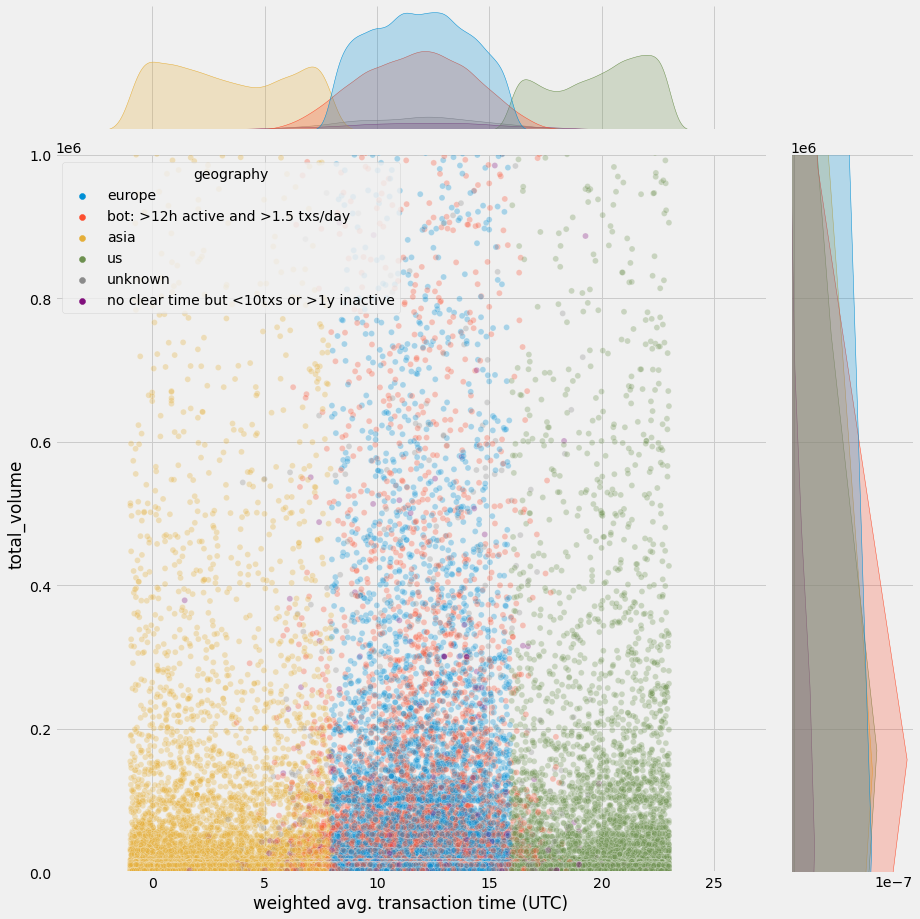

In [404]:

g=sns.jointplot(data=df_cow_all.reset_index(), x='preferred_trade_time', y='total_volume',hue='geography',
ylim=(0,1000000),
height=13,
alpha=0.3)
g.ax_joint.set_xlabel('weighted avg. transaction time (UTC)')

## cluster approach

In [972]:
   from kneed import KneeLocator
   from sklearn.datasets import make_blobs
   from sklearn.cluster import KMeans
   from sklearn.metrics import silhouette_score
   from sklearn.preprocessing import StandardScaler

In [1003]:
# features = df_cow_all[['total_volume',
#        # 'hour_min','hour_max',
#               'hour_cnt','hour_mean','hour_weighted','days_num',
#        # 'from_cnt', 'to_cnt', 'value', 
#        'num_txs',
#        #  'gas_spent',
#         'days_age',
#        # 'days_last', 'days_active', 
#        # 'trade_span'
#        ]]
# labels = df_cow_all.trader
df_chart

level_0  index  user_id  total_volume  total_swaps     share_vol  \
0            0      0        1  6.780505e+08          295  4.473326e-02   
1            1      1        2  1.627307e+08          161  1.073589e-02   
2            2      2        3  1.091276e+08          143  7.199515e-03   
9            9      9       12  1.154358e+08           10  7.615684e-03   
98          98     98      110  1.982326e+08          153  1.307807e-02   
...        ...    ...      ...           ...          ...           ...   
29427    29427  29427    31038  2.030077e+03            1  1.339310e-07   
29428    29428  29428    31039  2.441383e+05            4  1.610662e-05   
29429    29429  29429    31040  3.780830e+02            1  2.494340e-08   
29430    29430  29430    31041  5.632499e+02            1  3.715948e-08   
64880    64880  64880    68213  1.668880e+03            1  1.101016e-07   

       share_swaps  days_active_cow  days_active_eth    avg_fees  \
0         0.000797            231.0             15.0  108.797284   
1         0.000435            111.0             14.0   21.205363   
2         0.000386            121.0             22.0   25.820571   
9         0.000027             67.0            327.5  327.477822   
98        0.000413            151.0             81.5  103.743504   
...            ...              ...              ...         ...   
29427     0.000003              0.0            177.0         NaN   
29428     0.000011            103.0             46.0  144.343092   
29429     0.000003              0.0              NaN         NaN   
29430     0.000003              0.0              NaN         NaN   
64880     0.000003              0.0              NaN         NaN   

           sum_fees    avg_cost      sum_cost  avg_cost_coverage  num_trader  \
0      31877.604262   83.417961  24441.462501           1.304243           1   
1       3414.063457   24.459848   3938.035593           0.866946           1   
2       3692.341641   27.474031   3928.786436           0.939817           1   
9       3847.935857  255.731246   3152.395785           1.336748           2   
98     23266.095812  111.507296  27623.670829           1.169674           2   
...             ...         ...           ...                ...         ...   
29427      0.000000         NaN      0.000000                NaN           1   
29428    577.372369  164.928046    659.712184           0.875188           1   
29429      0.000000         NaN      0.000000                NaN           1   
29430      0.000000         NaN      0.000000                NaN           1   
64880      0.000000         NaN      0.000000                NaN           1   

       num_user  day_first  day_last  share_fees  share_cost  cost_coverage  \
0             1        237         6    0.001596    0.000959       1.304243   
1             1        111         0    0.000171    0.000155       0.866946   
2             1        122         1    0.000185    0.000154       0.939817   
9             1         84        73    0.000193    0.000124       1.220639   
98            1         82        71    0.001165    0.001084       0.842252   
...         ...        ...       ...         ...         ...            ...   
29427         1        181       181    0.000000    0.000000            NaN   
29428         1        327       224    0.000029    0.000026       0.875188   
29429         1        257       257    0.000000    0.000000            NaN   
29430         1        211       211    0.000000    0.000000            NaN   
64880         1        277       277    0.000000    0.000000            NaN   

       share_trader  swaps_90d    volume_90d  avg_fees_90d  sum_fees_90d  \
0          0.000015        238  5.340624e+08     78.250982  18467.231777   
1          0.000015        158  1.600072e+08     20.547366   3246.483770   
2          0.000015        128  9.731052e+07     24.956148   3194.386881   
9          0.000029          7  8.712710e+07    211.454097   1418.686326   

In [1177]:
features = df_cowswap_by_user[~(df_cowswap_by_user.cost_coverage_90d.isna())][['volume_90d','swaps_90d','cost_coverage_90d']]
#        # 'hour_min','hour_max',
#               'hour_cnt','hour_mean','hour_weighted','days_num',
#        # 'from_cnt', 'to_cnt', 'value', 
#        'num_txs',
#        #  'gas_spent',
#         'days_age',
#        # 'days_last', 'days_active', 
#        # 'trade_span'
#        ]]
labels = df_cowswap_by_user[~(df_cowswap_by_user.cost_coverage_90d.isna())].user_id

In [1080]:
scaler = StandardScaler()

In [1178]:
scaled_features = pd.DataFrame(scaler.fit_transform(features))
scaled_features.columns=features.keys()

In [1082]:
len(scaled_features[scaled_features.cost_coverage_90d.isna()])

0

In [1179]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = []
krange=range(3,10)
for k in krange:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

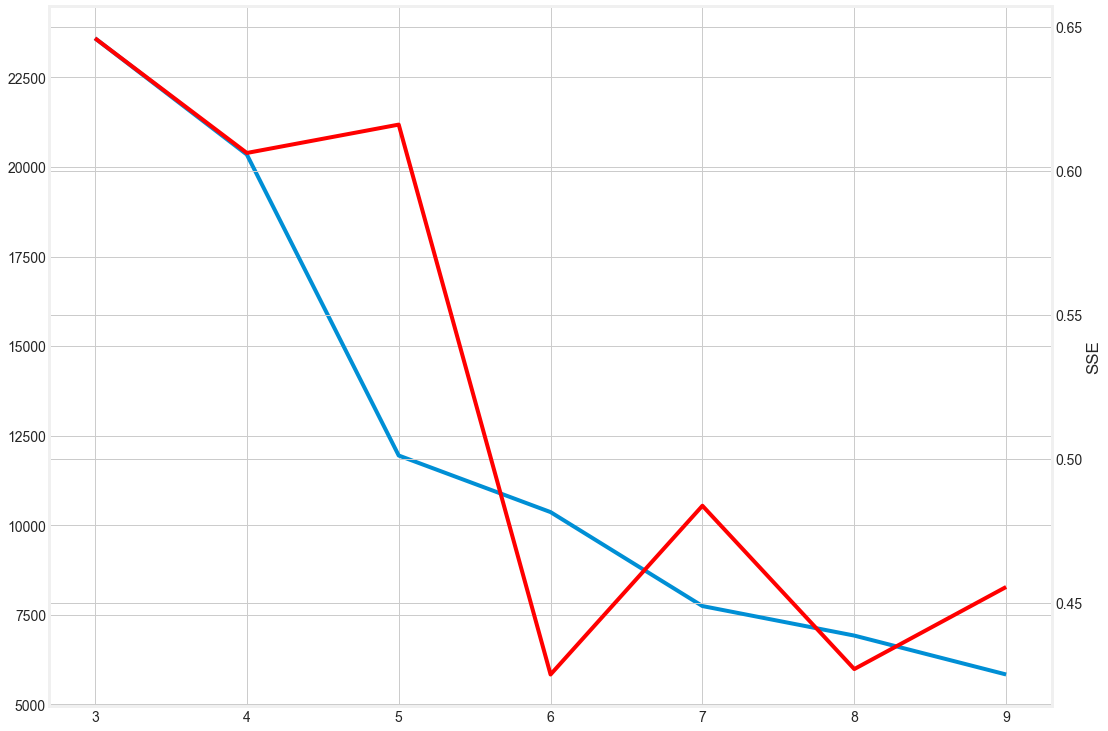

In [1180]:
fig, axs = mp.subplots(figsize=(16,12))
mp.style.use("fivethirtyeight")
axs.plot(krange, sse)
ax2=axs.twinx()
ax2.plot(krange, silhouette_coefficients, color='r')
# mp.xticks(range(1, 11))
mp.xlabel("Number of Clusters")
mp.ylabel("SSE")

In [1181]:
kl = KneeLocator(krange, sse, curve="convex", direction="decreasing")

kl.elbow

5

In [1182]:
k=6
kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
kmeans.fit(scaled_features)
kmeans_silhouette = silhouette_score(
   scaled_features, kmeans.labels_
   ).round(2)
scaled_features['cluster']=kmeans.predict(scaled_features)

In [1107]:
from sklearn.manifold import MDS
import seaborn as sns

embedding = MDS(n_components=2)
mds = pd.DataFrame(embedding.fit_transform(scaled_features.drop('cluster',axis=1)),
             columns = ['dim1','dim2'])
mds['cluster'] = kmeans.predict(scaled_features.drop('cluster',axis=1))

sns.scatterplot(data=mds,x = "dim1",y="dim2",hue="cluster")

KeyboardInterrupt: 

array([3, 2, 2, ..., 4, 0, 1], dtype=int32)

In [1183]:
df_cluster_all=scaled_features.merge(features, how='inner', left_index=True, right_index=True)

In [1052]:
# labels
df_cluster_all

volume_90d_x  swaps_90d_x  cost_coverage_90d_x  cluster  volume_90d_y  \
0        54.359781     7.944543             0.546540        3  5.340624e+08   
1        16.222081     5.136309            -0.454083        2  1.600072e+08   
2         9.829688     4.083222            -0.266661        2  9.731052e+07   
3         7.436410     0.081490             0.104765        4  7.383721e+07   
4         7.050346    -0.269540            -0.535549        4  7.005069e+07   
...            ...          ...                  ...      ...           ...   
3794     -0.091837    -0.374848             0.899803        0  1.684138e+04   
3798     -0.091838    -0.374848            -0.562557        4  1.676489e+04   
3808     -0.091840    -0.374848            -1.170645        4  1.650859e+04   
3809     -0.091840    -0.374848             0.458782        0  1.649679e+04   
3812     -0.091841    -0.374848             0.608089        0  1.645201e+04   

      swaps_90d_y  cost_coverage_90d_y  
0             238             1.320652  
1             158             0.858382  
2             128             0.944968  
3              14             1.116560  
4               4             0.820746  
...           ...                  ...  
3794            2             0.999675  
3798            7             0.897925  
3808           14             0.732623  
3809            3             0.747890  
3812            1             1.012355  

[2805 rows x 7 columns]

In [1088]:
for i in df_cluster_all.cluster.unique():
    print(str(i)+':' + str(len(df_cluster_all[df_cluster_all.cluster==i])))

4:1
2:48
0:4204
5:6817
3:494
1:2


Text(0, 0.5, '')

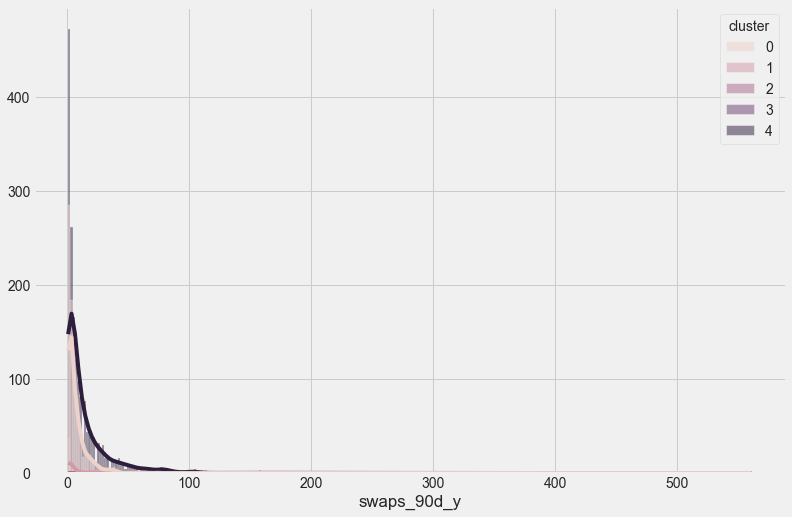

In [1047]:
f_lst=[ str(features.keys()[i]) + '_y' for i in range(0,len(features.keys()))]
# ['total_volume_y', 'hour_min_y', 'hour_max_y', 'hour_mean_y',
#        'hour_weighted_y', 'days_num_y', 'num_txs_y', 'gas_spent_y',
#        'days_age_y', 'days_last_y', 'days_active_y', 'trade_span_y']
fig, axs = mp.subplots(figsize=(12,8))

# for i in range(0,3):
    # for j in range(0,4):
# cnt = i*4+j
cnt=1
sns.histplot(data=df_cluster_all, x=f_lst[cnt], hue='cluster', kde=True)
# legend = axs.legend()
# legend.remove()
# axs[i,j].set_ylabel('')
mp.ylabel('')
# mp.title(f_lst[cnt])


In [82]:
features.keys()

Index(['total_volume', 'hour_cnt', 'hour_mean', 'hour_weighted', 'days_num',
       'num_txs', 'days_age'],
      dtype='object')

In [1184]:
df_cowswap_by_user['cluster']=7
df_cowswap_by_user.loc[(df_cowswap_by_user.cost_coverage_90d.isna()) & (df_cowswap_by_user.volume_90d==0) ,'cluster']=6
df_cowswap_by_user.loc[~(df_cowswap_by_user.cost_coverage_90d.isna()),'cluster'] = kmeans.labels_

# Stickyness

In [2097]:
projects = ['cowswap','1inch','zerox','balancer','matcha', 'sushiswap','curve','dodo']
cnt = 0
for p in projects:
    tmp = pd.read_csv('retention_input/weekly_stickyness_'  + p + '.csv')
    tmp['project']=p
    if cnt==0:
        df_stick_all=tmp
    else:
        df_stick_all=pd.concat([df_stick_all,tmp])
    cnt+=1
    

add_datestr_col(df_stick_all,'day')

In [2098]:
df_stick_all=df_stick_all.reset_index()

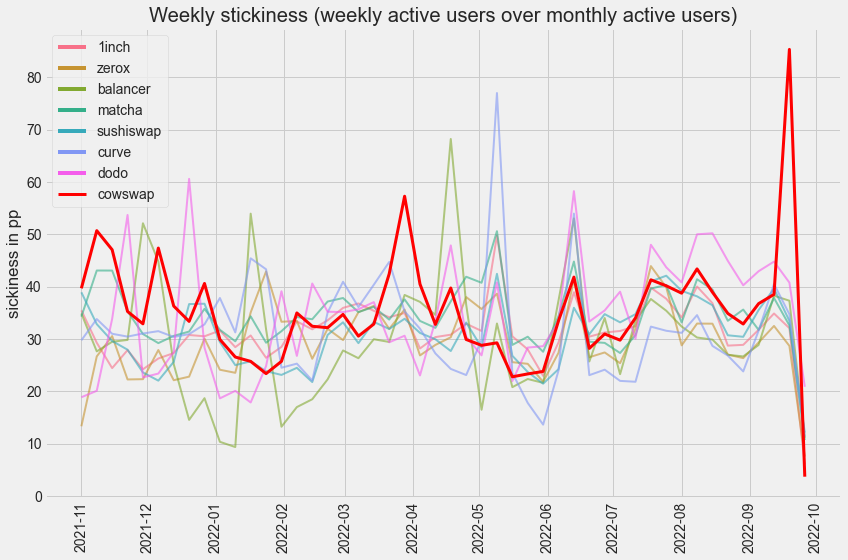

In [2243]:
fig, axs=mp.subplots(figsize=(12,8))
sns.lineplot(data=df_stick_all[df_stick_all.project!='cowswap'], x='datestr', y='stickiness', hue='project', linewidth=2, ax=axs, alpha=0.6)
sns.lineplot(data=df_stick_all[df_stick_all.project=='cowswap'], x='datestr', y='stickiness', linewidth=3, color='r', ax=axs, label='cowswap')
axs.tick_params(axis='x',rotation=90)
axs.set_xlabel('')
axs.set_ylabel('sickiness in pp')
axs.set_title('Weekly stickiness (weekly active users over monthly active users)')
fig.tight_layout()
fig.savefig('charts/weekly_stickiness.png')

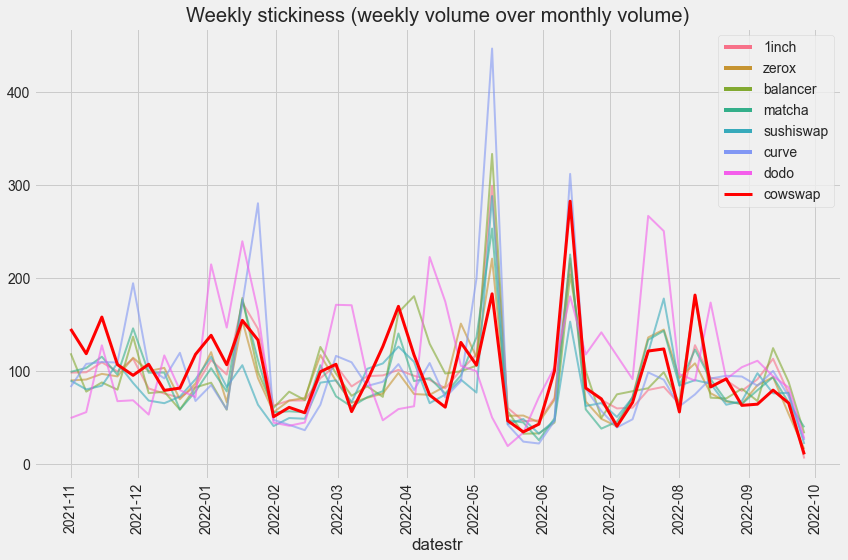

In [2242]:
fig, axs=mp.subplots(figsize=(12,8))
ycol = 'stickiness_volume'
sns.lineplot(data=df_stick_all[df_stick_all.project!='cowswap'], x='datestr', y=ycol, hue='project', linewidth=2, ax=axs, alpha=0.6)
sns.lineplot(data=df_stick_all[df_stick_all.project=='cowswap'], x='datestr', y=ycol, linewidth=3, color='r', ax=axs, label='cowswap')
axs.tick_params(axis='x',rotation=90)
axs.set_ylabel('')
axs.set_title('Weekly stickiness (weekly volume over monthly volume)')
fig.tight_layout()
fig.savefig('charts/weekly_stickiness_volume.png')

# API calls

In [1606]:
from duneanalytics import DuneAnalytics

# initialize client
dune = DuneAnalytics('robko', 'HWDPW2yKL7FMXR!qXDPz')

# try to login
dune.login()

# fetch token
dune.fetch_auth_token()

# fetch query result id using query id
# query id for any query can be found from the url of the query:
# for example: 
# https://dune.com/queries/4494/8769 => 4494
# https://dune.com/queries/3705/7192 => 3705
# https://dune.com/queries/3751/7276 => 3751

# data = dune.query_result(query = '''SELECT 
#     count(distinct trader_a) as num_users,
#     count(*) as num_swaps,
#     -- count(distinct trader_a) as num_traders,
#             SUM(usd_amount) as usd_volume                                                                             
#     FROM dex."trades" t                                                                             
#     WHERE block_time > '2022-09-01'
#     and project in ['1inch','1inch LP','1inch Limit Order Protocol']
#     ''')
result_id = dune.query_result_id(query_id=1185063)

# fetch query result
data = dune.query_result(result_id)

In [1604]:
pd.DataFrame.from_dict(data['data']['get_result_by_result_id'])

data           __typename
0  {'date': '2021-12-01T00:00:00+00:00', 'total_v...  get_result_template
1  {'date': '2022-01-01T00:00:00+00:00', 'total_v...  get_result_template
2  {'date': '2022-02-01T00:00:00+00:00', 'total_v...  get_result_template
3  {'date': '2022-03-01T00:00:00+00:00', 'total_v...  get_result_template
4  {'date': '2022-04-01T00:00:00+00:00', 'total_v...  get_result_template
5  {'date': '2022-05-01T00:00:00+00:00', 'total_v...  get_result_template
6  {'date': '2022-06-01T00:00:00+00:00', 'total_v...  get_result_template
7  {'date': '2022-07-01T00:00:00+00:00', 'total_v...  get_result_template
8  {'date': '2022-08-01T00:00:00+00:00', 'total_v...  get_result_template
9  {'date': '2022-09-01T00:00:00+00:00', 'total_v...  get_result_template

In [1608]:
data['data']['get_result_by_result_id']

[{'data': {'block_time': '2022-09-01T00:00:03+00:00',
   'category': 'DEX',
   'evt_index': 10,
   'exchange_contract_address': '\\x82dbc2673e9640343d263a3c55de49021ad39ae2',
   'project': 'Sushiswap',
   'token_a_address': '\\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
   'token_a_amount': 7.25709002805656,
   'token_a_amount_raw': 7257090028056561264,
   'token_a_symbol': 'WETH',
   'token_b_address': '\\x1559fa1b8f28238fd5d76d9f434ad86fd20d1559',
   'token_b_amount': 104208.335730957,
   'token_b_amount_raw': 104208335730956829645491,
   'token_b_symbol': 'EDEN',
   'trace_address': [],
   'trade_id': 1,
   'trader_a': '\\x56178a0d5f301baf6cf3e1cd53d9863437345bf9',
   'trader_b': None,
   'tx_from': '\\xa5a13f62ce1113838e0d9b4559b8caf5f76463c0',
   'tx_hash': '\\xc6c084a4f285cde669e78c74fc78b7b583a342dbba8e5979f3c15b622efeaaf2',
   'tx_to': '\\xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf',
   'usd_amount': 11275.8487728934,
   'version': '1'},
  '__typename': 'get_result_template'},
 {

In [ ]:
-d '{"query_parameters": { "start_block" : x, "end_block" : y}}' -H x-dune-api-key:{{api_key}} "https://api.dune.com/api/v1/query/{{query_id}}/execute"

In [2001]:
import requests
import json
import time
import dune_api_calls

In [2011]:
api_key='zS8FVSapqZUgI0TKmnblmeqyQF8Yklb7'
param_1 = 20
query_params = {
    'project':'Uniswap'
}

In [2017]:
query_id = 1318114



exec_query = dune_api_calls.start_query(api_key,query_id,query_params=query_params)


https://api.dune.com/api/v1/query/1318114/execute


In [2018]:
exec_id = exec_query.json()['execution_id']

In [1989]:
exec_id = response.json()['execution_id']

In [2019]:
exec_id

'01GDX8WFHQAG2SEFANCSZMF0QY'

In [2022]:
status = dune_api_calls.check_status(api_key,exec_id)

In [2023]:
status

{'execution_id': '01GDX8WFHQAG2SEFANCSZMF0QY',
 'query_id': 1318114,
 'state': 'QUERY_STATE_EXECUTING',
 'submitted_at': '2022-09-26T16:08:05.939359Z',
 'execution_started_at': '2022-09-26T16:08:05.944738247Z'}

In [2025]:
cnt = 0

while (cnt<1000) & (status['state']!='QUERY_STATE_COMPLETED'):
    status = dune_api_calls.check_status(api_key,exec_id)
    if status['state']=='QUERY_STATE_COMPLETED':
        result = dune_api_calls.get_results(api_key,exec_id) 
    else:
        print(status['state'])
        time.sleep(60)
    cnt+=1

QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_EXECUTING
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE_FAILED
QUERY_STATE

KeyboardInterrupt: 

20

{'rows': [{'aggregator_source': None,
   'amount': 1,
   'contract': '0x23603ce5e5fb29e48d5d1904e4ffa6a3bb3e0a0c',
   'created_at': '2022-01-29T18:17:56Z',
   'currency_address': '0x0000000000000000000000000000000000000000',
   'currency_price': 56000000000000000,
   'currency_symbol': 'ETH',
   'fill_source': 'opensea.io',
   'from': '0xe1f3554a0a7d58cbc8c2da2561a84210686362ac',
   'id': '5800bfb78fa77c40e717662d003e3cf7c4669765e6996bf7f32e144242db509f',
   'is_primary': False,
   'order_id': '0xefb0973569ed316a52af7bbb28d747d169907c6bcedeedfcd8dbc72e09341755',
   'order_kind': 'wyvern-v2',
   'order_side': 'ask',
   'order_source': 'opensea.io',
   'price': 56000000000000000,
   'to': '0x3cd026f08561e14090f2fe0f3be9b4d8ee271eba',
   'token_id': '103',
   'tx_batch_index': 1,
   'tx_hash': '0x17a6e751a796982282d84326d28aaf42e0aca2d3e7e84177296048db5c04fa41',
   'tx_log_index': 345,
   'tx_timestamp': 1643480276,
   'updated_at': '2022-09-14T03:59:28.959Z',
   'usd_price': None,
   'wa

In [1951]:
test_json

{'error': 'invalid API Key'}

In [ ]:
curl -X POST -H x-dune-api-key:{{api_key}} "https://api.dune.com/api/v1/query/{{query_id}}/execute"